In [1]:
### RUN EVERY TIME: FACTORS BASED ON BLOOMBERG ECONOMIC INDICES RELEASES HISTORY DATA (NO CHANGES)

In [2]:
### RUN EVERY TIME: INITIALIZATION (CELL TO REPLACE)

import pandas as pd
import numpy as np
from datetime import date, datetime
from math import floor, ceil
from statsmodels.tsa.x13 import x13_arima_analysis
from itertools import combinations_with_replacement
from sklearn.decomposition import PCA
import os
import gc
import re
### Parallel calculations:
from joblib import Parallel, delayed
### Plotting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
### Profiling:
#%load_ext line_profiler

In [3]:
### VERSION CONTROL (NO CHANGES)

from platform import python_version
print('pandas version: ', pd.__version__)
print('python version: ', python_version())

pandas version:  0.25.3
python version:  3.7.4


In [4]:
### RUN ONLY WHEN ARIMA X13 SA LAUNCHING (NO CHANGES)

### Warnings hiding:
import warnings
warnings.filterwarnings('ignore')
### Seasonal adjustment module paths set up:
%env X13PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
%env X12PATH = C:\Users\ighar\AppData\Roaming\jupyter\x13as
#%env

env: X13PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as
env: X12PATH=C:\Users\ighar\AppData\Roaming\jupyter\x13as


In [5]:
### RUN EVERY TIME: PARAMETERS & CONSTANTS (CELL TO REPLACE)

### GENERAL CONSTANTS:
All = slice(None)
### Business year length:
int_bus_year = 260

### EXCEL DATA EXTRACTION:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable']
### Raw data path and sheets:
str_path_bb_idx_source = 'Data_Files/Source_Files/Bloomberg_Eco_Indices.xlsx'
str_all_sheet = 'All Eco Const'
### Flags data path and sheets:
str_path_bb_idx_flags = 'Data_Files/Source_Files/Bloomberg_Eco_Flags_Extended.xlsx'
str_flag_sheet = 'Bloomberg Description'
### Source data constants:
int_idx_cols = 12

### TRANSFORMED BLOOMBERG DATA KEEPING:
### HDF file with converted source data:
str_path_bb_idx_hdf = 'Data_Files/Source_Files/Bloomberg_Preparation.h5' ### LINE TO ADD
str_key_flags = 'flags_exported' ### Acadian flags list
str_key_exported = 'all_idx_exported' ### Raw export with only replacing zero dates and after 2021-01-01 dates with np.NaN
str_key_raw_filled = 'all_idx_raw_filled' ### Raw export with initial dates, dates gaps, absent date columns filled
str_key_raw_history = 'raw_history' ### Export with all the corrections and fillings (restructured to [Index_Name -> Data_Date -> Observation_Date] | Value series)
str_key_bday_history = 'bday_history' ### Raw history vector with observation dates moved to nearest future business dates
str_key_types_info = 'types_info' ### Dataframe with 'Type_Prime' / 'Sub_Type' / 'Region' groups descriptions
str_key_flags_typed = 'flags_typed' ### Dataframe with economic indices descriptions taking into account 
str_key_survey_history = 'survey_history' ### Release values are replaced with Survey Medians to normalize it ### LINE TO ADD
str_key_norm_filled = 'all_idx_norm_filled' ### Normalized values with initial dates, dates gaps, absent date columns filled ### LINE TO ADD

### DATA TRANSFORMATION:
### Date range:
datetime_start = datetime(1984, 12, 31) # Start date for efficacy measures
date_start = datetime_start.date()
datetime_end = datetime(2020, 8, 31) # End date for efficacy measures
date_end = datetime_end.date()
idx_date_range = pd.date_range(date_start, date_end, freq = 'B')
datetime_basis = datetime(1993, 12, 31) # End date for efficacy measures
date_basis = datetime_basis.date()
### Gaps filling options:
int_revision_shift = 1
int_final_shift = 2
int_first_mean_length = 12
dict_final_only_lag = {}
dict_final_only_lag['Quarterly'] = 90 // 2
dict_final_only_lag['Monthly'] = 30 // 2
dict_final_only_lag['Other'] = 7 // 2

### TRANSFORMATION TO YOY & MATRIX Z-SCORING:
### Group tickers rebasing options:
int_not_to_rebase_term = 7 ### Term in years for min ticker data date when we do not need to rebase it with basis group ticker
int_not_to_rebase_diff = 2 ### Minimal difference in years between basis ticker and other group ticker min date when we need to rebase group ticker
### CPU count to use during multiprocessing:
int_cpu_count = 4
### Cumprod shifts for monthly data frequency:
dict_cumprod_step = {}
dict_cumprod_step['MoM%'] = 1
dict_cumprod_step['QoQ%'] = 3
dict_cumprod_step['YoY%'] = 12
### Stock-like series shifts for YoY transformation:
dict_yoy_shift = {}
dict_yoy_shift['Monthly'] = 12
dict_yoy_shift['Quarterly'] = 4
dict_yoy_shift['Other'] = 52
### Stock-like series shifts for QoQ transformation:
dict_qoq_shift = {}
dict_qoq_shift['Monthly'] = 4
dict_qoq_shift['Other'] = 13
### Stock-like series shifts for MoM transformation:
dict_mom_shift = {}
dict_mom_shift['Monthly'] = 1
dict_mom_shift['Other'] = 4
### Z-scoring options:
int_winsorize_bound = 4
flo_winsorize_tolerance = 0.0001
int_winsorize_steps_limit = 5
### Diagonal options:
int_min_years_z_score = 3
int_max_years_z_score = 10
date_diag_start = datetime(1994, 1, 1)
### HDF file with matrices:
str_path_bb_matrix_ant_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices_ant.h5'
str_path_bb_matrix_yoy_hdf = 'Data_Files/Source_Files/Matrix_Eco_Indices_yoy.h5'
str_path_survey_matrix_ant_hdf = 'Data_Files/Source_Files/Matrix_Eco_Surveys_ant.h5'
str_path_survey_matrix_yoy_hdf = 'Data_Files/Source_Files/Matrix_Eco_Surveys_yoy.h5'
str_key_matrix_z = 'matrix_cube_z_scored'

### MATRICES AGGREGATION:
### Data filling limit
int_fill_limit = 20
### Average region correlation matrix weight for daily correlation matrix shrinking:
flo_reg_weight = 0.5
### Regions weights:
dict_region_weight = {}
dict_region_weight['US'] = 0.50
dict_region_weight['Europe'] = 0.25
dict_region_weight['Japan'] = 0.15
dict_region_weight['UK'] = 0.10
### HDF file with group averages:
str_path_group_matrix_ant_hdf = 'Data_Files/Source_Files/Matrix_Groups_ant.h5'
#str_path_group_matrix_mom_hdf = 'Data_Files/Source_Files/Matrix_Groups_mom.h5'
#str_path_group_matrix_qoq_hdf = 'Data_Files/Source_Files/Matrix_Groups_qoq.h5'
str_path_group_matrix_yoy_hdf = 'Data_Files/Source_Files/Matrix_Groups_yoy.h5'
str_key_group_matrix = 'matrix_cube_groups'
### HDF file with overall event dates as series index:
str_path_overall_dates_hdf = 'Data_Files/Source_Files/Overall_Dates.h5'
str_key_event_dates = 'overall_event_dates'
str_key_obs_dates = 'overall_obs_dates'
str_key_triangle_dates = 'overall_triangle_dates'
### HDF file with sub type averages:
str_path_sub_matrix_ant_hdf = 'Data_Files/Source_Files/Matrix_Sub_ant.h5'
#str_path_sub_matrix_mom_hdf = 'Data_Files/Source_Files/Matrix_Sub_mom.h5'
#str_path_sub_matrix_qoq_hdf = 'Data_Files/Source_Files/Matrix_Sub_qoq.h5'
str_path_sub_matrix_yoy_hdf = 'Data_Files/Source_Files/Matrix_Sub_yoy.h5'
str_key_sub_matrix = 'matrix_cube_subs'
### Global indices files:
str_path_ind_matrix_inf_yoy_hdf = 'Data_Files/Source_Files/Matrix_Global_inf_yoy.h5'
str_path_ind_matrix_full_yoy_hdf = 'Data_Files/Source_Files/Matrix_Global_full_yoy.h5'
str_key_global_matrix = 'matrix_cube_globals'
### Global indices compositions:
dict_global_index_hdf = {}
dict_global_index_hdf[('INF_yoy')] = str_path_ind_matrix_inf_yoy_hdf
dict_global_index_hdf[('ANT', 'CON_yoy', 'OUT_yoy', 'EMP_yoy')] = str_path_ind_matrix_full_yoy_hdf
### Global indices names:
dict_global_index_name = {}
dict_global_index_name[('INF_yoy')] = 'Inflation Index (YoY)'
dict_global_index_name[('ANT', 'CON_yoy', 'OUT_yoy', 'EMP_yoy')] = 'Growth Index (YoY)'
### Rolling correlation tail length:
int_corr_tail = 5
### A-la Newey-West adjustment maximum lag:
int_n_w_lag = 4
### Covariance subsamples number:
int_cov_samples = 22
### Minimal years to use column for PCA performing:
int_min_years_pca = 7
### CPU count to use during multiprocessing:
int_cpu_count = 4
### HDF file with weights collection:
str_path_bb_weights_hdf = 'Data_Files/Source_Files/FPC_Weights.h5'
### HDF file with correlation matrices collection:
str_path_bb_corrs_hdf = 'Data_Files/Source_Files/FPC_Correlations.h5'
### HDF file with percentiles:
str_path_bb_percentiles_hdf = 'Data_Files/Source_Files/Main_Percentiles.h5'
### Percentils calculation options:
int_ptile_months = 10 * 12
int_ave_months = 5 * 12
int_halflife_months = 1 * 12

### DIAGONALS COLLECTION:
### HDF file with diagonals:
str_path_bb_diag_hdf = 'Data_Files/Source_Files/Matrix_Diagonals.h5'
str_key_diag_daily_ant = 'matrix_diagonal_ant'
str_key_diag_daily_yoy = 'matrix_diagonal_yoy'
str_key_diag_group_ant = 'groups_diagonal_ant'
str_key_diag_group_yoy = 'groups_diagonal_yoy'
str_key_diag_sub_ant = 'sub_types_diagonal_ant'
str_key_diag_sub_yoy = 'sub_types_diagonal_yoy'
str_key_diag_agg_z_lim = 'aggregated_diagonal_z_limited'
### Global indices diagonals keys:
dict_global_index_diag_key = {}
dict_global_index_diag_key[('INF_yoy')] = 'global_diagonal_inf_yoy'
dict_global_index_diag_key[('ANT', 'CON_yoy', 'OUT_yoy', 'EMP_yoy')] = 'global_diagonal_full_yoy'

### SURPRISE FACTOR CALCULATION:
### HDF file with surprise calculation data:
str_path_bb_fcast_hdf = 'Data_Files/Source_Files/Bloomberg_Forecasts.h5' ### LINE TO ADD
str_key_cleared_std = 'all_idx_cleared_std' ### LINE TO ADD
str_key_weighted_std = 'all_idx_weighted_std' ### LINE TO ADD
str_key_total_surprise_std = 'total_factor_std' ### LINE TO ADD
str_key_signs_std = 'all_signs_std' ### LINE TO ADD
str_key_cleared_z = 'all_idx_cleared_z' ### LINE TO ADD
str_key_weighted_z = 'all_idx_weighted_z' ### LINE TO ADD
str_key_total_surprise_z = 'total_factor_z' ### LINE TO ADD
str_key_signs_z = 'all_signs_z' ### LINE TO ADD
### Economic Surprise options:
str_weights_key = dict_global_index_diag_key[('ANT', 'CON_yoy', 'OUT_yoy', 'EMP_yoy')]
list_smooth = [1, 3, 12] ### LINE TO ADD
list_clip = [-4.0, 4.0] ### LINE TO ADD
int_min_tickers_to_go = 5 ### LINE TO ADD
int_obs_num_win = 1 * int_bus_year ### LINE TO ADD
int_bus_month = 22 ### LINE TO ADD
int_bus_min = 1 ### LINE TO ADD
### Percentiles calculation options:
int_ptile_months_win = 10 * 12 ### LINE TO ADD
int_ptile_months_min = 1 * 12 ### LINE TO ADD
tumbler_to_plus = 0.6 ### LINE TO ADD
tumbler_to_minus = 0.4 ### LINE TO ADD
### Tickers to limited replace NaN revision values with release values:
idx_to_fill_empty_revision = ['ADP CHNG Index', 'ATIPIMM Index', 'BEUER Index', 'CONCCONF Index', 'CPTICHNG Index', 'DGNOCHNG Index', 'DGNOXTCH Index', 
                              'ECO1GFKC Index', 'EUBCI Index', 'EUCPTSAM Index', 'EUESEMU Index', 'EUICEMU Index', 'EUITEMUM Index', 'EUPPEMUM Index', 
                              'EUSCEMU Index', 'FIIPSAIM Index', 'FPIPMOM Index', 'FRMPMOM Index', 'FRPIMOM Index', 'GKRSNEWY Index', 'GRFRIAMM Index', 
                              'GRIFPBUS Index', 'GRIFPCA Index', 'GRIFPEX Index', 'GRIORTMM Index', 'GRIPIMOM Index', 'GRUECHNG Index', 'IEUERT Index',
                              'IMP1CHNG Index', 'INJCJC Index', 'INJCSP Index', 'INSEPROD Index', 'INSESYNT Index', 'IP CHNG Index', 'ITBCI Index', 'ITORTSAM Index',
                              'ITPRSANM Index', 'ITPSSA Index', 'ITVHYOY Index', 'JNTIAIAM Index', 'JNTIAMOM Index', 'MTIBCHNG Index', 'MWINCHNG Index', 
                              'NEIP20MM Index', 'NFP TCH Index', 'PCE CHNC Index', 'PITLCHNG Index', 'PTIPTOTM Index', 'PTRTIMOM Index', 'RSTAMOM Index', 
                              'RSTAXAG% Index', 'SLIOINMM Index', 'SPIOYOY Index', 'SPROCHNG Index', 'SPRSRGIY Index', 'SVBTSI Index', 'TMNOCHNG Index', 
                              'UKAWMWHO Index', 'UKIPIMOM Index', 'UKMPIMOM Index', 'UKPPIINC Index', 'UKPPIOC Index', 'UKRVAMOM Index', 'UKRVINFM Index',
                              'UKUEMOM Index', 'USMMMNCH Index']

In [6]:
### DEFINING OBSERVATION DATE VECTOR EXTRACTION (NO CHANGES)

def get_obs_date_vector(str_ticker, str_date, bool_exact_date = False, bool_drop_levels = False):
    ### Vector for exact date:
    if bool_exact_date:
        ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
    ### Vector for nearest date:        
    else:
        ### Loading full ticker series:        
        ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
        ### Extracting data for max date less or equal to needed date:
        ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
    ### Dropping constant index levels if needed:
    if bool_drop_levels:
        return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
    else:
        return ser_obs_date

In [7]:
### DEFINING WEIGHTED AVERAGE FOR DATAFRAME COLUMNS (NO CHANGES)

def columns_average(df_series, list_weights = False): 
    ### Single column check
    if (len(df_series.columns) > 1):
        ### Equal weights list creating:
        if isinstance(list_weights, bool):
            list_weights = [1] * len(df_series.columns)
        ### Dataframe of weights initialising:
        df_weights = pd.DataFrame(np.NaN, index = df_series.index, columns = df_series.columns)
        for iter_num, iter_col in enumerate(df_weights.columns):
            df_weights[iter_col] = list_weights[iter_num]
        ### Zeroing weights for NaN values:
        for iter_col in df_weights.columns:
            df_weights.loc[df_series[iter_col].isna(), iter_col] = 0
        ser_mean = (df_series.multiply(df_weights).sum(axis = 1)).div(df_weights.sum(axis = 1))    
        ### Results output:
        del df_series
        del df_weights    
        gc.collect()
    else:
        ser_mean = df_series.squeeze()
        del df_series
        gc.collect()        
    return ser_mean

In [8]:
### DEFINING EXPONENTIAL WEIGHT (NO CHANGES)

def exp_weight_single(halflife_len = 3, num_element = 0):
    ### Weight calculating:
    num_period_factor = math.exp(math.log(0.5) / round(halflife_len))
    num_weight = np.exp(math.log(num_period_factor) * num_element)
    ### Result output:
    return num_weight

In [9]:
### DEFINING WEIGHTED AVERAGE (NO CHANGES)

def weighted_average(ser_data, ser_weight = False, int_min_count = 0):
    ### Default output:
    num_result = np.NaN
    ### Checking for data presence:
    if (ser_data.count() > int_min_count):       
        ### Checking for weights dataset:
        if isinstance(ser_weight, bool):
            ### Calculating of simple average:
            num_result = np.nanmean(ser_data.values)
        else:
            ### Weights filtering:
            list_weight = ser_weight[ser_data.dropna().index].values
            ### Checking for weights presence:
            if np.nansum(list_weight):
                ### Data filtering:
                list_data = ser_data.dropna().values
                ### Weighted average calculating:
                num_result = np.nansum(list_data * list_weight) / np.nansum(list_weight)
    ### Results output:
    return num_result

In [10]:
### RUN TO RE-EXPORT DATA: SOURCE FILE EXPORT (NO CHANGES)

### Reading excel file:
df_all_idx_raw = pd.read_excel(engine = 'openpyxl', io = str_path_bb_idx_source, sheet_name = str_all_sheet, skiprows = [0], index_col = None, header = None, 
                               parse_dates = False, na_values = list_na_excel_values, keep_default_na = False)
### List of dataframes for each eco index initializing:
list_idx_raw = []
### Extracting and converting each eco index data block seperately to proper form:
for int_iter_idx_col in range(len(df_all_idx_raw.columns) // int_idx_cols):
    ### Extracting raw data:
    df_iter_idx_raw = df_all_idx_raw.iloc[All, (int_iter_idx_col * int_idx_cols) : ((int_iter_idx_col + 1) * int_idx_cols) - 1]
    ### Assigning colum names:
    df_iter_idx_raw.columns = df_iter_idx_raw.iloc[1]
    df_iter_idx_raw.columns.name = ''    
    ### Dropping empty rows:
    df_iter_idx_raw.dropna(how = 'all', inplace = True)
    ### Extracting eco index name:
    df_iter_idx_raw['Index_Name'] = df_iter_idx_raw.iloc[0, 0]
    ### Dropping identification rows (no longer needed):
    df_iter_idx_raw.drop([0, 1], axis = 0, inplace = True)
    ### Setting multiindex:
    df_iter_idx_raw.set_index(['Date', 'Index_Name'], drop = True, append = False, inplace = True)
    ### ADding dataframe to list:
    list_idx_raw.append(df_iter_idx_raw)
### Exported data aggregating:
df_all_idx_exported = pd.concat(list_idx_raw, axis = 0).swaplevel()
### Exported data saving:
df_all_idx_exported.index.names = ['Index_Name', 'Data_Date']
### Types converting for numerical data:
df_all_idx_exported = df_all_idx_exported.astype({'PX_LAST': 'float',
                                                  'ACTUAL_RELEASE': 'float',
                                                  'FIRST_REVISION': 'float',
                                                  'BN_SURVEY_NUMBER_OBSERVATIONS': 'float',
                                                  'BN_SURVEY_MEDIAN': 'float',
                                                  'BN_SURVEY_AVERAGE': 'float',
                                                  'FORECAST_STANDARD_DEVIATION': 'float',
                                                 })
### Zero dates dropping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] == 0, ['ECO_RELEASE_DT']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] == 0, ['FIRST_REVISION_DATE']] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] == 0, ['ECO_FUTURE_RELEASE_DATE']] = np.NaN
### Incorrect dates droppping:
df_all_idx_exported.loc[df_all_idx_exported['ECO_RELEASE_DT'] > 20210000, 'ECO_RELEASE_DT'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['FIRST_REVISION_DATE'] > 20210000, 'FIRST_REVISION_DATE'] = np.NaN
df_all_idx_exported.loc[df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] > 20210000, 'ECO_FUTURE_RELEASE_DATE'] = np.NaN
### Dates formatting:
df_all_idx_exported['ECO_RELEASE_DT'] = pd.to_datetime(df_all_idx_exported['ECO_RELEASE_DT'].astype(str), format = '%Y%m%d')
df_all_idx_exported['FIRST_REVISION_DATE'] = pd.to_datetime(df_all_idx_exported['FIRST_REVISION_DATE'].astype(str), format = '%Y%m%d')
df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'] = pd.to_datetime(df_all_idx_exported['ECO_FUTURE_RELEASE_DATE'].astype(str), format = '%Y%m%d')
### Exported dataframe saving:
df_all_idx_exported.to_hdf(str_path_bb_idx_hdf, key = str_key_exported, mode = 'w')

In [11]:
### RUN TO RE-EXPORT DATA: FLAGS FILE EXPORT (5 LINES TO ADD)

### Reading excel file:
df_flags = pd.read_excel(engine = 'openpyxl', io = str_path_bb_idx_flags, sheet_name = str_flag_sheet, usecols = list(range(38))[1: ], index_col = 0, 
                         skiprows = list(range(6)), header = 0, parse_dates = True, na_values = list_na_excel_values, keep_default_na = False)
### Dataframe transforming:
df_flags.dropna(how = 'all', inplace = True)
df_flags.index.name = 'Index_Name'
### Choosing columns to go on with:
df_flags = \
        df_flags[['CTRY', 'Type', 'Category', 'Negative', 'Security Description', 'SA/NSA', 'Processing', 'Index: Base', 'Type 2', 'INDX_SOURCE', 'DES_NOTES', 
                  'INDX_FREQ']]
### Columns renaming:
df_flags.columns = ['Region', 'Type_Prime', 'Category', 'Negative', 'Description', 'SA_Status', 'Processing', 'Base', 'Type_Second', 'Data_Source', 'Notes', 
                    'Frequency']
### Seasonality Adjustment Flag filling:
df_flags['SA_Status'] = df_flags['SA_Status'].fillna('Unclear')
### Processing Index separating:
df_flags['Processing'] = df_flags['Processing'].str.partition(': ')[0].str.strip()
### Base filling:
df_flags['Base'] = df_flags['Base'].fillna(-1)
### Euro countries region renaming:
df_flags.loc[~df_flags['Region'].isin(['Japan', 'UK', 'US']), 'Region'] = 'Europe'
### Columns reordering:
df_flags = df_flags[['Type_Prime', 'Type_Second', 'Category', 'Region', 'Processing', 'Base', 'SA_Status', 'Frequency', 'Negative', 'Description', 'Data_Source', 
                     'Notes']]
### Types converting:
df_flags = df_flags.astype({'Type_Prime': 'str',
                            'Type_Second': 'str',
                            'Category': 'str',
                            'Region': 'str',
                            'Processing': 'str',
                            'Base': 'int',
                            'SA_Status': 'str',
                            'Frequency': 'str',
                            'Negative': 'int',
                            'Description': 'str',
                            'Data_Source': 'str',
                            'Notes': 'str'})
### Sub Type info adding:
df_flags['Sub_Type'] = df_flags['Type_Second']
df_flags.loc[(df_flags['Type_Prime'] == 'INF') & (df_flags['Type_Second'].isin(['CPI', 'ICP', 'RPI'])), 'Sub_Type'] = 'CPI' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'OUT') & (df_flags['Type_Second'].isin(['IndSales', 'Prod'])), 'Sub_Type'] = 'Prod' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'CON') & (df_flags['Type_Second'].isin(['Cons', 'Sales'])), 'Sub_Type'] = 'Cons' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'ANT') & (df_flags['Type_Second'].isin(['Bus', 'PMI'])), 'Sub_Type'] = 'Bus' ### LINE TO ADD
df_flags.loc[(df_flags['Type_Prime'] == 'ANT'), 'Category'] = 'Leading' ### LINE TO ADD
### Exported dataframe saving:
df_flags.to_hdf(str_path_bb_idx_hdf, key = str_key_flags, mode = 'a') ### LINE TO MODIFY

In [12]:
### RUN TO RE-EXPORT DATA: RELEASES AND REVISIONS DATA EXTRACTING (2 LINES TO MODIFY)

### Revisions data reading:
df_all_idx_revisions = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_exported)[
                       ['PX_LAST', 'ECO_RELEASE_DT', 'ACTUAL_RELEASE', 'FIRST_REVISION_DATE', 'FIRST_REVISION', 'ECO_FUTURE_RELEASE_DATE', 
                        'BN_SURVEY_NUMBER_OBSERVATIONS', 'BN_SURVEY_MEDIAN', 'BN_SURVEY_AVERAGE', 'FORECAST_STANDARD_DEVIATION']] ### LINE TO MODIFY
### Date filtering:
df_all_idx_revisions = df_all_idx_revisions.reset_index('Data_Date')
df_all_idx_revisions = df_all_idx_revisions.loc[df_all_idx_revisions['Data_Date'] >= datetime_start].set_index('Data_Date', append = True)
### Columns renaming:
df_all_idx_revisions.columns = ['Final_Value', 'Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Future_Date', 
                                'Observations_Number', 'Survey_Median', 'Survey_Average', 'Forecast_Std'] ### LINE TO MODIFY

In [13]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING (NO CHANGES)

### 1 : MPMIITMA Index Revision_Value mistake correction:
df_all_idx_revisions.loc[('MPMIITMA Index', All), 'Revision_Value'] = np.NaN
### 2 : JNCPT Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCPT Index', '1999-07-31'), 'Release_Date'] = pd.to_datetime('1999-07-30')
df_all_idx_revisions.loc[('JNCPT Index', '2001-01-31'), 'Release_Date'] = pd.to_datetime('2001-01-26')
df_all_idx_revisions.loc[('JNCPT Index', '2001-02-28'), 'Release_Date'] = pd.to_datetime('2001-03-02')
df_all_idx_revisions.loc[('JNCPT Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-06-29')
### 3 : JNCSTOTY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('JNCSTOTY Index', '2018-12-31'), 'Release_Date'] = pd.to_datetime('2019-01-31')
### 4: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNPIY Index', '2015-12-31'), 'Revision_Date'] = pd.to_datetime('2016-02-23')
### 5: JNPIY Index Revision_Date mistakes correction:
df_all_idx_revisions.loc[('JNTIAIAM Index', '2017-11-30'), 'Revision_Date'] = pd.to_datetime('2018-02-20')
### 6: BECPCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BECPCHNG Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-01-30')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-10-28')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-11-29')
df_all_idx_revisions.loc[('BECPCHNG Index', '2001-12-31'), 'Release_Date'] = pd.to_datetime('2001-12-23')
### 7 : BEUER Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('BEUER Index', '1997-01-31'), 'Release_Date'] = pd.to_datetime('1997-02-06')
### 8 : FRCPEECM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPEECM Index', '1997-07-31'), 'Release_Date'] = pd.to_datetime('1997-08-14')
### 9 : FRCPIMOM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '1999-02-28'), 'Release_Date'] = pd.to_datetime('1999-03-24')
df_all_idx_revisions.loc[('FRCPIMOM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-02-21')
### 10 : GKCPNEWY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-03-31'), 'Release_Date'] = pd.to_datetime('2001-04-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-04-30'), 'Release_Date'] = pd.to_datetime('2001-05-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-05-31'), 'Release_Date'] = pd.to_datetime('2001-06-10')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-06-30'), 'Release_Date'] = pd.to_datetime('2001-07-05')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-07-31'), 'Release_Date'] = pd.to_datetime('2001-08-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-08-31'), 'Release_Date'] = pd.to_datetime('2001-09-09')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-09-30'), 'Release_Date'] = pd.to_datetime('2001-10-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-10-31'), 'Release_Date'] = pd.to_datetime('2001-11-08')
df_all_idx_revisions.loc[('GKCPNEWY Index', '2001-11-30'), 'Release_Date'] = pd.to_datetime('2001-12-09')
### 11 : GKUERATE Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GKUERATE Index', '2007-01-31'), 'Release_Date'] = np.NaN
### 12 : GRCP2NRM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2NRM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 13 : GRCP2SAM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('GRCP2SAM Index', '2006-01-31'), 'Release_Date'] = pd.to_datetime('2006-01-30')
### 14 : ITVHYOY Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('ITVHYOY Index', '1999-01-31'), 'Release_Date'] = pd.to_datetime('1999-02-03')
### 16 : PTCIEC Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('PTCIEC Index', '2007-12-31'), 'Release_Date'] = pd.to_datetime('2008-01-08')
### 17 : SLCPLHMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SLCPLHMM Index', '2004-04-30'), 'Release_Date'] = pd.to_datetime('2004-05-20')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-01-31'), 'Release_Date'] = pd.to_datetime('2005-02-27')
df_all_idx_revisions.loc[('SLCPLHMM Index', '2005-02-28'), 'Release_Date'] = pd.to_datetime('2005-03-16')
### 18 : SPCPEUMM Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-01-31'), 'Release_Date'] = pd.to_datetime('2000-02-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-02-29'), 'Release_Date'] = pd.to_datetime('2000-03-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-03-31'), 'Release_Date'] = pd.to_datetime('2000-04-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-04-30'), 'Release_Date'] = pd.to_datetime('2000-05-11')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-05-31'), 'Release_Date'] = pd.to_datetime('2000-06-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-06-30'), 'Release_Date'] = pd.to_datetime('2000-07-13')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-07-31'), 'Release_Date'] = pd.to_datetime('2000-08-14')
df_all_idx_revisions.loc[('SPCPEUMM Index', '2000-08-31'), 'Release_Date'] = pd.to_datetime('2000-09-13')
### 19 : SPROCHNG Index Release_Date mistakes correction:
df_all_idx_revisions.loc[('SPROCHNG Index', '2008-01-31'), 'Release_Date'] = pd.to_datetime('2008-02-25')
### 21 : INJCJC Index Data Date shifts correction:
df_all_idx_revisions.loc[('INJCJC Index', '2020-08-28'), 'Release_Date'] = np.NaN
str_ei_to_correct = 'INJCJC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_to_correct = df_ei_to_correct.drop(df_ei_to_correct.loc[df_ei_to_correct.isna().all(axis = 1)].index)
df_ei_to_correct_shifted = df_ei_to_correct.shift(-1)
df_ei_to_correct_shifted.columns = [str_column_name + '_shifted' for str_column_name in df_ei_to_correct_shifted.columns] 
df_ei_corrected = pd.concat([df_ei_to_correct, df_ei_to_correct_shifted], axis = 1)
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Date'] = \
                df_ei_corrected['Revision_Date_shifted']
df_ei_corrected.loc[df_ei_corrected['Final_Value_shifted'].isna() & df_ei_corrected['Revision_Value_shifted'].notna(), 'Revision_Value'] = \
                df_ei_corrected['Revision_Value_shifted']
df_ei_corrected = df_ei_corrected[df_ei_to_correct.columns]
df_ei_corrected = df_ei_corrected.drop(df_ei_corrected[df_ei_corrected['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 22 : INJCSP Index Data Date shifts correction:
str_ei_to_correct = 'INJCSP Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct['Final_Value'].isna()].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 23 : ITSR1B Index Data Date shifts correction: 
df_all_idx_revisions = df_all_idx_revisions.drop(index = ('ITSR1B Index', '1992-12-31'))
### 24 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'ATIPIMM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2004-04-30')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 25 : ATIPIMM Index partly dropping due to the gap:
str_ei_to_correct = 'GKIPIYOY Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2001-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 28 : MPMIGBXA Index partly dropping due to the gap:
str_ei_to_correct = 'MPMIGBXA Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2005-07-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 29 : PCE CHNC Index partly dropping due to the gap:
str_ei_to_correct = 'PCE CHNC Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 30 : PTPPMOM Index partly dropping due to the gap:
str_ei_to_correct = 'PTPPMOM Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('1999-02-28')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 31 : SNTEEUGX Index partly dropping due to the gap:
str_ei_to_correct = 'SNTEEUGX Index'
df_ei_to_correct = df_all_idx_revisions.loc[([str_ei_to_correct], All), All]
df_ei_corrected = df_ei_to_correct.drop(df_ei_to_correct[df_ei_to_correct.index.get_level_values('Data_Date') < pd.to_datetime('2003-01-31')].index)
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_corrected], axis = 0).sort_index()
### 36 : MAPMINDX Index adding missed rows:
str_ei_to_correct = 'MAPMINDX Index'
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-05-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-06-30')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-07-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-08-31')), All] = np.NaN
df_all_idx_revisions.loc[(str_ei_to_correct, pd.to_datetime('2016-09-30')), All] = np.NaN
### 37 : COMFCOMF Index values correcting:
str_ei_to_correct = 'COMFCOMF Index'
df_ei_to_correct = df_all_idx_revisions.copy().loc[(str_ei_to_correct, All), All]
df_ei_to_correct.loc[df_ei_to_correct['Release_Value'] < 10, 'Release_Value'] = (1 + df_ei_to_correct['Release_Value'] / 100) * 50
df_ei_to_correct.loc[df_ei_to_correct['Revision_Value'] < 10, 'Revision_Value'] = (1 + df_ei_to_correct['Revision_Value'] / 100) * 50
df_all_idx_revisions = df_all_idx_revisions.drop(str_ei_to_correct, level = 'Index_Name')
df_all_idx_revisions = pd.concat([df_all_idx_revisions, df_ei_to_correct], axis = 0).sort_index()

In [14]:
### RUN TO TESTING: RELEASE DATE < DATA DATE (NO CHANGES)

df_less_data_date = df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] < df_all_idx_revisions.index.get_level_values(1) - pd.offsets.BDay(15)]
print(df_less_data_date.index.get_level_values('Index_Name').unique())

Index(['ECO1GFKC Index', 'GRZECURR Index', 'GRZEWI Index', 'MTEF1C Index',
       'SNTEEUGX Index'],
      dtype='object', name='Index_Name')


In [15]:
### RUN TO TESTING: REVISION DATE < RELEASE DATE (NO CHANGES)

df_less_release_date = df_all_idx_revisions.loc[df_all_idx_revisions['Revision_Date'] < df_all_idx_revisions['Release_Date']]
print(df_less_release_date.index.get_level_values('Index_Name').unique())
print(df_less_release_date.loc[(All, All), All])

Index([], dtype='object', name='Index_Name')
Empty DataFrame
Columns: [Final_Value, Release_Date, Release_Value, Revision_Date, Revision_Value, Future_Date, Observations_Number, Survey_Median, Survey_Average, Forecast_Std]
Index: []


In [16]:
### RUN TO TESTING: RELEASE DATE >> DATA DATE (NO CHANGES)

df_less_data_date = df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] > df_all_idx_revisions.index.get_level_values(1) + pd.offsets.BDay(150)]
print(df_less_data_date.index.get_level_values('Index_Name').unique())
display(df_less_data_date.loc[('ASPPIMOM Index', All), All])

Index(['ASPPIMOM Index'], dtype='object', name='Index_Name')


Final_Value Release_Date  Release_Value  \
Index_Name     Data_Date                                             
ASPPIMOM Index 2003-01-31          NaN   2003-09-25            0.6   
               2003-02-28          NaN   2003-10-15            0.4   
               2003-03-31          NaN   2003-10-30            0.2   

                          Revision_Date  Revision_Value Future_Date  \
Index_Name     Data_Date                                              
ASPPIMOM Index 2003-01-31           NaT             NaN  2003-10-15   
               2003-02-28           NaT             NaN  2003-10-30   
               2003-03-31           NaT             NaN  2003-11-14   

                           Observations_Number  Survey_Median  Survey_Average  \
Index_Name     Data_Date                                                        
ASPPIMOM Index 2003-01-31                  NaN            NaN             NaN   
               2003-02-28                  1.0            NaN             NaN   
               2003-03-31                  NaN            NaN             NaN   

                           Forecast_Std  
Index_Name     Data_Date                 
ASPPIMOM Index 2003-01-31           NaN  
               2003-02-28           NaN  
               2003-03-31           NaN

In [17]:
### RUN TO TESTING: RELEASE DATE > NEXT RELEASE DATE (NO CHANGES)

df_released_date = df_all_idx_revisions['Release_Date'].to_frame()
df_released_date['Release_Date_next'] = df_released_date['Release_Date'].groupby('Index_Name').transform(lambda ser_eco_ind: ser_eco_ind.shift(-1))
df_less_release_date = df_released_date.loc[df_released_date['Release_Date_next'] < df_released_date['Release_Date']]
print(df_less_release_date.index.get_level_values('Index_Name').unique())
print(df_less_release_date.loc[(All, All), All])

Index(['GKCPIUHY Index', 'GKCPNEWY Index'], dtype='object', name='Index_Name')
                          Release_Date Release_Date_next
Index_Name     Data_Date                                
GKCPIUHY Index 2003-11-30   2004-01-26        2004-01-09
GKCPNEWY Index 2003-11-30   2004-01-26        2004-01-09


In [18]:
### RUN TO TESTING: EXTRA SHORT INTERVALS (NO CHANGES)

### Frequency check:
ser_data_date = df_all_idx_revisions.reset_index('Data_Date')['Data_Date'].squeeze()
df_eco_ind_agg = ser_data_date.groupby('Index_Name').apply(lambda ser_eco_ind: (ser_eco_ind - ser_eco_ind.shift()).dt.days)\
                               .groupby('Index_Name').agg(['min', 'max', 'median'])
print('Frequency control: Extra minimum:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] / 1.2 > df_eco_ind_agg['min']])

Frequency control: Extra minimum:
 Empty DataFrame
Columns: [min, max, median]
Index: []


In [19]:
### RUN TO TESTING: EXTRA LONG INTERVALS (NO CHANGES)

### Frequency check:
ser_data_date = df_all_idx_revisions.reset_index('Data_Date')['Data_Date'].squeeze()
df_eco_ind_agg = ser_data_date.groupby('Index_Name').apply(lambda ser_eco_ind: (ser_eco_ind - ser_eco_ind.shift()).dt.days)\
                               .groupby('Index_Name').agg(['min', 'max', 'median'])
print('Frequency control: Extra maximum:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] * 3 < df_eco_ind_agg['max']])

Frequency control: Extra maximum:
 Empty DataFrame
Columns: [min, max, median]
Index: []


In [20]:
### RUN TO TESTING: DATA QUALITY AND COMPLETENESS (NO CHANGES)

### Release Date <= Event Date:
print('Overall observations number:', len(df_all_idx_revisions.index))
df_less_data_date = df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] < df_all_idx_revisions.index.get_level_values(1)]
print('Observations with Release Date < Data Date number:', len(df_less_data_date.index))
print('Unique Eco Indices with Release Date < Data Date cases number:', len(df_less_data_date.index.get_level_values(0).unique()))
### Release Date vs First Revision Date:
print('Release Date > First Revision Date:\n', 
      df_all_idx_revisions.loc[df_all_idx_revisions['Release_Date'] > df_all_idx_revisions['Revision_Date'], ['Release_Date', 'Revision_Date']])
### Release Date vs next Release Date:
df_released_date = df_all_idx_revisions['Release_Date'].to_frame()
df_released_date['Release_Date_shifted'] = df_released_date['Release_Date'].groupby('Index_Name').transform(lambda ser_eco_ind: ser_eco_ind.shift(-1))
print('Release Date > next Release Date:\n', df_released_date.loc[df_released_date['Release_Date'] > df_released_date['Release_Date_shifted']])
### Frequency check:
ser_data_date = df_all_idx_revisions.reset_index('Data_Date')['Data_Date'].squeeze()
df_eco_ind_agg = ser_data_date.groupby('Index_Name').apply(lambda ser_eco_ind: (ser_eco_ind - ser_eco_ind.shift()).dt.days)\
                               .groupby('Index_Name').agg(['min', 'max', 'median'])
print('Frequency control: Extra short intervals:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] / 1.2 > df_eco_ind_agg['min']])
print('Frequency control: Extra long intervals:\n', df_eco_ind_agg.loc[df_eco_ind_agg['median'] * 2 < df_eco_ind_agg['max']])

Overall observations number: 74986
Observations with Release Date < Data Date number: 8852
Unique Eco Indices with Release Date < Data Date cases number: 71
Release Date > First Revision Date:
 Empty DataFrame
Columns: [Release_Date, Revision_Date]
Index: []
Release Date > next Release Date:
                           Release_Date Release_Date_shifted
Index_Name     Data_Date                                   
GKCPIUHY Index 2003-11-30   2004-01-26           2004-01-09
GKCPNEWY Index 2003-11-30   2004-01-26           2004-01-09
Frequency control: Extra short intervals:
 Empty DataFrame
Columns: [min, max, median]
Index: []
Frequency control: Extra long intervals:
                 min   max  median
Index_Name                       
JCOMHCF Index  28.0  92.0    31.0


In [21]:
### RUN TO RE-EXPORT DATA: EXTRACTING RELEASE AND FIRST REVISION DATE/VALUE PAIRS (NO CHANGES)

### Release data extracting:
df_release_based = df_all_idx_revisions[['Release_Date', 'Release_Value']]
df_release_based.columns = ['Observation_Date', 'Index_Value']
### All empty release date vector Eco Indices:
ser_empty_release_date = df_release_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_release_date = ser_empty_release_date[ser_empty_release_date == 0]
### All empty release value vector Eco Indices:
ser_empty_release_value = df_release_based['Index_Value'].groupby('Index_Name').count()
ser_empty_release_value = ser_empty_release_value[ser_empty_release_value == 0]
### All empty release date or all empty release value indices list:
list_empty_release = sorted(list(set(ser_empty_release_date.index).union(set(ser_empty_release_value.index))))
### Revision data extracting:
df_revision_based = df_all_idx_revisions[['Revision_Date', 'Revision_Value']]
df_revision_based.columns = ['Observation_Date', 'Index_Value']
### All empty first revision date vector Eco Indices:
ser_empty_revision_date = df_revision_based['Observation_Date'].groupby('Index_Name').count()
ser_empty_revision_date = ser_empty_revision_date[ser_empty_revision_date == 0]
### All empty first revision value vector Eco Indices:
ser_empty_revision_value = df_revision_based['Index_Value'].groupby('Index_Name').count()
ser_empty_revision_value = ser_empty_revision_value[ser_empty_revision_value == 0]
### All empty first revision date or all empty first revision value indices list:
list_empty_revision = sorted(list(set(ser_empty_revision_date.index).union(set(ser_empty_revision_value.index))))

In [22]:
### RUN TO RE-EXPORT DATA: ALL DATES FILLING PROCEDURE (1 LINE TO MODIFY)

df_flags = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags)

#### Dates filling:
def all_dates_filler(df_eco_ind):
    ### Eco Indice options saving:
    str_index_name = df_eco_ind.index.get_level_values(0)[0]
    str_eco_ind_freq = df_flags.loc[str_index_name, 'Frequency']
    if (str_eco_ind_freq in dict_final_only_lag.keys()):
        int_final_only_lag = dict_final_only_lag[str_eco_ind_freq]
    else:
        int_final_only_lag = dict_final_only_lag['Other']
    ### Index_Name level dropping:
    df_eco_ind = df_eco_ind.droplevel(0)
    ### Index duplicating to column:
    df_eco_ind['Event_Date'] = df_eco_ind.index
    df_eco_ind['Release_Lag'] = np.NaN
    ### No release checking:
    if (str_index_name in list_empty_release): 
        df_eco_ind['Final_Date'] = df_eco_ind['Event_Date'] + pd.Timedelta(int_final_only_lag, 'D')
    elif (str_index_name in list_empty_revision):    
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]        
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date by lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)   
    else:
        ### Backfilling release dates lag before the first known released date: 
        idx_first_valid_release = df_eco_ind['Release_Date'].first_valid_index()
        df_first_released = df_eco_ind.dropna(subset = ['Release_Date']).iloc[ : int_first_mean_length]     
        int_first_release_mean = (df_first_released['Release_Date'] - df_first_released['Event_Date']).mean().days + 1        
        df_eco_ind.loc[ : idx_first_valid_release, 'Release_Lag'] = int_first_release_mean
        ### Interpolating missed release dates lag after the first known released date:
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = (df_eco_ind['Release_Date'] - df_eco_ind['Event_Date']).dt.days
        df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'] = df_eco_ind.loc[idx_first_valid_release : , 'Release_Lag'].interpolate(method = 'linear').round()
        ### Filling empty release date with lag adding:
        df_eco_ind['Release_Lag'] = pd.to_timedelta(df_eco_ind['Release_Lag'], 'D')    
        df_eco_ind.loc[df_eco_ind['Release_Date'].isna(), 'Release_Date'] = df_eco_ind['Event_Date'] + df_eco_ind['Release_Lag']
        ### Filling empty revision dates: 
        df_eco_ind.loc[df_eco_ind['Revision_Date'].isna(), 'Revision_Date'] = df_eco_ind['Release_Date'].shift(-int_revision_shift)
        ### Final date filling as one event shifted release date
        df_eco_ind['Final_Date'] = df_eco_ind['Release_Date'].shift(-int_final_shift)
    ### Last values having revision date with no revision value managing:
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Revision_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having release date with no release value managing:
    idx_last_values = df_eco_ind['Release_Date'].notna() & df_eco_ind['Release_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Release_Value'] = df_eco_ind['Final_Value']
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and future date managing (no news detected):
    idx_last_values = df_eco_ind['Future_Date'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and having revision pair managing (no news detected):
    idx_last_values = df_eco_ind['Revision_Date'].notna() & df_eco_ind['Revision_Value'].notna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Value'] = np.NaN
    ### Last values having final value with no final date and no revision pair managing:
    idx_last_values = df_eco_ind['Revision_Date'].isna() & df_eco_ind['Revision_Value'].isna() & df_eco_ind['Final_Date'].isna() & df_eco_ind['Final_Value'].notna() 
    df_eco_ind.loc[idx_last_values, 'Final_Date'] = df_eco_ind['Future_Date']    
    ### Results ouput:
    return df_eco_ind[['Release_Date', 'Release_Value', 'Revision_Date', 'Revision_Value', 'Final_Date', 'Final_Value', 
                       'Observations_Number', 'Survey_Median', 'Survey_Average', 'Forecast_Std']] ### LINE TO MODIFY
### Date filling for each eco index performing:
df_dates_filled = df_all_idx_revisions.groupby('Index_Name').apply(all_dates_filler)

In [23]:
### RUN TO RE-EXPORT DATA: DATA REPAIRING (NO CHANGES)

### 38 : GKCPIUHY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPIUHY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-17')
df_dates_filled.loc[('GKCPIUHY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-17')
### 39 : GKCPNEWY Index Final Date shifts correction: 
df_dates_filled.loc[('GKCPNEWY Index', '2003-10-31'), 'Final_Date'] = pd.to_datetime('2004-02-10')
df_dates_filled.loc[('GKCPNEWY Index', '2003-11-30'), 'Final_Date'] = pd.to_datetime('2004-02-10')
### 40 : EUCPTSAM Index Final Date shifts correction: 
df_dates_filled.loc[('EUCPTSAM Index', '2004-12-31'), 'Final_Date'] = pd.to_datetime('2005-09-12')
df_dates_filled.loc[('EUCPTSAM Index', '2005-03-31'), 'Final_Date'] = pd.to_datetime('2005-12-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-06-30'), 'Final_Date'] = pd.to_datetime('2006-03-10')
df_dates_filled.loc[('EUCPTSAM Index', '2005-09-30'), 'Final_Date'] = pd.to_datetime('2006-06-09')
df_dates_filled.loc[('EUCPTSAM Index', '2005-12-31'), 'Final_Date'] = pd.to_datetime('2006-09-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-03-31'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-06-30'), 'Final_Date'] = pd.to_datetime('2006-12-06')
df_dates_filled.loc[('EUCPTSAM Index', '2006-09-30'), 'Final_Date'] = pd.to_datetime('2007-01-18')
### 42 : UKMPIMOM Index Revision Date shifts correction: 
df_dates_filled.loc[('UKMPIMOM Index', '2001-01-31'), 'Revision_Date'] = pd.to_datetime('2001-04-09')
df_dates_filled.loc[('UKMPIMOM Index', '2001-02-28'), 'Revision_Date'] = pd.to_datetime('2001-05-08')
df_dates_filled.loc[('UKMPIMOM Index', '2001-03-31'), 'Revision_Date'] = pd.to_datetime('2001-06-11')
df_dates_filled.loc[('UKMPIMOM Index', '2001-04-30'), 'Revision_Date'] = pd.to_datetime('2001-07-10')
df_dates_filled.loc[('UKMPIMOM Index', '2001-05-31'), 'Revision_Date'] = pd.to_datetime('2001-08-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-08-31'), 'Revision_Date'] = pd.to_datetime('2001-11-05')
df_dates_filled.loc[('UKMPIMOM Index', '2001-10-31'), 'Revision_Date'] = pd.to_datetime('2002-01-14')
### 43 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESCPLMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1994, 1, 1)), All] = np.NaN
### 44 : ESCPLMOM Index early values clearing: 
df_dates_filled.loc[('ESPPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2003, 1, 1)), All] = np.NaN
### 45 : ESCPLMOM Index revisions clearing:
df_dates_filled.loc[('ESPPIMOM Index', All), 'Revision_Value'] = np.NaN
### 46 : IECPIMOM Index early values clearing:
df_dates_filled.loc[('IECPIMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1998, 1, 1)), All] = np.NaN
### 47 : JBTARATE Index early values clearing:
df_dates_filled.loc[('JBTARATE Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1990, 1, 1)), All] = np.NaN
### 48 : SVBTSI Index early values clearing:
df_dates_filled.loc[('SVBTSI Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2005, 1, 1)), All] = np.NaN
### 49 : SVIPTMOM Index early values clearing:
df_dates_filled.loc[('SVIPTMOM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2008, 1, 1)), All] = np.NaN
### 50 : UKPPIINC Index early values clearing:
df_dates_filled.loc[('UKPPIINC Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 51 : UKPPXFBM Index early values clearing:
df_dates_filled.loc[('UKPPXFBM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(1997, 1, 1)), All] = np.NaN
### 52 : GRCP2BRM Index outlier values clipping:
df_dates_filled.loc[('GRCP2BRM Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
### 53 : GRCP2SAM Index outlier values clipping:
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] < -5), 'Final_Value'] = -5.0
df_dates_filled.loc[('GRCP2SAM Index', df_dates_filled['Final_Value'] > 5), 'Final_Value'] = 5.0
### 54 : PITLCHNG Index outlier values clipping:
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] < -2), 'Release_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Release_Value'] > 2), 'Release_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] < -2), 'Revision_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Revision_Value'] > 2), 'Revision_Value'] = 2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] < -2), 'Final_Value'] = -2.0
df_dates_filled.loc[('PITLCHNG Index', df_dates_filled['Final_Value'] > 2), 'Final_Value'] = 2.0
### 71 : CPTICHNG Index finals clearing:
df_dates_filled.loc[('CPTICHNG Index', All), 'Final_Value'] = np.NaN
### 72 : ECO1GFKC Index finals clearing:
df_dates_filled.loc[('ECO1GFKC Index', All), 'Final_Value'] = np.NaN
### 73 : JNPIY Index finals clearing:
df_dates_filled.loc[('JNPIY Index', All), 'Final_Value'] = np.NaN
### 74 : PTCCI Index finals clearing:
df_dates_filled.loc[('PTCCI Index', All), 'Final_Value'] = np.NaN
### 75 : PTPPMOM Index finals clearing:
df_dates_filled.loc[('PTPPMOM Index', All), 'Final_Value'] = np.NaN
### 76 : UKUER Index finals clearing:
df_dates_filled.loc[('UKUER Index', All), 'Final_Value'] = np.NaN
### 77 : UMRTEMU Index finals clearing:
df_dates_filled.loc[('UMRTEMU Index', All), 'Final_Value'] = np.NaN
### 78 : GRIFPBUS Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift_grifpbus = (df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Release_Value'] - 
                      df_dates_filled.loc[('GRIFPBUS Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift_grifpbus
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift_grifpbus
### 79 : GRIFPCA Index finals partly clearing and releases/revisions partly shifting:
date_break = datetime(2018, 3, 31)
flo_shift_grifpca = (df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Release_Value'] - 
                     df_dates_filled.loc[('GRIFPCA Index', [date_break]), 'Revision_Value']).values[0]
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Final_Value'] = np.NaN
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Release_Value'] - flo_shift_grifpca
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') < date_break), 'Revision_Value'] - flo_shift_grifpca
### 80 : FRJSTCHG Index releases/revisions clearing:
df_dates_filled.loc[('FRJSTCHG Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 81 : JNCAP Index releases/revisions clearing:
df_dates_filled.loc[('JNCAP Index', All), ['Release_Value', 'Revision_Value']] = np.NaN
### 82 : IEUERT Index releases/revisions clearing:
df_dates_filled.loc[('IEUERT Index', df_dates_filled.index.get_level_values('Data_Date') <= '2000-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### 83 : JNCICCOI Index releases/revisions clearing:
df_dates_filled.loc[('JNCICCOI Index', df_dates_filled.index.get_level_values('Data_Date') <= '2019-01-01'), ['Release_Value', 'Revision_Value']] = np.NaN
### Empty Dates dropping:
df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna(), 'Release_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Revision_Date'].notna() & df_dates_filled['Revision_Value'].isna(), 'Revision_Date'] = np.NaN
df_dates_filled.loc[df_dates_filled['Final_Date'].notna() & df_dates_filled['Final_Value'].isna(), 'Final_Date'] = np.NaN
### Moving early release dates to data dates:
df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date'], 'Release_Date'] = \
    df_dates_filled.loc[df_dates_filled.index.get_level_values('Data_Date') > df_dates_filled['Release_Date']].index.get_level_values('Data_Date')
### Moving early revision dates to data dates:
df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Revision_Date'] = \
    df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date'], 'Release_Date']

In [24]:
### RUN TO TESTING: CHECKING FOR FINAL VALUE WITHOUT FINAL DATE (CELL TO REPLACE)

df_dates_filled.loc[df_dates_filled['Final_Value'].notna() & df_dates_filled['Final_Date'].isna()]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value,Observations_Number,Survey_Median,Survey_Average,Forecast_Std
Index_Name,Data_Date,,,,,,,,,,


In [25]:
### RUN TO TESTING: CHECKING FOR REVISION DATE TO BE AFTER RELEASE DATE (CELL TO REPLACE)

df_dates_filled.loc[df_dates_filled['Revision_Date'] < df_dates_filled['Release_Date']]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value,Observations_Number,Survey_Median,Survey_Average,Forecast_Std
Index_Name,Data_Date,,,,,,,,,,


In [26]:
### RUN TO TESTING: CHECKING FOR FINAL DATE TO BE AFTER RELEASE DATE  (CELL TO REPLACE)

df_dates_filled.loc[df_dates_filled['Final_Date'] < df_dates_filled['Release_Date']]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value,Observations_Number,Survey_Median,Survey_Average,Forecast_Std
Index_Name,Data_Date,,,,,,,,,,


In [27]:
### RUN TO TESTING: CHECKING FOR FINAL DATE TO BE AFTER REVISION DATE (CELL TO REPLACE)


df_dates_filled.loc[df_dates_filled['Final_Date'] < df_dates_filled['Revision_Date']]

,,Release_Date,Release_Value,Revision_Date,Revision_Value,Final_Date,Final_Value,Observations_Number,Survey_Median,Survey_Average,Forecast_Std
Index_Name,Data_Date,,,,,,,,,,


In [28]:
### RUN TO TESTING: CHECKING FOR RELEASE PAIR COMPLETENESS (CELL TO REPLACE)

print(df_dates_filled.loc[df_dates_filled['Release_Date'].isna() & df_dates_filled['Release_Value'].notna()])
print(df_dates_filled.loc[df_dates_filled['Release_Date'].notna() & df_dates_filled['Release_Value'].isna()])

Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value, Observations_Number, Survey_Median, Survey_Average, Forecast_Std]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value, Observations_Number, Survey_Median, Survey_Average, Forecast_Std]
Index: []


In [29]:
### RUN TO TESTING: CHECKING FOR REVISION PAIR COMPLETENESS (CELL TO REPLACE)

print(df_dates_filled.loc[df_dates_filled['Revision_Date'].isna() & df_dates_filled['Revision_Value'].notna()])
print(df_dates_filled.loc[df_dates_filled['Revision_Date'].notna() & df_dates_filled['Revision_Value'].isna()])

Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value, Observations_Number, Survey_Median, Survey_Average, Forecast_Std]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value, Observations_Number, Survey_Median, Survey_Average, Forecast_Std]
Index: []


In [30]:
### RUN TO TESTING: CHECKING FOR FINAL PAIR COMPLETENESS (CELL TO REPLACE)

print(df_dates_filled.loc[df_dates_filled['Final_Date'].isna() & df_dates_filled['Final_Value'].notna()])
print(df_dates_filled.loc[df_dates_filled['Final_Date'].notna() & df_dates_filled['Final_Value'].isna()])

Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value, Observations_Number, Survey_Median, Survey_Average, Forecast_Std]
Index: []
Empty DataFrame
Columns: [Release_Date, Release_Value, Revision_Date, Revision_Value, Final_Date, Final_Value, Observations_Number, Survey_Median, Survey_Average, Forecast_Std]
Index: []


In [31]:
### RUN TO RE-EXPORT DATA: SURVEYS REPAIRING (CELL TO ADD)

### 124 : FIRSVYOY Index all Survey data clearing (Early Death):
df_dates_filled.loc[('FIRSVYOY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 125 : FRCPIMOM Index Survey Error correction:
df_dates_filled.loc[('FRCPIMOM Index', '2012-01-31'),  'Forecast_Std'] = np.NaN
### 126 : FRJSTCHG Index all Survey data clearing (No Releases):
df_dates_filled.loc[('FRJSTCHG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 127 : GKUERATE Index all Survey data clearing (Early Death):
df_dates_filled.loc[('GKUERATE Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 128 : GRCP2NRM Index Survey Error correction:
df_dates_filled.loc[('GRCP2NRM Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 129 : GRFRIAMM Index Forecast Std correction:
df_dates_filled.loc[('GRFRIAMM Index', '1996-12-31'), 'Forecast_Std'] = np.NaN
### 130 : JCOMACF Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JCOMACF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 131 : JCOMHCF Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JCOMHCF Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 132 : JCPNEFEY Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JCPNEFEY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 133 : JCPTEFEY Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JCPTEFEY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 134 : JNCAP Index all Survey data clearing (No Releases):
df_dates_filled.loc[('JNCAP Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 135 : JNCVSSY Index Survey Error correction:
df_dates_filled.loc[('JNCVSSY Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 136 : JWCOOVRL Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JWCOOVRL Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 137 : JWEXOVRL Index all Survey data clearing (Early Death):
df_dates_filled.loc[('JWEXOVRL Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 138 : MAPMINDX Index all Survey data clearing (Early Death):
df_dates_filled.loc[('MAPMINDX Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 139 : PPI CHNG Index all Survey data clearing (Early Death):
df_dates_filled.loc[('PPI CHNG Index', All), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 140 : SLCPLHMM Index Survey Error correction:
df_dates_filled.loc[('SLCPLHMM Index', '2007-02-28'), ['Survey_Median', 'Survey_Average', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 141 : SPIPCCMM Index Survey Error correction:
df_dates_filled.loc[('SPIPCCMM Index', df_dates_filled.index.get_level_values('Data_Date') < datetime(2004, 1, 1)), 
                    ['Survey_Average', 'Survey_Median', 'Forecast_Std', 'Observations_Number']] = np.NaN
### 142 : COMFCOMF Index values correcting:
df_ei_to_correct = df_dates_filled.copy().loc[('COMFCOMF Index', All), All]
df_ei_to_correct.loc[df_ei_to_correct['Survey_Median'] < 10, 'Survey_Median'] = (1 + df_ei_to_correct['Survey_Median'] / 100) * 50
df_dates_filled = df_dates_filled.drop('COMFCOMF Index', level = 'Index_Name')
df_dates_filled = pd.concat([df_dates_filled, df_ei_to_correct], axis = 0).sort_index()
### 143 : GRIFPBUS Index finals partly shifting:
date_break = datetime(2018, 3, 31)
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] - flo_shift_grifpbus
df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] = \
        df_dates_filled.loc[('GRIFPBUS Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] - flo_shift_grifpbus
### 144 : GRIFPCA Index finals partly shifting:
date_break = datetime(2018, 3, 31)
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Median'] - flo_shift_grifpca
df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] = \
        df_dates_filled.loc[('GRIFPCA Index', df_dates_filled.index.get_level_values('Data_Date') <= date_break), 'Survey_Average'] - flo_shift_grifpca
### 145 : JNCICCOI Index releases/revisions clearing (No Releases):
df_dates_filled.loc[('JNCICCOI Index', df_dates_filled.index.get_level_values('Data_Date') <= '2019-01-01'), ['Survey_Median', 'Survey_Average', 'Forecast_Std']] = \
                                                                                                                                                                np.NaN

In [32]:
### RUN TO RE-EXPORT DATA: REPAIRED TABLE SAVEING (CELL TO ADD)

### Dataframe types control:
print(df_dates_filled.dtypes)
### Arranging to business days:
df_dates_filled['Release_Date'] = df_dates_filled['Release_Date'] + 0 * pd.offsets.BDay()
df_dates_filled['Revision_Date'] = df_dates_filled['Revision_Date'] + 0 * pd.offsets.BDay()
df_dates_filled['Final_Date'] = df_dates_filled['Final_Date'] + 0 * pd.offsets.BDay()
### Filled dates saving:
df_dates_filled.to_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled, mode = 'a') ### LINE TO MODIFY

Release_Date           datetime64[ns]
Release_Value                 float64
Revision_Date          datetime64[ns]
Revision_Value                float64
Final_Date             datetime64[ns]
Final_Value                   float64
Observations_Number           float64
Survey_Median                 float64
Survey_Average                float64
Forecast_Std                  float64
dtype: object


Type_Prime                                                   EMP
Type_Second                                                  Emp
Category                                              Coincident
Region                                                        US
Processing                                                  Flow
Base                                                          -1
SA_Status                                                Unclear
Frequency                                                Monthly
Negative                                                       0
Description    ADP National Employment Report Private Nonfarm...
Data_Source                       Automatic Data Processing, Inc
Notes          This indicator measures the number of employee...
Sub_Type                                                     Emp
Name: ADP CHNG Index, dtype: object


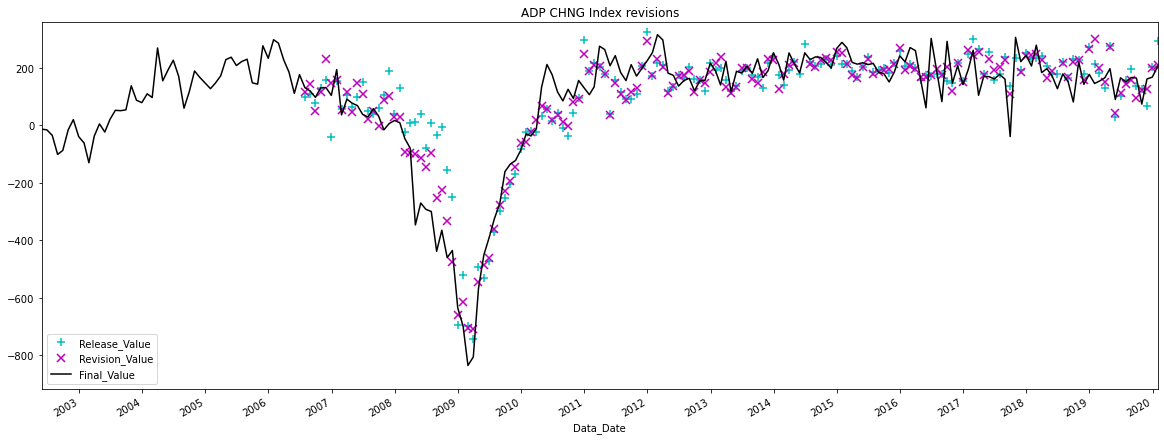

In [33]:
### RUN TO TESTING: RELEASES / REVISIONS PLOTTING TO VISUAL CONTROL (NO CHANGES)

### Index choosing:
str_test_index = 'ADP CHNG Index'
### Data loading:
df_dates_test = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
df_flags = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags)
### Flags printing:
print(df_flags.loc[str_test_index, All])
### Series creating:
df_eco_ind = df_dates_test.loc[(str_test_index, All), All].droplevel(0)[['Release_Value', 'Revision_Value', 'Final_Value']]
date_xlim_start = df_eco_ind.index.min()
date_xlim_finish = df_eco_ind.index.max()
#date_xlim_start = datetime(1984, 12, 31)
date_xlim_finish = datetime(2020, 1, 31)
flo_ylim_min = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].min().min()
flo_ylim_max = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].max().max()
tup_ylim = (flo_ylim_min - abs(flo_ylim_min) / 10, flo_ylim_max + abs(flo_ylim_max) / 10)
#ax_eco_ind = df_eco_ind.plot(figsize = (11, 2), title = str_test_index + ' revisions',                              
ax_eco_ind = df_eco_ind.plot(figsize = (20, 7.5), title = str_test_index + ' revisions', 
                style = ['c+', 'mx', 'k-'], markersize = 7.5, markeredgewidth = 1.5, 
                xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim, x_compat = True)
ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
plt.show() 

Type_Prime                                                   EMP
Type_Second                                                  Emp
Category                                              Coincident
Region                                                        US
Processing                                                  Flow
Base                                                          -1
SA_Status                                                Unclear
Frequency                                                Monthly
Negative                                                       0
Description    ADP National Employment Report Private Nonfarm...
Data_Source                       Automatic Data Processing, Inc
Notes          This indicator measures the number of employee...
Sub_Type                                                     Emp
Name: ADP CHNG Index, dtype: object


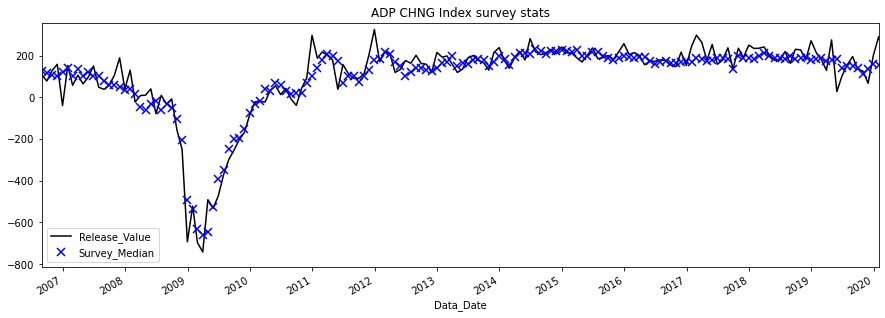

In [34]:
### RUN TO TESTING: SURVEYES PLOTTING TO VISUAL CONTROL (CELL TO ADD)

### Index choosing:
str_test_index = 'ADP CHNG Index'
### Data loading:
df_dates_test = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
df_flags = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags)
#### Flags printing:
print(df_flags.loc[str_test_index, All])
### Series creating:
if ((len(df_dates_test.loc[(str_test_index, All), 'Survey_Median'].dropna()) == 0) & 
    (len(df_dates_test.loc[(str_test_index, All), 'Survey_Average'].dropna()) == 0)):
    print('NO SURVEY DATA HERE!')
df_eco_ind = df_dates_test.loc[(str_test_index, All), All].droplevel(0)[['Survey_Median', 'Release_Value']]    
date_xlim_start = df_eco_ind[['Release_Value', 'Survey_Median']].dropna().index.min()
#date_xlim_finish = df_eco_ind[['Release_Value', 'Survey_Median']].dropna().index.max()
#date_xlim_start = datetime(1984, 12, 31)
date_xlim_finish = datetime(2020, 1, 31)
#date_xlim_finish = datetime(2020, 8, 31)
flo_ylim_min = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].min().min()
flo_ylim_max = df_eco_ind.loc[date_xlim_start : date_xlim_finish, All].max().max()
tup_ylim = (flo_ylim_min - abs(flo_ylim_min) / 10, flo_ylim_max + abs(flo_ylim_max) / 10)
ax_eco_ind = df_eco_ind[['Release_Value', 'Survey_Median']].plot(figsize = (15, 5.0), title = str_test_index + ' survey stats', 
                                                                 style = ['k-', 'bx'], markersize = 7.5, markeredgewidth = 1.5, x_compat = True,
                                                                 xlim = (date_xlim_start, date_xlim_finish), ylim = tup_ylim)
ax_eco_ind.xaxis.set_major_locator(mdates.YearLocator(base = 1))                             
ax_eco_ind.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))                
plt.show()

In [35]:
### RUN TO RE-EXPORT DATA: VALUES STACKING (NO CHANGES)

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
### Release pair stacking:
df_release_pair = df_dates_filled[['Release_Date', 'Release_Value']]
df_release_pair.columns = ['Observation_Date', 'Index_Value']
df_release_pair = df_release_pair.dropna()
ser_release_based = df_release_pair.set_index('Observation_Date', append = True).squeeze()
#df_release_pair['Stage'] = 'Release'
#ser_release_based = df_release_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### First revision pair stacking:
df_revision_pair = df_dates_filled[['Revision_Date', 'Revision_Value']]
df_revision_pair.columns = ['Observation_Date', 'Index_Value']
df_revision_pair = df_revision_pair.dropna()
ser_revision_based = df_revision_pair.set_index('Observation_Date', append = True).squeeze()
#df_revision_pair['Stage'] = 'First Revision'
#ser_revision_based = df_revision_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Final revision pair stacking:
df_final_pair = df_dates_filled[['Final_Date', 'Final_Value']]
df_final_pair.columns = ['Observation_Date', 'Index_Value']
df_final_pair = df_final_pair.dropna()
ser_final_based = df_final_pair.set_index('Observation_Date', append = True).squeeze()
#df_final_pair['Stage'] = 'Final Revision'
#ser_final_based = df_final_pair.set_index(['Observation_Date', 'Stage'], append = True).squeeze()
### Vectors aggregating:
ser_history_raw = ser_final_based.combine_first(ser_revision_based).combine_first(ser_release_based).dropna().sort_index()

In [36]:
### RUN TO RE-EXPORT DATA: FREQUENCY RECREATING (CELL TO REPLACE)

### 84 : BAKETOT Index frequency recreating:
ser_history_raw.loc['BAKETOT Index', pd.to_datetime('1994-12-23'), pd.to_datetime('1994-12-23')] = np.NaN
ser_history_raw.loc['BAKETOT Index', pd.to_datetime('1995-12-22'), pd.to_datetime('1995-12-22')] = np.NaN
### 87 : ITBCI Index frequency recreating:
ser_history_raw.loc['ITBCI Index', pd.to_datetime('2020-04-30'), pd.to_datetime('2020-04-30')] = np.NaN
### 88 : ITPSSA Index frequency recreating:
ser_history_raw.loc['ITPSSA Index', pd.to_datetime('2020-04-30'), pd.to_datetime('2020-04-30')] = np.NaN
### 89 : JCOMHCF Index frequency recreating:
idx_ticker_date = ser_history_raw.loc[['JCOMHCF Index'], All, All].index.get_level_values('Data_Date').unique()
idx_ticker_date = pd.date_range(start = '1984-12-31', end = '2004-03-31', freq = 'M').difference(idx_ticker_date)
idx_ticker_reindex = pd.MultiIndex.from_tuples(tuple(zip(['JCOMHCF Index'] * len(idx_ticker_date), idx_ticker_date, idx_ticker_date)))
ser_ei_to_add = pd.Series(np.NaN, index = idx_ticker_reindex)
ser_ei_to_add.index.names = ser_history_raw.index.names
ser_history_raw = pd.concat([ser_history_raw, ser_ei_to_add], axis = 0)
### 90 : JNPIY Index frequency rerceating:
ser_history_raw.loc['JNPIY Index', pd.to_datetime('2001-02-28'), pd.to_datetime('2001-02-28')] = np.NaN
### 91 : MAPMINDX Index frequency recreating:
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-05-31'), pd.to_datetime('2016-05-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-06-30'), pd.to_datetime('2016-06-30')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-07-31'), pd.to_datetime('2016-07-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-08-31'), pd.to_datetime('2016-08-31')] = np.NaN
ser_history_raw.loc['MAPMINDX Index', pd.to_datetime('2016-09-30'), pd.to_datetime('2016-09-30')] = np.NaN
### 92 : MPMIGBMA Index frequency recreating:
idx_ticker_date = pd.date_range(start = '2014-01-31', end = '2015-11-30', freq = 'M')
idx_ticker_reindex = pd.MultiIndex.from_tuples(tuple(zip(['MPMIGBMA Index'] * len(idx_ticker_date), idx_ticker_date, idx_ticker_date)))
ser_ei_to_add = pd.Series(np.NaN, index = idx_ticker_reindex)
ser_ei_to_add.index.names = ser_history_raw.index.names
ser_history_raw = pd.concat([ser_history_raw, ser_ei_to_add], axis = 0)
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2012-05-31'), pd.to_datetime('2012-05-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2013-02-28'), pd.to_datetime('2013-02-28')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-01-31'), pd.to_datetime('2016-01-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-02-29'), pd.to_datetime('2016-02-29')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-06-30'), pd.to_datetime('2016-06-30')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-07-31'), pd.to_datetime('2016-07-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-08-31'), pd.to_datetime('2016-08-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2016-12-31'), pd.to_datetime('2016-12-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2017-03-31'), pd.to_datetime('2017-03-31')] = np.NaN
ser_history_raw.loc['MPMIGBMA Index', pd.to_datetime('2017-04-30'), pd.to_datetime('2017-04-30')] = np.NaN
### 94 : NERS20Y Index frequency recreating:
ser_history_raw.loc['NERS20Y Index', pd.to_datetime('2001-07-31'), pd.to_datetime('2001-07-31')] = np.NaN
### 95 : PTCCI Index frequency recreating:
ser_history_raw.loc['PTCCI Index', pd.to_datetime('2004-05-31'), pd.to_datetime('2004-05-31')] = np.NaN
### 96 : PTCPHAMM Index frequency recreating:
ser_history_raw.loc['PTCPHAMM Index', pd.to_datetime('2019-01-31'), pd.to_datetime('2019-01-31')] = np.NaN
### 97 : UKCCI Index frequency recreating:
ser_history_raw.loc['UKCCI Index', pd.to_datetime('1995-05-31'), pd.to_datetime('1995-05-31')] = np.NaN
### Index sorting:
ser_history_raw = ser_history_raw.sort_index()
### Results saving:
ser_history_raw.to_hdf(str_path_bb_idx_hdf, key = str_key_raw_history, mode = 'a')

In [37]:
### RUN TO TESTING: FREQUENCY CONTROL (NO CHANGES)

ser_history_raw = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_history)
ser_idx_test = ser_history_raw.to_frame().reset_index('Data_Date')['Data_Date'].squeeze().reset_index('Observation_Date', drop = True)
ser_idx_test = ser_idx_test.groupby('Index_Name', group_keys = False).apply(lambda ser_ticker: ser_ticker.drop_duplicates())
df_idx_test = ser_idx_test.groupby('Index_Name').apply(lambda ser_ticker: (ser_ticker - ser_ticker.shift()).dt.days).groupby('Index_Name')\
                                                                                                                    .agg(['min', 'max', 'median'])
df_idx_test['delta'] = df_idx_test['max'] - df_idx_test['min']
df_idx_test.sort_values('delta')

,min,max,median,delta
Index_Name,,,,
INJCSP Index,7.0,7.0,7.0,0.0
COMFCOMF Index,7.0,7.0,7.0,0.0
BAKETOT Index,7.0,7.0,7.0,0.0
INJCJC Index,7.0,7.0,7.0,0.0
GDP CQOQ Index,90.0,92.0,91.0,2.0
...,...,...,...,...
IECPEUIQ Index,28.0,31.0,31.0,3.0
IECPIMOM Index,28.0,31.0,31.0,3.0
IECSINDX Index,28.0,31.0,31.0,3.0


In [38]:
### RUN TO RE-EXPORT DATA: HISTORY REINDEXATION TO OBSERVATION DATE BUSINESS DAILY MATRIX STRUCTURE (NO CHANGES)

### Data loading:
ser_history_raw = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_history)
### Moving all dates to tne nearest Business day:
df_history_raw = ser_history_raw.to_frame().reset_index('Observation_Date')
df_history_raw['Observation_Date'] = df_history_raw['Observation_Date'] + 0 * pd.offsets.BDay()
ser_history_bday = df_history_raw.set_index('Observation_Date', append = True).squeeze()
ser_history_bday = ser_history_bday.loc[All, All, idx_date_range]
### Data adding to hdf collection:
ser_history_bday.to_hdf(str_path_bb_idx_hdf, key = str_key_bday_history, mode = 'a') ### BDay moved observation dates

In [39]:
### RUN TO RE-EXPORT DATA: GROUPING RESEARCH TO SELECT BASIS TICKERS (CELL TO REPLACE)

### Defining minimum Data Date for each ticker:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)
ser_min_date = ser_history_bday.to_frame().reset_index('Data_Date').drop(0, axis = 1).reset_index('Observation_Date', drop = True).squeeze().groupby('Index_Name')\
                                                                                                                                            .agg(min)
ser_min_date.name = 'Min_Date'
ser_max_date = ser_history_bday.to_frame().reset_index('Data_Date').drop(0, axis = 1).reset_index('Observation_Date', drop = True).squeeze().groupby('Index_Name')\
                                                                                                                                            .agg(max)
ser_max_date.name = 'Max_Date'
### Creating description table for all types combinations:
df_flags = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags)
### Defining description table generator:
def type_analyzer(df_group):
    ### Type tickers distribution by region calculating:
    ser_cat_distribution = df_group.groupby('Category').apply(lambda df_category: len(df_category.index))
    ser_cat_distribution['All'] = len(df_group.index)
    ser_cat_distribution = pd.concat([ser_cat_distribution], keys = ['Categories_Distrib'], names = ['Info'])
    ### Adding information about basis ticker for each type:
    ser_cat_distribution['Basic_Ticker_Info', 'Basic_Name'] = df_group['Min_Date'].idxmin()
    ser_cat_distribution['Basic_Ticker_Info', 'Category'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Category']
    ser_cat_distribution['Basic_Ticker_Info', 'Min_Date'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Min_Date']    
    ser_cat_distribution['Basic_Ticker_Info', 'Description'] = df_group.loc[df_group['Min_Date'].idxmin(), 'Description']     
    ### Results output:
    return ser_cat_distribution
### Extending flags table and dropping tickers, that were cleared earlier:
df_flags_typed = pd.concat([df_flags, ser_min_date, ser_max_date], axis = 1, sort = False)
df_flags_typed = df_flags_typed.loc[df_flags_typed['Min_Date'].notna()]
### Description table generating:
df_type_info = df_flags_typed.groupby(['Type_Prime', 'Sub_Type', 'Region']).apply(type_analyzer)
df_type_info = df_type_info.unstack(['Info', 'Category'], fill_value = 0)
df_type_info.columns.names = ['', '']
df_type_info = df_type_info.sort_index(axis = 1)
### Description table editing to choose proper basic tickers in some cases:
df_type_info.loc[('ANT', 'Bus', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUBCI Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('ANT', 'Bus', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['NAPMPMI Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('ANT', 'Cons', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUCCEMU Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['USURTOT Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Orders', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['TMNOCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Prod', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNIPMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info[('Basic_Ticker_Info', 'Min_Date')] = pd.to_datetime(df_type_info[('Basic_Ticker_Info', 'Min_Date')])
### Description table additional editing to optimize groups:
df_type_info.loc[('ANT', 'Bus', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['ITSR1B Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('CON', 'Cons', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNDSTYOY Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('CON', 'Cons', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['PITLCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UMRTEMU Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('EMP', 'Emp', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UKUEMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['ECCPEMUM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'UK'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['UKRPXYOY Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('INF', 'CPI', 'US'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['PCE CMOM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Orders', 'Japan'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['JNMOCHNG Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
df_type_info.loc[('OUT', 'Prod', 'Europe'), ('Basic_Ticker_Info', ['Basic_Name', 'Category', 'Description', 'Min_Date'])] = \
df_flags_typed.loc[['EUITEMUM Index'], ['Category', 'Description', 'Min_Date']].reset_index().values[0]
## Binding each ticker with it's basis:
df_basic_ticker = df_type_info[[('Basic_Ticker_Info', 'Basic_Name'), ('Basic_Ticker_Info', 'Min_Date')]]
df_basic_ticker.columns = ['Basic_Ticker', 'Basic_Min_Date']
df_flags_typed = df_flags_typed.join(df_basic_ticker, how = 'left', on = ['Type_Prime', 'Sub_Type', 'Region'])
### Clearing basic ticker for basic tickers and resort values to guarantee basic tickers priority:
df_flags_typed.loc[df_flags_typed.index == df_flags_typed['Basic_Ticker'], 'Basic_Ticker'] = ''
df_flags_typed = df_flags_typed.groupby('Basic_Ticker', group_keys = False).apply(lambda df_group: df_group.sort_index())
### Adding flag to define if we need to rebase ticker:
df_flags_typed['Rebase_Flag'] = True
df_flags_typed.loc[df_flags_typed['Basic_Ticker'] == '', 'Rebase_Flag'] = False
df_flags_typed.loc[df_flags_typed['Min_Date'] < (datetime_basis - pd.DateOffset(years = int_not_to_rebase_term)), 'Rebase_Flag'] = False
df_flags_typed.loc[df_flags_typed['Min_Date'] < (df_flags_typed['Basic_Min_Date'] + pd.DateOffset(years = int_not_to_rebase_diff)), 'Rebase_Flag'] = False
### Columns reordering and filtering:
df_flags_typed = df_flags_typed[['Type_Prime', 'Sub_Type', 'Region', 'Category', 'Min_Date', 'Max_Date', 'Frequency', 'Processing', 'Base', 'SA_Status', 'Negative',
                                 'Rebase_Flag', 'Basic_Ticker', 'Description', 'Data_Source', 'Notes']]
df_flags_typed.index.names = ['Index_Name']
### Results saving:
df_type_info.to_hdf(str_path_bb_idx_hdf, key = str_key_types_info, mode = 'a')
df_flags_typed.to_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed, mode = 'a')
#df_type_info.to_excel('Data_Files/Test_Files/Ticker_Info.xlsx', merge_cells = False)
#df_flags_typed.to_excel('Data_Files/Test_Files/Ticker_Info.xlsx', merge_cells = False)

In [ ]:
### RUN TO RE-EXPORT DATA: HISTORY DATA TRANSFORMATION : ANTICIPATION ONLY (NO CHANGES)

### Defining parallelized transform for groupby groups:
def transformParallel(serGrouped, func):
    retLst = Parallel(n_jobs = 4)(delayed(func)(group) for name, group in serGrouped)    
    return pd.concat(retLst)
### Defining Economic Index series transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Data_Date')
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result
    ### X13 ARIMA Seasonality adjustment model:
    def perform_x13_sa(ser_date):
        ### Dropping constant level:        
        ser_result = ser_date.droplevel('Observation_Date')
        ### Check for not empty vector:
        if (ser_result.count() > 0):
            ### Check for minimal quantity of observations to perform seasonality adjustment:
            if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                ### Naming series for x13 performing:
                ser_result.name = 'Ticker'
                ### Calculating shift value to make all series positive:
                flo_positron = abs(ser_result.min()) * 2
                try:
                    ### Performing seasonality adjustment:
                    ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
#                    print('SA success : ', ser_date.index.get_level_values('Observation_Date')[0])                 
                except:
                    print('SA error : ', ser_date.index.get_level_values('Observation_Date')[0])
                    pass
        ### Results output:                
#        return ser_result 
        return pd.concat([ser_result], keys = [ser_date.index.get_level_values('Observation_Date')[0]], names = ['Observation_Date'])    
    ### Extracting Observation Date column for ticker:
    def get_obs_date_vector(str_ticker, str_path_bb_matrix_hdf, str_date, bool_exact_date = False, bool_drop_levels = True):
        ### Vector for exact date:
        if bool_exact_date:
            ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
        ### Vector for nearest date:        
        else:
            ### Loading full ticker series:        
            ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
            ### Extracting data for max date less or equal to needed date:
            ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
        ### Dropping constant index levels if needed:
        if bool_drop_levels:
            return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
        else:
            return ser_obs_date    
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                        str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag, list_continue_rebase):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')                    
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range).sort_values()
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type_Prime'] == 'TAR'):
        print(str_index_name, ': TAR Primary Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Indices of NA values collecting:
        idx_isna = ser_triangle.loc[ser_triangle.isna()].index
        ### Transforming to stock-like series:
        ser_stock = ser_triangle
        ### Seasonality adjustment:
        if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
            print(str_index_name, ': Seasonality adjustment')            
            ### Filling empty values:            
            ser_stock = ser_stock.groupby('Observation_Date').ffill()
#            ser_stock = ser_stock.groupby('Observation_Date').apply(perform_x13_sa).swaplevel().sort_index()
            ser_stock = transformParallel(ser_stock.groupby('Observation_Date'), perform_x13_sa).swaplevel().sort_index()       
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN    
        ### Debasing:
        print(str_index_name, ': Debasing')            
        ser_ant = ser_stock - ser_flags['Base']           
        ser_ant.name = 'MoM'
        ### Negative flag check:
        if (ser_flags['Negative'] == 1):
            ser_ant = -ser_ant
        ### Z-scoring across the observation dates:
        print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
        ### To stop rebasing when basic ticker (std, mean) are close to (1, 0):
        list_continue_rebase = [True] 
        ### Adjusting Z-score period limit for some groups:
        if (ser_flags['Data_Source'] == 'Markit'):
            int_min_years_adj = int_min_years - 1
        else:
            int_min_years_adj = int_min_years    
        ### Z-score tranformation:
        ser_ant_z = ser_ant.groupby('Observation_Date')\
                           .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                      str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'], list_continue_rebase)       
        ### Adding results to matrix cube:
        pd.concat([ser_ant_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                       complevel = 9, append = True, mode = 'a',
                                                                                       min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return pd.concat([ser_mom_z], keys = [str_index_name], names = ['Index_Name'])

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
df_flags_ant = df_flags_typed[(df_flags_typed['Type_Prime'] == 'ANT') & (df_flags_typed['Processing'] == 'Index')]
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)
ser_history_ant = ser_history_bday.reindex(df_flags_ant.index, level = 'Index_Name')
### Previous HDF file deleting:
if os.path.isfile(str_path_bb_matrix_ant_hdf):
    os.remove(str_path_bb_matrix_ant_hdf)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_ant.index.levels[0].str.len())
### Data transforming:
ser_history_ant.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years_z_score, str_path_bb_matrix_ant_hdf, 
                                            bool_perform_sa = True)

In [ ]:
### RUN TO RE-EXPORT DATA: HISTORY DATA TRANSFORMATION : YOY ONLY (NO CHANGES)

### Defining parallelized transform for groupby groups:
def transformParallel(serGrouped, func):
    retLst = Parallel(n_jobs = 4)(delayed(func)(group) for name, group in serGrouped)    
    return pd.concat(retLst)
### Defining Economic Index series transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Data_Date')
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result
    ### Period-over-period-percent ticker values transforming to stock-like series:
    def pop_to_level(ser_date, int_step):
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Observation_Date')
        ### Basis initiating:
        flo_basement = 1.0
        ### Factor initiating: 
        flo_next_brick  = 1.0
        ### Looping over month numbers:
        for iter_period in range(min(int_step, len(ser_result.index))):         
            ### Basement building up:
            flo_basement = flo_basement * flo_next_brick
            ### Next basement brick producing:
            flo_next_brick = ((flo_next_brick ** (iter_period)) * (ser_result.iloc[iter_period] ** (1 / int_step))) ** (1 / (iter_period + 1)) 
            ### Jumping cumulative product performing:
            idx_iter_data = ser_result.index[iter_period :: int_step]
            ser_result.loc[idx_iter_data] = ser_result.loc[idx_iter_data].cumprod() * flo_basement       
        ### Results output:            
        return ser_result    
    ### X13 ARIMA Seasonality adjustment model:
    def perform_x13_sa(ser_date):
        ### Dropping constant level:        
        ser_result = ser_date.droplevel('Observation_Date')
        ### Check for not empty vector:
        if (ser_result.count() > 0):
            ### Check for minimal quantity of observations to perform seasonality adjustment:
            if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                ### Naming series for x13 performing:
                ser_result.name = 'Ticker'
                ### Calculating shift value to make all series positive:
                flo_positron = abs(ser_result.min()) * 2
                try:
                    ### Performing seasonality adjustment:
                    ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
#                    print('SA success : ', ser_date.index.get_level_values('Observation_Date')[0])                 
                except:
                    print('SA error : ', ser_date.index.get_level_values('Observation_Date')[0])
                    pass
        ### Results output:                
#        return ser_result 
        return pd.concat([ser_result], keys = [ser_date.index.get_level_values('Observation_Date')[0]], names = ['Observation_Date'])    
    ### Extracting Observation Date column for ticker:
    def get_obs_date_vector(str_ticker, str_path_bb_matrix_hdf, str_date, bool_exact_date = False, bool_drop_levels = True):
        ### Vector for exact date:
        if bool_exact_date:
            ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
        ### Vector for nearest date:        
        else:
            ### Loading full ticker series:        
            ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
            ### Extracting data for max date less or equal to needed date:
            ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
        ### Dropping constant index levels if needed:
        if bool_drop_levels:
            return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
        else:
            return ser_obs_date    
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                        str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag, list_continue_rebase):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')                    
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range).sort_values()
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type_Prime'] == 'TAR'):
        print(str_index_name, ': TAR Primary Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Indices of NA values collecting:
        idx_isna = ser_triangle.loc[ser_triangle.isna()].index
        ### Transforming to stock-like series:
        if (ser_flags['Processing'] in ['Index', 'Level', 'Level%']):
            ser_stock = ser_triangle
        elif (ser_flags['Processing'] == 'Flow'):
            print(str_index_name, ': Transformation to stock-like series: Cumulative sum')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Cumulative sum for each observation date calculating:
            ser_stock = ser_triangle.groupby('Observation_Date').cumsum()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        else:
            print(str_index_name, ': Transformation to stock-like series: Cumulative product')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Percents to multipliers converting:
            ser_stock = 1 + ser_triangle / 100
            ### Calculating with needed periodicity:
            if (ser_flags['Frequency'] == 'Monthly'):
                int_step = dict_cumprod_step[ser_flags['Processing']]
                ### Period-by-period cumprod with rebasing:
                ser_stock = ser_stock.groupby('Observation_Date').apply(pop_to_level, int_step).swaplevel().sort_index()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        ### Seasonality adjustment:
        if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
            print(str_index_name, ': Seasonality adjustment')            
            ### Filling empty values:            
            ser_stock = ser_stock.groupby('Observation_Date').ffill()
#            ser_stock = ser_stock.groupby('Observation_Date').apply(perform_x13_sa).swaplevel().sort_index()
            ser_stock = transformParallel(ser_stock.groupby('Observation_Date'), perform_x13_sa).swaplevel().sort_index()       
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN    
        ### Transforming to PoP series:
        if (ser_flags['Processing'] == 'Index'):
            ### Debasing only:
            print(str_index_name, ': Transformation to YoY series: Debasing')            
            ser_ant = ser_stock - ser_flags['Base']           
        elif (ser_flags['Processing'] in ['Flow', 'Level']):    
            ### Simple difference:
            print(str_index_name, ': Transformation to YoY series: Simple difference')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']            
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False).apply(lambda ser_obs_date: ser_obs_date - ser_obs_date.shift(int_yoy_shift))
        else:      
            ### Difference with dividing:
            print(str_index_name, ': Transformation to YoY series: Difference with dividing')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False)\
                               .apply(lambda ser_obs_date: (ser_obs_date / ser_obs_date.shift(int_yoy_shift) - 1))  
        ser_yoy.name = 'YoY'
        ### Negative flag check:
        if (ser_flags['Negative'] == 1):
            ser_yoy = -ser_yoy
        ### Z-scoring across the observation dates:
        print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
        ### To stop rebasing when basic ticker (std, mean) are close to (1, 0):
        list_continue_rebase = [True] 
        ### Adjusting Z-score period limit for some groups:
        if (ser_flags['Data_Source'] == 'Markit'):
            int_min_years_adj = int_min_years - 1
        else:
            int_min_years_adj = int_min_years    
        ### Z-score tranformation:
        ser_yoy_z = ser_yoy.groupby('Observation_Date')\
                           .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                      str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'], list_continue_rebase)       
#        ser_yoy_z = transformParallel(ser_yoy.groupby('Observation_Date'), by_date_z_score_to_parallel).sort_index() ### Parallelization attempt
        ### Adding results to matrix cube:
        pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                       complevel = 9, append = True, mode = 'a',
                                                                                       min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name'])

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
df_flags_other = df_flags_typed[(df_flags_typed['Type_Prime'] != 'ANT') & (df_flags_typed['Processing'] != 'Index')]
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)
ser_history_other = ser_history_bday.reindex(df_flags_other.index, level = 'Index_Name')#.loc[['GRFRIAMM Index', 'ITVHYOY Index', 'NERS20Y Index'], All, All]
### Previous HDF file deleting:
if os.path.isfile(str_path_bb_matrix_yoy_hdf):
    os.remove(str_path_bb_matrix_yoy_hdf)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_other.index.levels[0].str.len())
### Data transforming:
ser_history_other.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years_z_score, 
                                              str_path_bb_matrix_yoy_hdf, bool_perform_sa = True)

ECCPEMUM Index : Reindexation
ECCPEMUM Index : Transformation to stock-like series: Cumulative product
ECCPEMUM Index : Seasonality adjustment
ECCPEMUM Index : Transformation to YoY series: Difference with dividing
ECCPEMUM Index : Z-scoring across the observation dates
EUGNEMUQ Index : Reindexation
EUGNEMUQ Index : TAR Primary Type ignoring
EUITEMUM Index : Reindexation
EUITEMUM Index : Transformation to stock-like series: Cumulative product
EUITEMUM Index : Transformation to YoY series: Difference with dividing
EUITEMUM Index : Z-scoring across the observation dates
EUPPEMUM Index : Reindexation
EUPPEMUM Index : Transformation to stock-like series: Cumulative product
EUPPEMUM Index : Seasonality adjustment
EUPPEMUM Index : Transformation to YoY series: Difference with dividing
EUPPEMUM Index : Z-scoring across the observation dates
GDP CQOQ Index : Reindexation
GDP CQOQ Index : TAR Primary Type ignoring
GRFRIAMM Index : Reindexation
GRFRIAMM Index : Transformation to stock-like serie

In [ ]:
### RUN TO RE-EXPORT DATA: Z_SCORED EI DIAGONAL CONSTRUCTING (NO CHANGES)

### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_bday_history)
### Tickers list preparing:
idx_ticker_list = ser_history_bday.index.levels[0]
### Internal links between matrix files and diagonal keys:
dict_diag_link = {}
dict_diag_link[str_key_diag_daily_ant] = str_path_bb_matrix_ant_hdf
#dict_diag_link[str_key_diag_daily_mom] = str_path_bb_matrix_mom_hdf
#dict_diag_link[str_key_diag_daily_qoq] = str_path_bb_matrix_qoq_hdf
dict_diag_link[str_key_diag_daily_yoy] = str_path_bb_matrix_yoy_hdf
### Looping over transformation ways:
for iter_way in dict_diag_link:
    ### File linking:
    str_path_bb_matrix_hdf = dict_diag_link[iter_way]
    ### Creating container for tickers diagonals:
    gc.collect()
    dict_ei_diag = {}
    ### Looping over tickers:
    for iter_ticker in idx_ticker_list:
        ### Loading matrix for each ticker:
        ser_iter_matrix = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == iter_ticker')
        ### Excluding TAR tickers:
        if (len(ser_iter_matrix) > 0):
            print(iter_way, ':', iter_ticker, 'performing')
            ser_iter_matrix = ser_iter_matrix.droplevel('Index_Name')
            ### Extracting unique observation dates for each ticker later than diagonal start date:
            idx_date_list = ser_iter_matrix.loc[All, date_diag_start : ].index.dropna().get_level_values('Observation_Date').unique()
            ### Creating future diagonal vector:
            ser_iter_diag = pd.Series(np.NaN, idx_date_list)    
            ### Determining first valid date and first date to place z-scoring results on diagonal:
            ### Looping over unique dates:
            for iter_date in idx_date_list:
                ### Trying to get the latest data date observation:
                try:
                    ser_iter_diag[iter_date] = ser_iter_matrix.loc[All, iter_date].dropna()[-1]
                except:
                    pass
            ### Checking for data earlier than diagonal start date:
            if ((ser_iter_matrix.index.get_level_values('Observation_Date').unique().min() < date_diag_start) & pd.notna(ser_iter_diag.values[0])):
                ### Turning diagonal start date column to diagonal with data dates as index dates:
                ser_iter_start_col = ser_iter_matrix.loc[ : idx_date_list[0], [idx_date_list[0]]]
                ### Ticker values on the date to turn:
                list_iter_values_to_turn = ser_iter_start_col.values
                ### Implementing lag before the announcement for the first valid observation date (3 years of data dates with equal first valid index):
                int_release_lag = (ser_iter_start_col.dropna().index[-1][-1] - ser_iter_start_col.dropna().index[-1][0]).days
                ### Taking announcement dates as an index for first column values:
                list_iter_index_to_turn = ser_iter_start_col.index.get_level_values('Data_Date') + pd.offsets.Day(int_release_lag)
                ### Modified column to turn:
                ser_iter_to_turn = pd.Series(list_iter_values_to_turn, index = list_iter_index_to_turn)
                ### Dropping repeated dates and empty dates:
                ser_iter_to_turn = ser_iter_to_turn.groupby(level = 0).apply(lambda ser_date: ser_date[-1]).dropna()
                ### Cutting series not to intersect with diagonal index:
                ser_iter_to_turn = ser_iter_to_turn.loc[ : idx_date_list[0] - pd.offsets.Day(1)]
                ### Joining series:
                ser_iter_diag = pd.concat([ser_iter_to_turn, ser_iter_diag], axis = 0).sort_index() 
            ### Reindexation to business daily vector and forward filling:
            ser_iter_diag = ser_iter_diag.ffill().reindex(idx_date_range).ffill()
            ### Saving ticker diagonal to the container:
            dict_ei_diag[iter_ticker] = ser_iter_diag
        else:
            print(iter_way, ':', iter_ticker, 'is absent for this way')
    ### Aggregating ticker diagonals:
    ser_diagonal_z = pd.concat(dict_ei_diag, axis = 0)
    ser_diagonal_z.index.names = ['Index_Name', 'Date']
    ser_diagonal_z.name = 'EI_diagonal'
    ### Saving results to hdf file:
    ser_diagonal_z.to_hdf(str_path_bb_diag_hdf, key = iter_way, mode = 'a')

In [ ]:
### RUN TO RE-EXPORT DATA: REPLACING RELEASE VALUES WITH SURVEY MEDIANS TO NORMALIZE SURVEY MEDIAN BY MATRIX STRUCTURE TRANSFORMATION (CELL TO ADD)

### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
### Data loading:
ser_history_survey = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_history)
### Release pair stacking:
df_release_pair = df_dates_filled[['Release_Date', 'Release_Value']]
df_release_pair.columns = ['Observation_Date', 'Release_Value']
df_release_pair = df_release_pair.dropna()
ser_release_based = df_release_pair.set_index('Observation_Date', append = True).squeeze()

### Survey pair stacking:
df_survey_pair = df_dates_filled[['Release_Date', 'Survey_Median']]
df_survey_pair.columns = ['Observation_Date', 'Index_Value']
df_survey_pair = df_survey_pair.dropna()
ser_survey_based = df_survey_pair.set_index('Observation_Date', append = True).squeeze()
idx_survey_indices = ser_survey_based.index.get_level_values('Index_Name').unique()
ser_survey_based = ser_release_based.to_frame().join(ser_survey_based, how = 'left')['Index_Value']

ser_history_survey.loc[ser_survey_based.index] = ser_survey_based.values
ser_history_survey = ser_history_survey.loc[idx_survey_indices]

ser_history_survey.to_hdf(str_path_bb_idx_hdf, key = str_key_survey_history, mode = 'a')

In [ ]:
### RUN TO RE-EXPORT DATA: SURVEY DATA TRANSFORMATION : ANTICIPATION ONLY (CELL TO ADD)

gc.collect()
### Defining parallelized transform for groupby groups:
def transformParallel(serGrouped, func):
    retLst = Parallel(n_jobs = 4)(delayed(func)(group) for name, group in serGrouped)    
    return pd.concat(retLst)
### Defining Economic Index series transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Data_Date')
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result
    ### X13 ARIMA Seasonality adjustment model:
    def perform_x13_sa(ser_date):
        ### Dropping constant level:        
        ser_result = ser_date.droplevel('Observation_Date')
        ### Check for not empty vector:
        if (ser_result.count() > 0):
            ### Check for minimal quantity of observations to perform seasonality adjustment:
            if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                ### Naming series for x13 performing:
                ser_result.name = 'Ticker'
                ### Calculating shift value to make all series positive:
                flo_positron = abs(ser_result.min()) * 2
                try:
                    ### Performing seasonality adjustment:
                    ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
#                    print('SA success : ', ser_date.index.get_level_values('Observation_Date')[0])                 
                except:
                    print('SA error : ', ser_date.index.get_level_values('Observation_Date')[0])
                    pass
        ### Results output:                
#        return ser_result 
        return pd.concat([ser_result], keys = [ser_date.index.get_level_values('Observation_Date')[0]], names = ['Observation_Date'])    
    ### Extracting Observation Date column for ticker:
    def get_obs_date_vector(str_ticker, str_path_bb_matrix_hdf, str_date, bool_exact_date = False, bool_drop_levels = True):
        ### Vector for exact date:
        if bool_exact_date:
            ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
        ### Vector for nearest date:        
        else:
            ### Loading full ticker series:        
            ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
            ### Extracting data for max date less or equal to needed date:
            ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
        ### Dropping constant index levels if needed:
        if bool_drop_levels:
            return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
        else:
            return ser_obs_date    
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                        str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag, list_continue_rebase):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')                    
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range).sort_values()
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type_Prime'] == 'TAR'):
        print(str_index_name, ': TAR Primary Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Indices of NA values collecting:
        idx_isna = ser_triangle.loc[ser_triangle.isna()].index
        ### Transforming to stock-like series:
        ser_stock = ser_triangle
        ### Seasonality adjustment:
        if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
            print(str_index_name, ': Seasonality adjustment')            
            ### Filling empty values:            
            ser_stock = ser_stock.groupby('Observation_Date').ffill()
#            ser_stock = ser_stock.groupby('Observation_Date').apply(perform_x13_sa).swaplevel().sort_index()
            ser_stock = transformParallel(ser_stock.groupby('Observation_Date'), perform_x13_sa).swaplevel().sort_index()       
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN    
        ### Debasing:
        print(str_index_name, ': Debasing')            
        ser_ant = ser_stock - ser_flags['Base']           
        ser_ant.name = 'MoM'
        ### Negative flag check:
        if (ser_flags['Negative'] == 1):
            ser_ant = -ser_ant
        ### Z-scoring across the observation dates:
        print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
        ### To stop rebasing when basic ticker (std, mean) are close to (1, 0):
        list_continue_rebase = [True] 
        ### Adjusting Z-score period limit for some groups:
        if (ser_flags['Data_Source'] == 'Markit'):
            int_min_years_adj = int_min_years - 1
        else:
            int_min_years_adj = int_min_years    
        ### Z-score tranformation:
        ser_ant_z = ser_ant.groupby('Observation_Date')\
                           .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                      str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'], list_continue_rebase)       
        ### Adding results to matrix cube:
        pd.concat([ser_ant_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                       complevel = 9, append = True, mode = 'a',
                                                                                       min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return pd.concat([ser_mom_z], keys = [str_index_name], names = ['Index_Name'])

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
df_flags_ant = df_flags_typed[(df_flags_typed['Type_Prime'] == 'ANT') & (df_flags_typed['Processing'] == 'Index')]
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_survey_history)
ser_history_ant = ser_history_bday.reindex(df_flags_ant.index, level = 'Index_Name')
### Previous HDF file deleting:
if os.path.isfile(str_path_survey_matrix_ant_hdf):
    os.remove(str_path_survey_matrix_ant_hdf)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_ant.index.levels[0].str.len())
### Data transforming:
ser_history_ant.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years_z_score, 
                                            str_path_survey_matrix_ant_hdf, bool_perform_sa = True)

In [ ]:
### RUN TO RE-EXPORT DATA: SURVEY DATA TRANSFORMATION : YOY ONLY (CELL TO ADD)

### Defining parallelized transform for groupby groups:
def transformParallel(serGrouped, func):
    retLst = Parallel(n_jobs = 4)(delayed(func)(group) for name, group in serGrouped)    
    return pd.concat(retLst)
### Defining Economic Index series transformation:
def complex_transform(ser_name, idx_date_range, df_flags, int_max_name_length, int_min_years, str_path_bb_matrix_hdf, bool_perform_sa = False):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Data_Date')
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result
    ### Period-over-period-percent ticker values transforming to stock-like series:
    def pop_to_level(ser_date, int_step):
        ### Dropping constant level:
        ser_result = ser_date.droplevel('Observation_Date')
        ### Basis initiating:
        flo_basement = 1.0
        ### Factor initiating: 
        flo_next_brick  = 1.0
        ### Looping over month numbers:
        for iter_period in range(min(int_step, len(ser_result.index))):         
            ### Basement building up:
            flo_basement = flo_basement * flo_next_brick
            ### Next basement brick producing:
            flo_next_brick = ((flo_next_brick ** (iter_period)) * (ser_result.iloc[iter_period] ** (1 / int_step))) ** (1 / (iter_period + 1)) 
            ### Jumping cumulative product performing:
            idx_iter_data = ser_result.index[iter_period :: int_step]
            ser_result.loc[idx_iter_data] = ser_result.loc[idx_iter_data].cumprod() * flo_basement       
        ### Results output:            
        return ser_result    
    ### X13 ARIMA Seasonality adjustment model:
    def perform_x13_sa(ser_date):
        ### Dropping constant level:        
        ser_result = ser_date.droplevel('Observation_Date')
        ### Check for not empty vector:
        if (ser_result.count() > 0):
            ### Check for minimal quantity of observations to perform seasonality adjustment:
            if (ser_result.last_valid_index() - ser_result.first_valid_index()).days >= (int_min_years * 365):   
                ### Naming series for x13 performing:
                ser_result.name = 'Ticker'
                ### Calculating shift value to make all series positive:
                flo_positron = abs(ser_result.min()) * 2
                try:
                    ### Performing seasonality adjustment:
                    ser_result = x13_arima_analysis(ser_result + flo_positron, outlier = True, trading = True).seasadj - flo_positron
#                    print('SA success : ', ser_date.index.get_level_values('Observation_Date')[0])                 
                except:
                    print('SA error : ', ser_date.index.get_level_values('Observation_Date')[0])
                    pass
        ### Results output:                
#        return ser_result 
        return pd.concat([ser_result], keys = [ser_date.index.get_level_values('Observation_Date')[0]], names = ['Observation_Date'])    
    ### Extracting Observation Date column for ticker:
    def get_obs_date_vector(str_ticker, str_path_bb_matrix_hdf, str_date, bool_exact_date = False, bool_drop_levels = True):
        ### Vector for exact date:
        if bool_exact_date:
            ser_obs_date = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date == str_date')
        ### Vector for nearest date:        
        else:
            ### Loading full ticker series:        
            ser_z_scored = pd.read_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker & Observation_Date <= str_date')
            ### Extracting data for max date less or equal to needed date:
            ser_obs_date = ser_z_scored.loc[All, All, [ser_z_scored.index.levels[-1].max()]]
        ### Dropping constant index levels if needed:
        if bool_drop_levels:
            return ser_obs_date.droplevel(['Index_Name', 'Observation_Date'])
        else:
            return ser_obs_date    
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, 
                        str_path_bb_matrix_hdf, str_basis_index, bool_rebase_flag, list_continue_rebase):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                    ### Checking if rebasing needed:
                    if (bool(str_basis_index) & bool_rebase_flag & list_continue_rebase[0]):
                        ### Extracting column from z-scored basis ticker series:
                        str_obs_date = ser_date.index[0][1].strftime('%Y-%m-%d')                    
                        ser_basis_date = get_obs_date_vector(str_basis_index, str_path_bb_matrix_hdf, str_obs_date, bool_exact_date = False, bool_drop_levels = True)
                        ### Selecting only intersected time interval:
                        ser_basis_part = ser_basis_date.loc[ser_date.first_valid_index()[0]: ]
                        ### Rebasing ticker:
                        ser_date = ser_date * ser_basis_part.std() + ser_basis_part.mean()
                        ### Checking if future rebasing needed:
                        if ((abs(ser_basis_part.std() - 1) < flo_tolerance) & (abs(ser_basis_part.mean()) < flo_tolerance)):
                            list_continue_rebase[0] = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date    
    ### EI name extracting:
    str_index_name = ser_name.index.get_level_values(0)[0]
    ### Observation dates reindexation:    
    print(ser_name.index.get_level_values(0)[0], ': Reindexation')    
    idx_observation_range = ser_name.index.get_level_values('Observation_Date').unique().intersection(idx_date_range).sort_values()
    ser_full = ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range).stack('Data_Date', dropna = False).squeeze()
    ser_full = ser_full.swaplevel()
    ser_full.index.rename('Observation_Date', level = -1, inplace = True)    
    ### Forward filling for each data date:
    ser_full = ser_full.groupby('Data_Date').ffill()   
    ### Diagonalization:
    ser_triangle = ser_full.groupby('Data_Date').apply(triangle_filter).sort_index()
    ### Flags extracting:
    ser_flags = df_flags.loc[str_index_name, All].squeeze() 
    ### 'TAR' type checking:
    if (ser_flags['Type_Prime'] == 'TAR'):
        print(str_index_name, ': TAR Primary Type ignoring')        
        pass
    ### Flags-based transforming:
    else:
        ### Indices of NA values collecting:
        idx_isna = ser_triangle.loc[ser_triangle.isna()].index
        ### Transforming to stock-like series:
        if (ser_flags['Processing'] in ['Index', 'Level', 'Level%']):
            ser_stock = ser_triangle
        elif (ser_flags['Processing'] == 'Flow'):
            print(str_index_name, ': Transformation to stock-like series: Cumulative sum')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Cumulative sum for each observation date calculating:
            ser_stock = ser_triangle.groupby('Observation_Date').cumsum()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        else:
            print(str_index_name, ': Transformation to stock-like series: Cumulative product')
            ### Filling empty values:
            ser_triangle = ser_triangle.fillna(0)
            ### Percents to multipliers converting:
            ser_stock = 1 + ser_triangle / 100
            ### Calculating with needed periodicity:
            if (ser_flags['Frequency'] == 'Monthly'):
                int_step = dict_cumprod_step[ser_flags['Processing']]
                ### Period-by-period cumprod with rebasing:
                ser_stock = ser_stock.groupby('Observation_Date').apply(pop_to_level, int_step).swaplevel().sort_index()
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN
        ### Seasonality adjustment:
        if (bool_perform_sa & (ser_flags['SA_Status'].strip(' ') != 'SA')):
            print(str_index_name, ': Seasonality adjustment')            
            ### Filling empty values:            
            ser_stock = ser_stock.groupby('Observation_Date').ffill()
#            ser_stock = ser_stock.groupby('Observation_Date').apply(perform_x13_sa).swaplevel().sort_index()
            ser_stock = transformParallel(ser_stock.groupby('Observation_Date'), perform_x13_sa).swaplevel().sort_index()       
            ### Dropping NA values:
            ser_stock.loc[idx_isna] = np.NaN    
        ### Transforming to PoP series:
        if (ser_flags['Processing'] == 'Index'):
            ### Debasing only:
            print(str_index_name, ': Transformation to YoY series: Debasing')            
            ser_ant = ser_stock - ser_flags['Base']           
        elif (ser_flags['Processing'] in ['Flow', 'Level']):    
            ### Simple difference:
            print(str_index_name, ': Transformation to YoY series: Simple difference')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']            
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False).apply(lambda ser_obs_date: ser_obs_date - ser_obs_date.shift(int_yoy_shift))
        else:      
            ### Difference with dividing:
            print(str_index_name, ': Transformation to YoY series: Difference with dividing')
            ### Shifting lag defining:
            if (ser_flags['Frequency'] in dict_yoy_shift.keys()):
                int_yoy_shift = dict_yoy_shift[ser_flags['Frequency']]
            else:
                int_yoy_shift = dict_yoy_shift['Other']
            ### Stock-like series differing:
            ser_yoy = ser_stock.groupby('Observation_Date', group_keys = False)\
                               .apply(lambda ser_obs_date: (ser_obs_date / ser_obs_date.shift(int_yoy_shift) - 1))  
        ser_yoy.name = 'YoY'
        ### Negative flag check:
        if (ser_flags['Negative'] == 1):
            ser_yoy = -ser_yoy
        ### Z-scoring across the observation dates:
        print(ser_name.index.get_level_values(0)[0], ': Z-scoring across the observation dates')
        ### To stop rebasing when basic ticker (std, mean) are close to (1, 0):
        list_continue_rebase = [True] 
        ### Adjusting Z-score period limit for some groups:
        if (ser_flags['Data_Source'] == 'Markit'):
            int_min_years_adj = int_min_years - 1
        else:
            int_min_years_adj = int_min_years    
        ### Z-score tranformation:
        ser_yoy_z = ser_yoy.groupby('Observation_Date')\
                           .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_adj,
                                      str_path_bb_matrix_hdf, ser_flags['Basic_Ticker'], ser_flags['Rebase_Flag'], list_continue_rebase)       
#        ser_yoy_z = transformParallel(ser_yoy.groupby('Observation_Date'), by_date_z_score_to_parallel).sort_index() ### Parallelization attempt
        ### Adding results to matrix cube:
        pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name']).to_hdf(str_path_bb_matrix_hdf, key = str_key_matrix_z, format = 'table',
                                                                                       complevel = 9, append = True, mode = 'a',
                                                                                       min_itemsize = {'Index_Name': int_max_name_length})    
#    ### Results output:
#    return pd.concat([ser_yoy_z], keys = [str_index_name], names = ['Index_Name'])

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
df_flags_other = df_flags_typed[(df_flags_typed['Type_Prime'] != 'ANT') & (df_flags_typed['Processing'] != 'Index')]
### Economic Indices vector loading:
ser_history_bday = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_survey_history)
ser_history_other = ser_history_bday.reindex(df_flags_other.index, level = 'Index_Name')#.loc[['GRFRIAMM Index', 'ITVHYOY Index', 'NERS20Y Index'], All, All]
### Previous HDF file deleting:
if os.path.isfile(str_path_survey_matrix_yoy_hdf):
    os.remove(str_path_survey_matrix_yoy_hdf)
### Maximum length calculating (for HDF manipulations):
int_max_name_length = max(ser_history_other.index.levels[0].str.len())
### Data transforming:
ser_history_other.groupby('Index_Name').apply(complex_transform, idx_date_range, df_flags_typed, int_max_name_length, int_min_years_z_score, 
                                              str_path_survey_matrix_yoy_hdf, bool_perform_sa = True)

In [ ]:
### EXTRACTION OF NORMALIZED MATRIX DATA TO REPLACE ORIGINAL VALUES (CELL TO ADD)

### Defining values extraction process:
def get_normalized_ticker(df_ticker_to_change):
    ### Ticker name taking:
    str_ticker = df_ticker_to_change.index[0][0]
    print(str_ticker)
    df_ticker_to_change = df_ticker_to_change.droplevel('Index_Name')
    ### Extracting normalized data from matrices:
    if (df_flags_typed.loc[str_ticker, 'Type_Prime'] == 'ANT'):        
        ser_normalized_release = pd.read_hdf(str_path_bb_matrix_ant_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')
        ser_normalized_survey = pd.read_hdf(str_path_survey_matrix_ant_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')
    else:
        ser_normalized_release = pd.read_hdf(str_path_bb_matrix_yoy_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')
        ser_normalized_survey = pd.read_hdf(str_path_survey_matrix_yoy_hdf, key = str_key_matrix_z, where = 'Index_Name == str_ticker').droplevel('Index_Name')
    ser_normalized_release.name = 'Normalized_Value'
    ### Release values replacing:
    ser_release = df_ticker_to_change[['Release_Date', 'Release_Value']].set_index('Release_Date', append = True).squeeze()
    ser_release = ser_normalized_release.reindex(ser_release.index)
    ser_release.name = 'Release_Value'
    ### Revision values replacing:    
    ser_revision = df_ticker_to_change[['Revision_Date', 'Revision_Value']].set_index('Revision_Date', append = True).squeeze()
    ser_revision = ser_normalized_release.reindex(ser_revision.index)
    ser_revision.name = 'Revision_Value'
    ### Final values replacing:
    ser_final = df_ticker_to_change[['Final_Date', 'Final_Value']].set_index('Final_Date', append = True).squeeze()
    ser_final = ser_normalized_release.reindex(ser_final.index)
    ser_final.name = 'Final_Value'    
    ### Survey Median values replacing:
    ser_survey = df_ticker_to_change[['Release_Date', 'Survey_Median']].set_index('Release_Date', append = True).squeeze()
    ser_survey = ser_normalized_survey.reindex(ser_survey.index)
    ser_survey.name = 'Survey_Median'    
    ### Transformed ticker data preparation:
    df_ticker_normalized = df_ticker_to_change[:]
    df_ticker_normalized['Release_Value'] = ser_release.values
    df_ticker_normalized['Revision_Value'] = ser_revision.values
    df_ticker_normalized['Final_Value'] = ser_final.values
    df_ticker_normalized['Survey_Median'] = ser_survey.values
    ### Results output:
    return df_ticker_normalized

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
### Normalized data extraction from matrices:
df_normalized = df_dates_filled.groupby('Index_Name').apply(get_normalized_ticker)
### Results saving:
df_normalized.to_hdf(str_path_bb_idx_hdf, key = str_key_norm_filled)

In [ ]:
### RUN TO AGGREGATE: GROUP DATA CONSOLIDATION (NO CHANGES)

### Defining group aggregation function:
def group_aggregate(ser_group_list, str_path_group_matrix_hdf):
    ### Defining triangle extraction:
    def triangle_filter(ser_date):
        ### Extracting particular Data Date:
        date_diag = ser_date.index.get_level_values('Data_Date')[0]
        ### Dropping constant level:
        ser_result = ser_date.droplevel(['Index_Name', 'Data_Date'])
        ### Filtering over-diagonal values:
        ser_result = ser_result[ser_result.index >= date_diag] 
        ### Results output:
        return ser_result 
    def conditional_fill(ser_ticker, int_limit = int_fill_limit):
        ### Category loading:
        str_category = df_flags_typed.loc[ser_ticker.index[0][0], 'Category']
        if (str_category == 'Leading'):
            ser_filled = ser_ticker.groupby('Observation_Date').ffill(limit = int_limit)
        else:
            ser_filled = ser_ticker.groupby('Observation_Date').bfill(limit = int_limit).groupby('Observation_Date').ffill(limit = int_limit)
        ### Results output:
        return ser_filled   
    ### Defining time-vector z-scoring procedure:    
    def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj):
        ### Check for empty vector (doing nothing):
        if ser_date.count():
            ### Check for non-constant vector:
            if (ser_date.std() > flo_tolerance):
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                    ### Calculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                    bool_to_winsor = True   
                    int_iter = 1
                    while (bool_to_winsor): 
                        int_iter += 1                
                        ### Value based winsorization:                
                        ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                        ### Recalculating of z scores:
                        ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                        ### Checking for boundaries and steps:
                        if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                            bool_to_winsor = False
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
            else:
                ### Check for minimal quantity of observations to z-score:
                if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                    ### Constant values demeaning:
                    ser_date = ser_date - ser_date.mean()
                else:
                    ### Killing values that we can't z-score
                    ser_date.loc[All] = np.NaN
        ### Memory optimization:
        ser_date = ser_date.astype('float32')
        return ser_date  
    ### Group aggregation announce:
    print(str_path_group_matrix_hdf, ':', ser_group_list.index[0], 'group average matrix construction started')    
    ### Extracting group ticker names:
    list_group_members = ser_group_list.to_list()
    ### Creating ticker data container:
    list_group_matrix = []
    ### Looping over tickers to collect group data:
    for iter_ticker in list_group_members:
        list_group_matrix.append(pd.read_hdf(dict_group_link[str_path_group_matrix_hdf], key = str_key_matrix_z, where = 'Index_Name == iter_ticker'))
    ### Group data aggregating:
    ser_group_matrix = pd.concat(list_group_matrix)
    ### Group have more than one member:
    if (len(list_group_members) > 1):    
        ### Union of observation dates defining:
        idx_observation_range = ser_group_matrix.index.get_level_values('Observation_Date').unique().sort_values()       
#        idx_observation_bm = pd.date_range(start = idx_observation_range[0], end = idx_observation_range[-1], freq = 'BM')
#        idx_observation_range = idx_observation_range.union(idx_observation_bm).unique().sort_values()        
        idx_observation_range.name = 'Observation_Date'
        ### Reindexation of observation dates:
        ser_obs_range = ser_group_matrix.groupby('Index_Name')\
                                        .apply(lambda ser_name: ser_name.droplevel('Index_Name').unstack('Data_Date').reindex(idx_observation_range)\
                                                                        .stack('Data_Date', dropna = False).squeeze().swaplevel().sort_index())
        gc.collect
        ### Filling for each data date:
        ser_obs_range = ser_obs_range.groupby(['Index_Name', 'Data_Date']).ffill()
        ### Union of event dates defining:
        idx_event_range = ser_obs_range.index.get_level_values('Data_Date').unique().sort_values()
        ### Reindexation of observation dates:
        ser_event_range = ser_obs_range.groupby('Index_Name')\
                                       .apply(lambda ser_name: ser_name.droplevel('Index_Name').unstack('Observation_Date').reindex(idx_event_range)\
                                                                       .stack('Observation_Date', dropna = False).squeeze().sort_index())
        del ser_obs_range
        gc.collect        
        ### Filling for each data date:
        ser_event_range = ser_event_range.groupby(['Index_Name']).apply(conditional_fill, int_fill_limit) 
        ### Cutting by the diagonal:
        ser_triangle = ser_event_range.groupby(['Index_Name', 'Data_Date']).apply(triangle_filter).sort_index() 
        del ser_event_range
        gc.collect          
        ### Weights list initialising:
        list_ext_weights = [False]        
        ### Group average taking:
        ser_average = ser_triangle.unstack('Index_Name').mean(axis = 1)
        ser_average.name = 'Average'
        del ser_triangle
        gc.collect         
        ### Z-scoring for each observation date:
        ser_average_z = ser_average.groupby('Observation_Date')\
                                   .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, int_min_years_z_score) 
        del ser_average
        gc.collect    
        ### Adding group data to hdf file:
        pd.concat([ser_average_z], keys = [ser_group_list.index[0]], names = ['Type_Prime', 'Sub_Type', 'Region'])\
                                .to_hdf(str_path_group_matrix_hdf, key = str_key_group_matrix, format = 'table', complevel = 9, append = True, mode = 'a',
                                        min_itemsize = {'Type_Prime': int_max_type_prime_len, 'Sub_Type': int_max_sub_type_len, 'Region': int_max_region_len})
#        ### Results output:
#        return ser_triangle        
    else:
        ser_group_matrix.name = 'Average'
        ### Adding group data to hdf file:
        pd.concat([ser_group_matrix.droplevel('Index_Name')], keys = [ser_group_list.index[0]], names = ['Type_Prime', 'Sub_Type', 'Region'])\
                                .to_hdf(str_path_group_matrix_hdf, key = str_key_group_matrix, format = 'table', complevel = 9, append = True, mode = 'a',
                                        min_itemsize = {'Type_Prime': int_max_type_prime_len, 'Sub_Type': int_max_sub_type_len, 'Region': int_max_region_len})
#        ### Results output:
#        return ser_group_matrix.droplevel('Index_Name')        
    ### Success message:
    print(str_path_group_matrix_hdf, ':', ser_group_list.index[0], 'group average matrix successfully added to file')
    
### Flags loading & removing tickers with seasonality adjustment failed:
list_SA_failed = ['JNPIY Index', 'SLPRYOYA Index']
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed).drop(list_SA_failed, axis = 0)
### Primary type excluding ANT list:
list_pop_types = list(df_flags_typed['Type_Prime'].unique())
list_pop_types.remove('ANT')
list_pop_types.remove('TAR')
### Length limits for levels determination:
int_max_type_prime_len = df_flags_typed['Type_Prime'].str.len().max(axis = 0)
int_max_sub_type_len = df_flags_typed['Sub_Type'].str.len().max(axis = 0)
int_max_region_len = df_flags_typed['Region'].str.len().max(axis = 0)
### Flags converting to group register:
ser_group_register = df_flags_typed[['Type_Prime', 'Sub_Type', 'Region']].reset_index().set_index(['Type_Prime', 'Sub_Type', 'Region']).squeeze()
### Internal links between matrix files and group files:
dict_group_link = {}
dict_group_link[str_path_group_matrix_ant_hdf] = str_path_bb_matrix_ant_hdf
#dict_group_link[str_path_group_matrix_mom_hdf] = str_path_bb_matrix_mom_hdf
#dict_group_link[str_path_group_matrix_qoq_hdf] = str_path_bb_matrix_qoq_hdf
dict_group_link[str_path_group_matrix_yoy_hdf] = str_path_bb_matrix_yoy_hdf

for str_path_group_matrix_hdf in dict_group_link: # [str_path_group_matrix_yoy_hdf]: # 
    gc.collect()
    ### Previous HDF file deleting:
    if os.path.isfile(str_path_group_matrix_hdf):
        os.remove(str_path_group_matrix_hdf)
    if (str_path_group_matrix_hdf == str_path_group_matrix_ant_hdf):
        ser_iter_register = ser_group_register.loc[['ANT'], All, All]
    else: 
        ser_iter_register = ser_group_register.loc[list_pop_types, All, All]        
    ### Region average matrix aggregating:
    ser_iter_register.groupby(['Type_Prime', 'Sub_Type', 'Region'], group_keys = True).apply(group_aggregate, str_path_group_matrix_hdf)

In [ ]:
### RUN TO RE-EXPORT DATA: REGIONS DIAGONAL CONSTRUCTING (NO CHANGES)

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Internal links between matrix files and diagonal keys:
dict_diag_link = {}
dict_diag_link[str_key_diag_group_ant] = str_path_group_matrix_ant_hdf
#dict_diag_link[str_key_diag_group_mom] = str_path_group_matrix_mom_hdf
#dict_diag_link[str_key_diag_group_qoq] = str_path_group_matrix_qoq_hdf
dict_diag_link[str_key_diag_group_yoy] = str_path_group_matrix_yoy_hdf

for iter_way in dict_diag_link:
    ### File linking:
    str_path_group_matrix_hdf = dict_diag_link[iter_way]
    ### Creating container for groups diagonals:
    list_groups_diag = []
    ### Looping over groups:
    for iter_group in df_flags_typed[['Type_Prime', 'Sub_Type', 'Region']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type', 'Region']).values:
        ser_iter_matrix = pd.read_hdf(str_path_group_matrix_hdf, key = str_key_group_matrix, 
                                      where = '(Type_Prime == iter_group[0]) & (Sub_Type == iter_group[1]) & (Region == iter_group[2])')\
                            .droplevel(['Type_Prime', 'Sub_Type', 'Region'])
        ### Excluding TAR tickers:
        if (len(ser_iter_matrix) > 0):
            print(iter_way, ':', iter_group, 'performing') 
            ### Extracting unique observation dates for each ticker later than diagonal start date:
            idx_date_list = ser_iter_matrix.loc[All, date_diag_start : ].index.dropna().get_level_values('Observation_Date').unique()
            ### Creating future diagonal vector:
            ser_iter_diag = pd.Series(np.NaN, idx_date_list)    
            ### Determining first valid date and first date to place z-scoring results on diagonal:
            ### Looping over unique dates:
            for iter_date in idx_date_list:
                ### Trying to get the latest data date observation:
                try:
                    ser_iter_diag[iter_date] = ser_iter_matrix.loc[All, iter_date].dropna()[-1]
                except:
                    pass
            ### Checking for data earlier than diagonal start date:
            if ((ser_iter_matrix.index.get_level_values('Observation_Date').unique().min() < date_diag_start) & pd.notna(ser_iter_diag.values[0])):
                ### Selecting column to be turned:
                ser_iter_to_turn = ser_iter_matrix.loc[ : idx_date_list[0] - pd.offsets.Day(1), [idx_date_list[0]]].droplevel('Observation_Date')
                ### Joining series:
                ser_iter_diag = pd.concat([ser_iter_to_turn, ser_iter_diag], axis = 0).sort_index() 
            ### Reindexation to business daily vector and forward filling:
            ser_iter_diag = ser_iter_diag.ffill().reindex(idx_date_range).ffill()
            ### Saving ticker diagonal to the container:
            list_groups_diag.append(pd.concat([ser_iter_diag], keys = [tuple(iter_group)], names = ['Type_Prime', 'Sub_Type', 'Region']))
            ser_iter_diag.name = '/'.join(iter_group)
#            ser_iter_diag.plot(figsize = (15, 5))
#            plt.show()
#        else:
#            print(iter_way, ':', iter_group, 'is not for this way')
    ### Container converting and adding to HDF:
    pd.concat(list_groups_diag, axis = 0).to_hdf(str_path_bb_diag_hdf, key = iter_way, mode = 'a')

In [ ]:
### RUN TO AGGREGATE: GROUP EVENT DATES AND OBSERVATION DATES CONSOLIDATING (NO CHANGES)

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Region weights adopting:
ser_region_weight = pd.Series(dict_region_weight)
ser_region_weight.name = 'Region'
### Extracting group indices to groupby:
ser_sub_type = df_flags_typed[['Type_Prime', 'Sub_Type', 'Region']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type'])\
                                                    .reset_index().set_index(['Type_Prime', 'Sub_Type']).drop('Index_Name', axis = 1).squeeze()
### GDP Dropping:
ser_sub_type = ser_sub_type.drop('TAR', level = 'Type_Prime')
### Adding region weights to group info:
ser_sub_type = ser_sub_type.to_frame().set_index('Region', append = True).join(ser_region_weight, on = 'Region').squeeze().sort_index()
ser_sub_type.name = 'Weight'
### Creating unique event dates container:
set_event_range = set()
### Creating unique observation dates container:
set_obs_range = set()
### Looping over groups to get event dates from matrices:
for iter_group in ser_sub_type.index:
    ### Full group matrix loading:    
    if (iter_group[0] == 'ANT'):
        ser_iter_group = pd.read_hdf(str_path_group_matrix_ant_hdf, key = str_key_group_matrix, 
                                     where = '(Type_Prime == iter_group[0]) & (Sub_Type == iter_group[1]) & (Region == iter_group[2])')
    else:
        ser_iter_group = pd.read_hdf(str_path_group_matrix_yoy_hdf, key = str_key_group_matrix, 
                                     where = '(Type_Prime == iter_group[0]) & (Sub_Type == iter_group[1]) & (Region == iter_group[2])')
    ### Unique event dates uniting:
    set_event_range = set_event_range.union(set(ser_iter_group.index.levels[-2]))
    ### Unique event dates uniting:
    set_obs_range = set_obs_range.union(set(ser_iter_group.index.levels[-1]))    
    print(iter_group, 'dates extracted successfully')
### Overall unique event dates sorting:
list_event_range = sorted(set_event_range)
### Overall unique event dates sorting:
list_obs_range = sorted(set_obs_range)
### Dummy event vector constructing and saving:
ser_event_dates = pd.Series(0, index = list_event_range).astype('int8')
ser_event_dates.name = 'Data_Date'
ser_event_dates.to_hdf(str_path_overall_dates_hdf, key = str_key_event_dates, mode = 'w')
### Dummy observation vector constructing and saving:
ser_obs_dates = pd.Series(0, index = list_obs_range).astype('int8')
ser_obs_dates.name = 'Observation_Date'
ser_obs_dates.to_hdf(str_path_overall_dates_hdf, key = str_key_obs_dates, mode = 'a')
### Garbage collecting:
gc.collect()

In [ ]:
### RUN TO RE-EXPORT DATA: REGIONAL MATRICES AGGREGATION TO SUB TYPE MATRICES (NO CHANGES)

### Defining triangle extraction:
def triangle_filter(ser_date):
    ### Extracting particular Data Date:
    date_diag = ser_date.index.get_level_values('Data_Date')[0]
    ### Dropping constant level:
    ser_result = ser_date.droplevel('Data_Date')
    ### Filtering over-diagonal values:
    ser_result = ser_result[ser_result.index >= date_diag] 
    ### Results output:
    return ser_result
### Defining time-vector z-scoring procedure:    
def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj):
    ### Check for empty vector (doing nothing):
    if ser_date.count():
        ### Check for non-constant vector:
        if (ser_date.std() > flo_tolerance):
            ### Check for minimal quantity of observations to z-score:
            if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                ### Calculating of z scores:
                ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                bool_to_winsor = True   
                int_iter = 1
                while (bool_to_winsor): 
                    int_iter += 1                
                    ### Value based winsorization:                
                    ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                    ### Recalculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                    ### Checking for boundaries and steps:
                    if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                        bool_to_winsor = False
            else:
                ### Killing values that we can't z-score
                ser_date.loc[All] = np.NaN
        else:
            ### Check for minimal quantity of observations to z-score:
            if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                ### Constant values demeaning:
                ser_date = ser_date - ser_date.mean()
            else:
                ### Killing values that we can't z-score
                ser_date.loc[All] = np.NaN
    ### Memory optimization:
    ser_date = ser_date.astype('float32')
    return ser_date                
### Defining region averaging:
def sub_type_aggregate(ser_iter_sub, str_path_sub_matrix_hdf):
    gc.collect()
    print(str_path_sub_matrix_hdf, ':', ser_iter_sub.index[0][: 2], 'aggregation procedure started')
    list_iter_weights = ser_iter_sub.values    ### Looping over regions:
    for iter_num, iter_index in enumerate(ser_iter_sub.index):
        print(str_path_sub_matrix_hdf, ':', iter_index, ser_iter_sub[iter_index])
        ### Loading group matrix:
        ser_iter_group = pd.read_hdf(dict_group_link[str_path_sub_matrix_hdf], key = str_key_group_matrix, 
                                where = '(Type_Prime == iter_index[0]) & (Sub_Type == iter_index[1]) & (Region == iter_index[2])')\
                            .droplevel(['Type_Prime', 'Sub_Type', 'Region'])
        print(str_path_sub_matrix_hdf, ':', iter_index, 'matrix loaded')
        ### Observation dates reindexation and forward filling for every event date:
        gc.collect()
        ser_iter_group = ser_iter_group.unstack('Data_Date').reindex(idx_obs_range).ffill(axis = 0).stack('Data_Date', dropna = False).swaplevel().sort_index()
        ser_iter_group.index.names = ['Data_Date', 'Observation_Date']
        print(str_path_sub_matrix_hdf, ':', iter_index, 'observation dates reindexed')        
        ### Event dates reindexation and forward filling for every observation date:
        gc.collect()
        ser_iter_group = ser_iter_group.unstack('Observation_Date').reindex(idx_event_range).ffill(axis = 0).stack('Observation_Date', dropna = False).sort_index()
        ser_iter_group.index.names = ['Data_Date', 'Observation_Date']
        print(str_path_sub_matrix_hdf, ':', iter_index, 'event dates reindexed')        
        ### Triangle filtering:
        gc.collect()
        ser_iter_group = ser_iter_group.astype('float16').groupby('Data_Date').apply(triangle_filter)
        ### Creating dataframe for the future averaging:
        if (iter_num == 0):
            ser_iter_group.name = iter_index[2]
            df_iter_sub = ser_iter_group.to_frame()
        ### Adding column to existing dataframe:    
        else:
            df_iter_sub[iter_index[2]] = ser_iter_group.values
        del ser_iter_group
        gc.collect()
        print(str_path_sub_matrix_hdf, ':', iter_index, 'matrix added to table')
    ### Sub type average calculating:
    ser_mean = columns_average(df_iter_sub, list_iter_weights)
    del df_iter_sub
    gc.collect()
    print(str_path_sub_matrix_hdf, ':', iter_index[: 2], 'mean calculated')
    ### Sub type average z-scoring:
    ser_mean_z = ser_mean.groupby('Observation_Date').transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, 
                                                              int_min_years_z_score)
    del ser_mean
    gc.collect()    
    print(str_path_sub_matrix_hdf, ':', iter_index[: 2], 'mean z-scored')
    ### Sub type average adding to the HDF file:
    pd.concat([ser_mean_z], keys = [iter_index[: 2]], names = ['Type_Prime', 'Sub_Type'])\
                                    .to_hdf(str_path_sub_matrix_hdf, key = str_key_sub_matrix, format = 'table', complevel = 9, append = True, mode = 'a',
                                            min_itemsize = {'Type_Prime': int_max_type_prime_len, 'Sub_Type': int_max_sub_type_len}) 
    print(str_path_sub_matrix_hdf, ':', iter_index[: 2], 'z-scored matrix saved')    
#    ### Results output:    
#    return ser_mean_z

### Garbage collecting:
gc.collect()
### Flags loading:
list_SA_failed = ['JNPIY Index', 'SLPRYOYA Index']
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed).drop(list_SA_failed, axis = 0)
### Primary type excluding ANT list:
list_pop_types = list(df_flags_typed['Type_Prime'].unique())
list_pop_types.remove('ANT')
list_pop_types.remove('TAR')
### Region weights adopting:
ser_region_weight = pd.Series(dict_region_weight)
ser_region_weight.name = 'Region'
### Extracting group indices to groupby:
ser_sub_type = df_flags_typed[['Type_Prime', 'Sub_Type', 'Region']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type'])\
                                                    .reset_index().set_index(['Type_Prime', 'Sub_Type']).drop('Index_Name', axis = 1).squeeze()
### GDP Dropping:
ser_sub_type = ser_sub_type.drop('TAR', level = 'Type_Prime')
### Adding region weights to group info:
ser_sub_type = ser_sub_type.to_frame().set_index('Region', append = True).join(ser_region_weight, on = 'Region').squeeze().sort_index()
ser_sub_type.name = 'Weight'
### Loading dates indices:
idx_event_range = pd.read_hdf(str_path_overall_dates_hdf, key = str_key_event_dates).index
idx_obs_range = pd.read_hdf(str_path_overall_dates_hdf, key = str_key_obs_dates).index
### Length limits for levels determination:
int_max_type_prime_len = ser_sub_type.index.levels[0].str.len().max()
int_max_sub_type_len = ser_sub_type.index.levels[1].str.len().max()
### Internal links between region files and sub type files:
dict_group_link = {}
dict_group_link[str_path_sub_matrix_ant_hdf] = str_path_group_matrix_ant_hdf
#dict_group_link[str_path_sub_matrix_mom_hdf] = str_path_group_matrix_mom_hdf
#dict_group_link[str_path_sub_matrix_qoq_hdf] = str_path_group_matrix_qoq_hdf
dict_group_link[str_path_sub_matrix_yoy_hdf] = str_path_group_matrix_yoy_hdf

for str_path_sub_matrix_hdf in dict_group_link:
    ### Previous HDF file deleting:
    if os.path.isfile(str_path_sub_matrix_hdf):
        os.remove(str_path_sub_matrix_hdf)
    if (str_path_sub_matrix_hdf == str_path_sub_matrix_ant_hdf):
        ser_iter_sub_type = ser_sub_type.loc[['ANT'], All, All]
    else:
        ser_iter_sub_type = ser_sub_type.loc[sorted(list_pop_types), All] 
    ### Aggregation performing:
    ser_iter_sub_type.groupby(['Type_Prime', 'Sub_Type']).apply(sub_type_aggregate, str_path_sub_matrix_hdf)

In [ ]:
### RUN TO RE-EXPORT DATA: Z_SCORED SUB TYPES DIAGONAL CONSTRUCTING (NO CHANGES)

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Chunk size defining:
int_chunksize = 10 ** 6
### Internal links between matrix files and diagonal keys:
dict_diag_link = {}
dict_diag_link[str_key_diag_sub_ant] = str_path_sub_matrix_ant_hdf
#dict_diag_link[str_key_diag_sub_mom] = str_path_sub_matrix_mom_hdf
#dict_diag_link[str_key_diag_sub_qoq] = str_path_sub_matrix_qoq_hdf
dict_diag_link[str_key_diag_sub_yoy] = str_path_sub_matrix_yoy_hdf

for iter_way in dict_diag_link:
    ### File linking:
    str_path_sub_matrix_hdf = dict_diag_link[iter_way]
    ### Creating container for groups diagonals:
    list_groups_diag = []
    ### Looping over sub types:
    for iter_group in df_flags_typed[['Type_Prime', 'Sub_Type']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type']).values:
        ### Check for not GDP:
        if (iter_group[0] != 'TAR'):
            ### Iteration container preparing:
            gc.collect()
            list_iter_container = []
            ### Sub type matrix loading:
            print(iter_way, ':', iter_group, 'loading') 
            for iter_chunk in pd.read_hdf(str_path_sub_matrix_hdf, key = str_key_sub_matrix, chunksize = int_chunksize, 
                                          where = '(Type_Prime == iter_group[0]) & (Sub_Type == iter_group[1]) & (Observation_Date >= date_diag_start)'):
                list_iter_container.append(iter_chunk)
                del iter_chunk
                gc.collect()    
            ### Excluding TAR tickers:
            if (len(list_iter_container) > 0):                 
                ### Sub type matrix constructing:
                ser_iter_matrix = pd.concat(list_iter_container, axis = 0).droplevel(['Type_Prime', 'Sub_Type']).sort_index()
                del list_iter_container
                gc.collect()           
                print(iter_way, ':', iter_group, 'main diagonal part constructing') 
                ### Extracting unique observation dates for each ticker later than diagonal start date:
                idx_date_list = ser_iter_matrix.index.get_level_values('Observation_Date').unique()
                ### Creating future diagonal vector:
                ser_iter_diag = ser_iter_matrix.groupby('Observation_Date')\
                                               .apply(lambda ser_obs_date: ser_obs_date.dropna()[-1] if (ser_obs_date.count() > 0) else np.NaN)
                ### Checking for data earlier than diagonal start date:
                if (ser_iter_matrix.dropna().loc[All, idx_date_list[0]].index[0] < date_diag_start):
                    ### Selecting column to be turned:
                    print(iter_way, ':', iter_group, 'auxiliary diagonal part constructing') 
                    ser_iter_to_turn = ser_iter_matrix.loc[ : idx_date_list[0] - pd.offsets.Day(1), [idx_date_list[0]]].droplevel('Observation_Date')
                    ### Joining series:
                    ser_iter_diag = pd.concat([ser_iter_to_turn, ser_iter_diag], axis = 0).sort_index() 
                ### Reindexation to business daily vector and forward filling:
                ser_iter_diag = ser_iter_diag.ffill().reindex(idx_date_range).ffill()
                ser_iter_diag = ser_iter_diag.astype('float32')
                ### Saving ticker diagonal to the container:
                list_groups_diag.append(pd.concat([ser_iter_diag], keys = [tuple(iter_group)], names = ['Type_Prime', 'Sub_Type']))
                print(iter_way, ':', iter_group, 'diagonal added to container')
    ### Container converting and adding to HDF:
    ser_sub_type_diag = pd.concat(list_groups_diag, axis = 0)
    ser_sub_type_diag.index.set_names(names = 'Data_Date', level = 2, inplace = True)
    ser_sub_type_diag.to_hdf(str_path_bb_diag_hdf, key = iter_way, mode = 'a')

In [ ]:
### RUN TO RE-EXPORT DATA: SUB TYPES MATRICES AGGREGATION TO GROUP MATRICES BY PCA FPC (COVARIANCE MATRIX NEWEY-WEST ADJUSTMENT + LIMITED Z-SCORING) (NO CHANGES)

### Defining dataframe columns PCA performing:
def single_date_pca(df_iter_date, int_min_years_pca, list_list_weights, bool_do_nw_adj = True, list_dict_weights = False, list_dict_corrs = False):
    ### Dropping constant level:
    date_iter_obs = df_iter_date.index[0][-1]
    df_iter_date = df_iter_date.droplevel('Observation_Date')
    ### Weights vector initialising:
    if (isinstance(list_dict_weights, bool) == True):
        bool_collect_weights = False
    else:
        bool_collect_weights = True
        ser_iter_weights = pd.Series(np.NaN, index = df_iter_date.columns)    
    ### Correlation matrix collection flag initialising:
    if (isinstance(list_dict_corrs, bool) == True):
        bool_collect_corrs = False
    else:
        bool_collect_corrs = True          
    ### Check for not empty observation date vector:
    if (len(df_iter_date.dropna(how = 'all').index) > 0):
        ### Dropping columns that does not have enough data length:
        for iter_col in df_iter_date.columns:
            if (df_iter_date[iter_col].count() == 0):
                df_iter_date.drop(iter_col, axis = 1, inplace = True)
            elif (df_iter_date[iter_col].dropna().last_valid_index() - df_iter_date[iter_col].dropna().first_valid_index()).days < (int_min_years_pca * 365):
                df_iter_date.drop(iter_col, axis = 1, inplace = True)
        ### No columns (all sub types dropped) check:
        if (len(df_iter_date.columns) == 0):
            ser_iter_res = pd.Series(np.NaN, index = df_iter_date.index)
            if (date_iter_obs == (date_iter_obs + pd.offsets.BMonthEnd(0))):
                print(date_iter_obs.strftime('%Y-%m-%d'), ': All sub types are too short')
        ### Single column (single sub type) check:            
        elif (len(df_iter_date.columns) == 1):
            ser_iter_res = df_iter_date.squeeze()
            ### Weights vector filling:
            if bool_collect_weights:
                ser_iter_weights.loc[df_iter_date.columns[0]] = 1.0
        ### Two columns (sinple mean) check:            
        elif (len(df_iter_date.columns) == 2):
            ser_iter_res = df_iter_date.mean(axis = 1)
            ### Weights vector filling:    
            if bool_collect_weights:
                ser_iter_weights.loc[df_iter_date.columns] = [0.5, 0.5]
            ### Weights vector filling:    
            if bool_collect_corrs:
                df_iter_corr = df_iter_date.resample('B').ffill()[- int_corr_tail * int_bus_year :].corr()
                df_iter_corr[df_iter_corr < 0.0] = 0.0  
                list_dict_corrs[0][date_iter_obs] = df_iter_corr.stack(dropna = False)   
        ### More than one vectors to aggregate:
        else:
            ### Check if we need to calculate new weights (if observation date is BusinessMonthEnd):
            if ((date_iter_obs == (date_iter_obs + pd.offsets.BMonthEnd(0))) | (isinstance(list_list_weights[0], bool) == True)):
                if bool_do_nw_adj:
                    ### Samples correlation matrices collection:
                    dict_sample_corr = {}
                    ### Perform covariance adjustment for subsamples:
                    df_iter_daily = df_iter_date.resample('B').ffill()[- int_corr_tail * int_bus_year : ]
                    for iter_sample in range(int_cov_samples):
                        df_iter_sample = df_iter_daily[iter_sample :: int_cov_samples]
                        ### Looping over lags:
                        for iter_lag in range(int_n_w_lag + 1):
                            df_iter_cov_lagged = pd.DataFrame(np.NaN, index = df_iter_sample.columns, columns = df_iter_sample.columns)
                            ### Looping over sub tupe pairs to calculate lagged covariance
                            for iter_pair in combinations_with_replacement(df_iter_sample.columns, r = 2):
                                ### Lagged covariance calculation:
                                if (iter_lag == 0):
                                    flo_cov_lagged = df_iter_sample[iter_pair[0]].cov(df_iter_sample[iter_pair[1]])
                                else:
                                    flo_cov_lagged = df_iter_sample[iter_pair[0]].shift(iter_lag).cov(df_iter_sample[iter_pair[1]]) + \
                                                     df_iter_sample[iter_pair[1]].shift(iter_lag).cov(df_iter_sample[iter_pair[0]])
                                ### Weight adding:
                                flo_cov_lagged = (1 - iter_lag / (int_n_w_lag + 1)) * flo_cov_lagged
                                ### Adding results to the dataframe:
                                df_iter_cov_lagged.loc[iter_pair[0], iter_pair[1]] = flo_cov_lagged
                                df_iter_cov_lagged.loc[iter_pair[1], iter_pair[0]] = flo_cov_lagged
                                ### Covariance NaN check:
                                if np.isnan(flo_cov_lagged):
                                    print(iter_sample, '/', iter_lag, '/', date_iter_obs.strftime('%Y-%m-%d'), '/', iter_pair[0], '/', iter_pair[1], 
                                          ': NaN covariance')
                            ### Covariance matrix summation:
                            if (iter_lag == 0):
                                df_iter_n_w_cov = df_iter_cov_lagged
                            else:
                                df_iter_n_w_cov = df_iter_n_w_cov + df_iter_cov_lagged
                        ### Standard deviation extracting:
                        ser_iter_n_w_std = pd.Series(np.NaN, index = df_iter_n_w_cov.columns)
                        for iter_col in df_iter_n_w_cov.columns:
                            ser_iter_n_w_std.loc[iter_col] = (df_iter_n_w_cov.loc[iter_col, iter_col]) ** (1/2)
                        ### Correlation matrix calculation:
                        df_iter_n_w_std = ser_iter_n_w_std.to_frame().dot(ser_iter_n_w_std.to_frame().T)
                        ### Samples correlcation matrices summation:
                        dict_sample_corr[iter_sample] = df_iter_n_w_cov / df_iter_n_w_std
                    ### Samples correlation matrices averaging:
                    df_iter_corr = pd.concat(dict_sample_corr).mean(axis = 0, level = 1)
                else:    
#                    ### Simple correlation matrix:
#                    df_iter_corr = df_iter_date.corr()
                    df_iter_corr = df_iter_date.resample('B').ffill()[- int_corr_tail * int_bus_year :].corr()
                ### Negative coefficients correction:
                df_iter_corr[df_iter_corr < 0.0] = 0.0
                ### Adding correlation matrix to collection:
                if bool_collect_corrs:            
                    list_dict_corrs[0][date_iter_obs] = df_iter_corr.stack(dropna = False)                 
                ### PCA weights calculating:
                list_evals, list_evecs = np.linalg.eigh(df_iter_corr)
                df_iter_evecs = pd.DataFrame(data = list_evecs).round(4)
                ### First Principal Component based weighted average calculating:
                list_iter_weights = df_iter_evecs.iloc[:, -1].values
                ### Save calulated weights:
                list_list_weights[0] = list_iter_weights
                print(date_iter_obs.strftime('%Y-%m-%d'), '(', list_iter_weights, ') : New weights saved')
            ### New PCA participant:
            elif (len(df_iter_date.columns) > len(list_list_weights[0])):
                if bool_do_nw_adj:                
                    ### Samples correlation matrices collection:
                    dict_sample_corr = {}
                    ### Perform covariance adjustment for subsamples:
                    df_iter_daily = df_iter_date.resample('B').ffill()[- int_corr_tail * int_bus_year : ]
                    for iter_sample in range(int_cov_samples):
                        df_iter_sample = df_iter_daily[iter_sample :: int_cov_samples]
                        ### Looping over lags:
                        for iter_lag in range(int_n_w_lag + 1):
                            df_iter_cov_lagged = pd.DataFrame(np.NaN, index = df_iter_sample.columns, columns = df_iter_sample.columns)
                            ### Looping over sub tupe pairs to calculate lagged covariance
                            for iter_pair in combinations_with_replacement(df_iter_sample.columns, r = 2):
                                ### Lagged covariance calculation:
                                if (iter_lag == 0):
                                    flo_cov_lagged = df_iter_sample[iter_pair[0]].cov(df_iter_sample[iter_pair[1]])
                                else:
                                    flo_cov_lagged = df_iter_sample[iter_pair[0]].shift(iter_lag).cov(df_iter_sample[iter_pair[1]]) + \
                                                     df_iter_sample[iter_pair[1]].shift(iter_lag).cov(df_iter_sample[iter_pair[0]])
                                ### Weight adding:
                                flo_cov_lagged = (1 - iter_lag / (int_n_w_lag + 1)) * flo_cov_lagged
                                ### Adding results to the dataframe:
                                df_iter_cov_lagged.loc[iter_pair[0], iter_pair[1]] = flo_cov_lagged
                                df_iter_cov_lagged.loc[iter_pair[1], iter_pair[0]] = flo_cov_lagged
                                ### Covariance NaN check:
                                if np.isnan(flo_cov_lagged):
                                    print(date_iter_obs.strftime('%Y-%m-%d'), '/', iter_pair[0], '/', iter_pair[1], ': NaN covariance')
                            ### Covariance matrix summation:
                            if (iter_lag == 0):
                                df_iter_n_w_cov = df_iter_cov_lagged
                            else:
                                df_iter_n_w_cov = df_iter_n_w_cov + df_iter_cov_lagged
                        ### Standard deviation extracting:
                        ser_iter_n_w_std = pd.Series(np.NaN, index = df_iter_n_w_cov.columns)
                        for iter_col in df_iter_n_w_cov.columns:
                            ser_iter_n_w_std.loc[iter_col] = (df_iter_n_w_cov.loc[iter_col, iter_col]) ** (1/2)
                        ### Correlation matrix calculation:
                        df_iter_n_w_std = ser_iter_n_w_std.to_frame().dot(ser_iter_n_w_std.to_frame().T)
                        ### Samples correlcation matrices summation:
                        dict_sample_corr[iter_sample] = df_iter_n_w_cov / df_iter_n_w_std
                    ### Samples correlation matrices averaging:
                    df_iter_corr = pd.concat(dict_sample_corr).mean(axis = 0, level = 1)
                else:
#                    ### Simple correlation matrix:
#                    df_iter_corr = df_iter_date.corr()
                    ### Das experiment:
                    df_iter_corr = df_iter_date.resample('B').ffill()[- int_corr_tail * int_bus_year : ].corr()
                ### Negative coefficients correction:
                df_iter_corr[df_iter_corr < 0.0] = 0.0
                ### Adding correlation matrix to collection:
                if bool_collect_corrs:            
                    list_dict_corrs[0][date_iter_obs] = df_iter_corr.stack(dropna = False)  
                ### PCA weights calculating:
                list_evals, list_evecs = np.linalg.eigh(df_iter_corr)
                df_iter_evecs = pd.DataFrame(data = list_evecs).round(4)
                ### First Principal Component based weighted average calculating:
                list_iter_weights = df_iter_evecs.iloc[:, -1].values
                ### Save calulated weights:
                list_list_weights[0] = list_iter_weights
                print(date_iter_obs.strftime('%Y-%m-%d'), '(', list_iter_weights, ') : New weights saved')              
            else:
                ### Get weights calculated for the last BusinessMonthEnd:
                list_iter_weights = list_list_weights[0]            
            ### Weighted average calculating:
            ser_iter_res = columns_average(df_iter_date, list_iter_weights)
            ### Different signs of weights check:
            if (min(list_iter_weights) < 0 < max(list_iter_weights)):
                print(date_iter_obs.strftime('%Y-%m-%d'), ': Some weights have different signs')
            ### Weights vector filling:
            ### Sign flipping (if needed):            
            if (sum(list_iter_weights) < 0):
                list_iter_weights = list(map(lambda iter_weight: -1 * iter_weight, list_iter_weights))
            ### Weights normalizing:
            list_iter_weights = list(map(lambda iter_weight: iter_weight / sum(list_iter_weights), list_iter_weights))
            ### Weights collecting:
            if bool_collect_weights:            
                ser_iter_weights.loc[df_iter_date.columns] = list_iter_weights                
    ### If observation vector is empty:
    else:
        ser_iter_res = df_iter_date.iloc[All, 0]
    ### Weights collecting:    
    if bool_collect_weights:
        ser_iter_weights.name = 'FPC'       
        ser_iter_weights = ser_iter_weights.astype('float32')
        list_dict_weights[0][date_iter_obs] = ser_iter_weights
    ### Results output:
    ser_iter_res.name = 'PCA'
    return ser_iter_res.astype('float32')
### Defining time-vector z-scoring procedure:    
def by_date_z_score(ser_date, int_winsorize_bound, flo_tolerance, int_winsorize_steps_limit, int_min_years_adj, int_max_years_adj = 100):
    ### Cutting old values:
    ser_date.loc[ : ser_date.index[-1][0] - pd.DateOffset(months = int_max_years_adj * 12)] = np.NaN
    ### Check for empty vector (doing nothing):
    if ser_date.count():
        ### Check for non-constant vector:
        if (ser_date.std() > flo_tolerance):
            ### Check for minimal quantity of observations to z-score:
            if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):   
                ### Calculating of z scores:
                ser_date = (ser_date - ser_date.mean()) / ser_date.std()        
                bool_to_winsor = True   
                int_iter = 1
                while (bool_to_winsor): 
                    int_iter += 1                
                    ### Value based winsorization:                
                    ser_date.clip(lower = -int_winsorize_bound, upper = int_winsorize_bound, inplace = True)
                    ### Recalculating of z scores:
                    ser_date = (ser_date - ser_date.mean()) / ser_date.std()
                    ### Checking for boundaries and steps:
                    if((ser_date.loc[ser_date.abs() >= (int_winsorize_bound + flo_tolerance)].count() == 0) | (int_iter > int_winsorize_steps_limit)):
                        bool_to_winsor = False
            else:
                ### Killing values that we can't z-score
                ser_date.loc[All] = np.NaN
        else:
            ### Check for minimal quantity of observations to z-score:
            if (ser_date.last_valid_index()[0] - ser_date.first_valid_index()[0]).days >= (int_min_years_adj * 365):             
                ### Constant values demeaning:
                ser_date = ser_date - ser_date.mean()
            else:
                ### Killing values that we can't z-score:
                ser_date.loc[All] = np.NaN
    ### Memory optimization:
    ser_date = ser_date.astype('float32')
    return ser_date        

### Flags loading:
df_flags_typed = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags_typed)
### Extracting sub types:
ser_type_prime = df_flags_typed[['Type_Prime', 'Sub_Type']].drop_duplicates().sort_values(['Type_Prime', 'Sub_Type'])\
                                                           .reset_index().set_index(['Type_Prime']).drop('Index_Name', axis = 1).squeeze()
### Chunk size defining:
int_chunksize = 10 ** 6 
### Index name limitation:
int_max_global_name = max(map(len, dict_global_index_name.values()))
### Previous HDF weights collection file deleting:
if os.path.isfile(str_path_bb_weights_hdf):
    os.remove(str_path_bb_weights_hdf)
### Previous HDF correlation matrices collection file deleting:
if os.path.isfile(str_path_bb_corrs_hdf):
    os.remove(str_path_bb_corrs_hdf)    
### Looping over global indices combinations:
for iter_combo in dict_global_index_name:   
    gc.collect()
    ### Resulting matrix defining:
    str_path_global_matrix_z_hdf = dict_global_index_hdf[iter_combo]
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    print(str_global_name, ': Calculation started')
    if (isinstance(iter_combo, str)):
        iter_list = [iter_combo]
    else:
        iter_list = list(iter_combo)
#    print(iter_list, '/', str_global_name, '/', str_path_global_matrix_z_hdf)
    ### Previous HDF file deleting:
    if os.path.isfile(str_path_global_matrix_z_hdf):
        os.remove(str_path_global_matrix_z_hdf)
    ### External actual weights list to change:
    list_ext_weights = [False] 
    ### External full history weights list to change:
    list_dict_weights = [{}]
    ### External full history correlation matrices list to change:
    list_dict_corrs = [{}]    
    ### Sub type list for global index initiating:
    dict_sub_types = {}
    ### Looping over global index list elements to prepare info for data extraction loop:
    for iter_member in iter_list:
        ### Source files for element defining:
        if (iter_member == 'ANT'):
            str_path_sub_matrix_hdf = str_path_sub_matrix_ant_hdf
        elif iter_member.endswith('_mom'):
            str_path_sub_matrix_hdf = str_path_sub_matrix_mom_hdf
        elif iter_member.endswith('_qoq'):
            str_path_sub_matrix_hdf = str_path_sub_matrix_qoq_hdf
        elif iter_member.endswith('_yoy'):
            str_path_sub_matrix_hdf = str_path_sub_matrix_yoy_hdf
        ### Element sub types defining
        iter_prime_type = iter_member.split('_')[0]
        list_iter_sub_types = ser_type_prime[[iter_member.split('_')[0]]].values
        for iter_sub_type in list_iter_sub_types:
            dict_sub_types[(iter_prime_type, iter_sub_type)] = str_path_sub_matrix_hdf
    ### First element flag for dataframe initialization by first series:
    bool_first_element = True            
    ### Data extraction loop:
    for iter_type in dict_sub_types:
        ### Iteration container preparing:
        list_iter_container = []
        str_path_sub_matrix_hdf = dict_sub_types[iter_type]
        ### Sub type matrix loading by looping over chunks:
        for iter_chunk in pd.read_hdf(str_path_sub_matrix_hdf, key = str_key_sub_matrix, chunksize = int_chunksize, 
                                      where = '(Type_Prime == iter_type[0]) & (Sub_Type == iter_type[1])'):
#        for iter_chunk in pd.read_hdf(str_path_sub_matrix_hdf, key = str_key_sub_matrix, chunksize = int_chunksize, 
#                                      where = '(Type_Prime == iter_type[0]) & (Sub_Type == iter_type[1]) & (Observation_Date > idx_obs_range[-174])'):
#        for iter_chunk in pd.read_hdf(str_path_sub_matrix_hdf, key = str_key_sub_matrix, chunksize = int_chunksize, 
#                                      where = '(Type_Prime == iter_type[0]) & (Sub_Type == iter_type[1]) & (Observation_Date < idx_obs_range[1900])'):             
            list_iter_container.append(iter_chunk)
            del iter_chunk
            gc.collect()
        print(str_global_name, ':', iter_type, ': Chunks loaded')
        ser_iter_matrix = pd.concat(list_iter_container, axis = 0).droplevel(['Type_Prime', 'Sub_Type']).sort_index()
        del list_iter_container
        gc.collect()        
        ser_iter_matrix.name = '/'.join([iter_type[0], iter_type[1]])
        print(str_global_name, ':', iter_type, ': Chunks aggregated')
        if bool_first_element:
            df_iter_matrix = ser_iter_matrix.to_frame()
            bool_first_element = False
        else:
            df_iter_matrix[ser_iter_matrix.name] = ser_iter_matrix.values
        del ser_iter_matrix
        gc.collect()                         
        print(str_global_name, ':', iter_type, ': Vector added to dataframe')
#    ### PCA first component extracting without correlation matrix Newey-West adjustment procedure:
#    ser_iter_pca = df_iter_matrix.groupby('Observation_Date').apply(single_date_pca, int_min_years_pca, list_ext_weights, False, list_dict_weights, list_dict_corrs)\
#                                                             .swaplevel().sort_index()
    ### PCA first component extracting with correlation matrix Newey-West adjustment procedure:
    ser_iter_pca = df_iter_matrix.groupby('Observation_Date').apply(single_date_pca, int_min_years_pca, list_ext_weights, True, list_dict_weights, list_dict_corrs)\
                                                             .swaplevel().sort_index()    
    del df_iter_matrix
    gc.collect()    
    print(str_global_name, ': PCA weighting performed')
    ### Saving weights collection to HDF:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    pd.DataFrame(list_dict_weights[0]).transpose().to_hdf(str_path_bb_weights_hdf, key = str_global_diag_key, mode = 'a')   
    del list_dict_weights[0]
    gc.collect()    
    print(str_global_name, ': Weights collection added to the file')  
    ### Saving correlation matrices collection to HDF:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    pd.DataFrame(list_dict_corrs[0]).transpose().stack().to_hdf(str_path_bb_corrs_hdf, key = str_global_diag_key, mode = 'a')   
    del list_dict_corrs[0]
    gc.collect()    
    print(str_global_name, ': Pairwise correlations collection added to the file')    
    ### Observation date vectors z-scoring:
    ser_iter_pca_z = ser_iter_pca.groupby('Observation_Date')\
                                 .transform(by_date_z_score, int_winsorize_bound, flo_winsorize_tolerance, int_winsorize_steps_limit, 
                                            int_min_years_z_score, int_max_years_z_score)
    ser_iter_pca_z.name = str_global_name
    ser_iter_pca_z.name = 'PCA_FPC_Z_Scored'    
    del ser_iter_pca
    gc.collect() 
    print(str_global_name, ': Index matrix z-scored')
    ### Adding aggregated data to the file:  
#    pd.concat([ser_iter_pca_z], keys = [str_global_name], names = ['Global_Index'])\
#                                    .to_hdf(str_path_global_matrix_z_hdf, key = str_key_global_matrix, format = 'table', complevel = 9, append = True, mode = 'a',
#                                            min_itemsize = {'Global_Index': int_max_global_name}) 
    ser_iter_pca_z.to_hdf(str_path_global_matrix_z_hdf, key = str_key_global_matrix, format = 'table', complevel = 9, append = True, mode = 'a')    
    del ser_iter_pca_z
    gc.collect()  
    print(str_global_name, ': Index matrix added to the file')

In [6]:
### RUN TO RE-EXPORT DATA: Z_SCORED PCA FPC DIAGONAL CONSTRUCTING (NO CHANGES)

### Chunk size defining:
int_chunksize = 10 ** 6

for iter_combo in dict_global_index_name:
    gc.collect()
    ### Resulting matrix defining:
    str_path_global_matrix_z_hdf = dict_global_index_hdf[iter_combo]
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    ### Global index diagonal key defining:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    ### Iteration container preparing:
    list_iter_container = []
    ### Sub type matrix loading:
    print(str_global_name, ': Diagonal extraction started')
    for iter_chunk in pd.read_hdf(str_path_global_matrix_z_hdf, key = str_key_global_matrix, chunksize = int_chunksize, 
                                  where = 'Observation_Date >= date_diag_start'):
        list_iter_container.append(iter_chunk)
        del iter_chunk
        gc.collect()    
    ### Sub type matrix constructing:
    ser_iter_matrix = pd.concat(list_iter_container, axis = 0).sort_index()
    del list_iter_container
    if ('Global_Index' in ser_iter_matrix.index.names):
        ser_iter_matrix = ser_iter_matrix.droplevel('Global_Index')
    gc.collect()            
    print(str_global_name, ': Global index matrix loaded')   
    print(str_global_name, ': Main diagonal part constructing') 
    ### Extracting unique observation dates for each ticker later than diagonal start date:
    idx_date_list = ser_iter_matrix.index.get_level_values('Observation_Date').unique()
    ### Creating future diagonal vector:
    ser_iter_diag = ser_iter_matrix.groupby('Observation_Date').apply(lambda ser_obs_date: ser_obs_date.dropna()[-1] if (ser_obs_date.count() > 0) else np.NaN)
    ### Checking for data earlier than diagonal start date:
    if (ser_iter_matrix.dropna().loc[All, idx_date_list[0]].index[0] < date_diag_start):
        ### Selecting column to be turned:
        print(str_global_name, ': Auxiliary diagonal part constructing') 
        ser_iter_to_turn = ser_iter_matrix.loc[ : idx_date_list[0] - pd.offsets.Day(1), [idx_date_list[0]]].droplevel('Observation_Date')
        ### Joining series:
        ser_iter_diag = pd.concat([ser_iter_to_turn, ser_iter_diag], axis = 0).sort_index() 
    ### Reindexation to business daily vector and forward filling:
    ser_iter_diag = ser_iter_diag.ffill().reindex(idx_date_range).ffill()
    ser_iter_diag = ser_iter_diag.astype('float32')
    ser_iter_diag.name = str_global_name
    ser_iter_diag.index.names = ['Date']
    ### Saving resulting series to HDF:
    ser_iter_diag.to_hdf(str_path_bb_diag_hdf, key = str_global_diag_key, mode = 'a')
    print(str_global_name, ': Diagonal saved')     

Inflation Index (YoY) : Diagonal extraction started
Inflation Index (YoY) : Global index matrix loaded
Inflation Index (YoY) : Main diagonal part constructing
Inflation Index (YoY) : Auxiliary diagonal part constructing
Inflation Index (YoY) : Diagonal saved
Growth Index (YoY) : Diagonal extraction started
Growth Index (YoY) : Global index matrix loaded
Growth Index (YoY) : Main diagonal part constructing
Growth Index (YoY) : Auxiliary diagonal part constructing
Growth Index (YoY) : Diagonal saved


In [7]:
### RUN FOR TESTING: GLOBAL INDICES AND SUB TYPE DIAGONALS SAVING (NO CHANGES)

dict_global_diag = {}
for iter_combo in dict_global_index_name:   
    gc.collect()
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    ### Global index elements extracting:
    if (isinstance(iter_combo, str)):
        iter_list = [iter_combo]
    else:
        iter_list = list(iter_combo)
    ### Global index diagonal key defining:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    ### Adding diagonal to collection:
    dict_global_diag[str_global_name] = pd.read_hdf(str_path_bb_diag_hdf, key = str_global_diag_key)
### Diagonals collection saving:
pd.DataFrame(dict_global_diag).to_excel('Data_Files/Test_Files/Global_Indices.xlsx', merge_cells = False) 

In [9]:
### RUN FOR TESTING: GLOBAL INDICES AND SUB TYPE DIAGONALS SAVING (NO CHANGES)

### All sub type diagonal loading:
list_sub_diag = []
for iter_str_key_diag_sub in [str_key_diag_sub_ant, str_key_diag_sub_yoy]:
    list_sub_diag.append(pd.concat([pd.read_hdf(str_path_bb_diag_hdf, key = iter_str_key_diag_sub)], keys = [iter_str_key_diag_sub[-3 : ]]))
### Diagonals data merging:
ser_sub_type_diag = pd.concat(list_sub_diag, axis = 0)
ser_sub_type_diag.index.set_names(names = 'Frequency', level = 0, inplace = True)
df_sub_type_diag = ser_sub_type_diag.unstack(['Type_Prime', 'Sub_Type', 'Frequency'])
df_sub_type_diag.columns = ['/'.join(iter_column) for iter_column in df_sub_type_diag.columns]
### Diagonals collection saving:
df_sub_type_diag.to_excel('Data_Files/Test_Files/Sub_Type_Diagonals.xlsx', merge_cells = False) 

In [10]:
### RUN FOR TESTING: WEIGHTS SAVING (NO CHANGES)

dict_global_weights = {}
for iter_combo in dict_global_index_name:   
    gc.collect()
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    ### Global index elements extracting:
    if (isinstance(iter_combo, str)):
        iter_list = [iter_combo]
    else:
        iter_list = list(iter_combo)
    ### Global index diagonal key defining:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    ### Adding diagonal to collection:
    dict_global_weights[str_global_name] = pd.read_hdf(str_path_bb_weights_hdf, key = str_global_diag_key).resample('BM').asfreq()
### Weights collection saving:
with pd.ExcelWriter('Data_Files/Test_Files/Global_Weights.xlsx') as xls_writer:
    for iter_name in dict_global_weights:
        str_sheet_name = iter_name.replace('Anticipated', 'Ant').replace('Employment', 'Emp').replace('Inflation', 'Inf')
        dict_global_weights[iter_name].to_excel(xls_writer, sheet_name = str_sheet_name, merge_cells = False) 

In [11]:
### RUN FOR TESTING: CORRELATION MATRICES SAVING (NO CHANGES)

dict_global_corrs = {}
for iter_combo in dict_global_index_name:   
    gc.collect()
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    ### Global index elements extracting:
    if (isinstance(iter_combo, str)):
        iter_list = [iter_combo]
    else:
        iter_list = list(iter_combo)
    ### Global index diagonal key defining:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    ### Adding diagonal to collection:
    dict_global_corrs[str_global_name] = pd.read_hdf(str_path_bb_corrs_hdf, key = str_global_diag_key)\
                                           .unstack(1).resample('BM').asfreq().stack(dropna = False).sort_index()
### Weights collection saving:
with pd.ExcelWriter('Data_Files/Test_Files/Global_Corr_Matrices.xlsx') as xls_writer:
    for iter_name in dict_global_corrs:
        str_sheet_name = iter_name.replace('Anticipated', 'Ant').replace('Employment', 'Emp').replace('Inflation', 'Inf')
        dict_global_corrs[iter_name].to_excel(xls_writer, sheet_name = str_sheet_name, merge_cells = False)

In [10]:
### RUN TO RE-EXPORT DATA: LEVEL & MOMENTUM PERCENTILE CONSTRUCTING (NO CHANGES)

### Defining percentiles generator:
def take_ptiles(ser_date, int_ptile_months, int_ave_months, list_weight, int_lag):
    ### Cutting old values:
    date_obs = ser_date.index[0][1]
    ser_date = ser_date.droplevel('Observation_Date')
    ser_long = ser_date[ser_date.index[-1] - pd.DateOffset(months = int_ptile_months) : ]
    ser_short = ser_date[ser_date.index[-1] - pd.DateOffset(months = int_ave_months) : ]    
    ### Check for empty vector (doing nothing):
    if (ser_long.count() > 0):
        ### Level percentile calculation:
        flo_level_ptile = ser_long.rank(method = 'average', na_option = 'keep', ascending = True, pct = True).iloc[-1]
        ### Momentum percentile calculation start: change series
        ser_long = ser_long.resample('B').ffill()
        ser_long_change = (ser_long - ser_long.shift(int_lag)).replace(0.0, np.NaN)
        ### Short series of changes calculation:
        ser_short = ser_short.resample('B').ffill()
        ser_short_change = (ser_short - ser_short.shift()).replace(0.0, np.NaN)
        ### Weighted mean of changes calculation:
        ser_weight = pd.Series(list_weight[-len(ser_short_change.index) : ], ser_short_change.index)
        flo_ave_change = weighted_average(ser_short_change, ser_weight)
        ser_weight_dropped = ser_weight[ser_short_change.dropna().index]
        ser_weight_dropped = ser_weight_dropped / ser_weight_dropped.sum()
        flo_ave_change = flo_ave_change * math.sqrt(int_lag / (ser_weight_dropped ** 2).sum())
        ### Weighted mean rank defining:
        ser_long_change[-1] = flo_ave_change
        flo_mom_ptile = ser_long_change.rank(method = 'average', na_option = 'keep', ascending = True, pct = True).iloc[-1]
        ### Results output:
        return pd.DataFrame([[flo_level_ptile, flo_mom_ptile]], index = [date_obs])
    else:
        ### Results output:        
        return pd.DataFrame([[np.NaN, np.NaN]], index = [date_obs])

### Lagging step:
int_lag = 22 # 5 # 1 # 
### Weights array creating:
list_weight = list(map(lambda iter_num: exp_weight_single(int_halflife_months * 22, iter_num), range(int_ave_months * 22)))[::-1]
### Chunk size defining:
int_chunksize = 10 ** 6
### Previous HDF file deleting:
if os.path.isfile(str_path_bb_percentiles_hdf):
    os.remove(str_path_bb_percentiles_hdf)
### Looping over indices:
for iter_combo in dict_global_index_name:
    gc.collect()
    ### Resulting matrix defining:
    str_path_global_matrix_z_hdf = dict_global_index_hdf[iter_combo]
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    ### Global index diagonal key defining:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    ### Iteration container preparing:
    list_iter_container = []
    ### Sub type matrix loading:
    print(str_global_name, ': Percentiles calculation started')
    for iter_chunk in pd.read_hdf(str_path_global_matrix_z_hdf, key = str_key_global_matrix, chunksize = int_chunksize, 
                                  where = 'Observation_Date >= date_diag_start'):
        list_iter_container.append(iter_chunk)
        del iter_chunk
        gc.collect()    
    ### Sub type matrix constructing:
    ser_iter_matrix = pd.concat(list_iter_container, axis = 0).sort_index()
    del list_iter_container
    if ('Global_Index' in ser_iter_matrix.index.names):
        ser_iter_matrix = ser_iter_matrix.droplevel('Global_Index')
    gc.collect()            
    print(str_global_name, ': Global index matrix loaded')   
    ### Percentiles calculation procedure:
    df_iter_ptile = ser_iter_matrix.groupby('Observation_Date', group_keys = False).apply(take_ptiles, int_ptile_months, int_ave_months, list_weight, int_lag)
    df_iter_ptile.columns = ['Level_Percentile', 'Momentum_Percentile']
    print(str_global_name, ': Percentiles calculated')      
    ### Reindexation to business daily vector and forward filling:
    df_iter_ptile = df_iter_ptile.reindex(idx_date_range).ffill()
    df_iter_ptile = df_iter_ptile.astype('float32')
    df_iter_ptile.name = str_global_name
    df_iter_ptile.index.names = ['Date']
    ### Saving resulting series to HDF:
    df_iter_ptile.to_hdf(str_path_bb_percentiles_hdf, key = str_global_diag_key, mode = 'a')
    print(str_global_name, ': Percentiles saved')

Inflation Index (YoY) : Percentiles calculation started
Inflation Index (YoY) : Global index matrix loaded
Inflation Index (YoY) : Percentiles calculated
Inflation Index (YoY) : Percentiles saved
Growth Index (YoY) : Percentiles calculation started
Growth Index (YoY) : Global index matrix loaded
Growth Index (YoY) : Percentiles calculated
Growth Index (YoY) : Percentiles saved


In [11]:
### RUN TO RE-EXPORT DATA: LEVEL & MOMENTUM PERCENTILE SAVING (NO CHANGES)

dict_ptiles = {}
for iter_combo in dict_global_index_name:   
    gc.collect()
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    ### Global index elements extracting:
    if (isinstance(iter_combo, str)):
        iter_list = [iter_combo]
    else:
        iter_list = list(iter_combo)
    ### Global index diagonal key defining:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    ### Adding diagonal to collection:
    dict_ptiles[str_global_name] = pd.read_hdf(str_path_bb_percentiles_hdf, key = str_global_diag_key)
### Factors collection saving:
pd.concat(dict_ptiles, axis = 1).to_excel('Data_Files/Test_Files/Global_Percentiles.xlsx', merge_cells = False) 

In [11]:
### RUN TO RE-EXPORT DATA: LEVEL & MOMENTUM PERCENTILE SIGN FACTORS GENERATING: RESEARCH VERSION (NO CHANGES)

### Constants defining:
tumbler_to_minus = 0.40
tumbler_to_plus = 0.60
### Percentiles initialization:
dict_ptiles = {}

### Looping over global indices:
for iter_combo in dict_global_index_name:   
    gc.collect()
    ### Global index name defining:
    str_global_name = dict_global_index_name[iter_combo]
    ### Global index elements extracting:
    if (isinstance(iter_combo, str)):
        iter_list = [iter_combo]
    else:
        iter_list = list(iter_combo)
    ### Global index diagonal key defining:
    str_global_diag_key = dict_global_index_diag_key[iter_combo]
    ### Percentiles table reading:
    df_iter_combo = pd.read_hdf(str_path_bb_percentiles_hdf, key = str_global_diag_key)
    ### Looping over percentile types inside each global index:
    for str_ptile_type in df_iter_combo.columns:
        print(str_global_name, '/', str_ptile_type, ': Sign factors calculation started')
        ### Container initialization:
        dict_signs = {}
        ### Percentile extraction:
        ser_iter_ptile = df_iter_combo[str_ptile_type]
        ### Looping over dateline:
        for sign_date in ser_iter_ptile.dropna().index[-1 :]:
#            print(str_global_name, '/', str_ptile_type, '/', sign_date, ': Sign defining')
            ### Initial sign defining:
            ser_iter_signs = pd.Series(np.NaN, index = ser_iter_ptile.dropna()[ : sign_date].index)
            ser_iter_signs.name = 'Sign'
            ser_iter_signs.iloc[0] = 1         
            ### Looping over part of the timeseries till the sign date to perform sign flipping:
            if (len(ser_iter_signs) > 1) :
                for iter_date in ser_iter_signs.index[1 : ]:
                    if (ser_iter_signs.loc[iter_date - pd.offsets.BusinessDay()] == 1):
                        if (ser_iter_ptile[iter_date] < tumbler_to_minus):
                            ser_iter_signs.loc[iter_date] = -1
                        else:
                            ser_iter_signs.loc[iter_date] = 1
                    else:
                        if (ser_iter_ptile[iter_date] > tumbler_to_plus):
                            ser_iter_signs.loc[iter_date] = 1
                        else:
                            ser_iter_signs.loc[iter_date] = -1
        print(str_global_name, '/', str_ptile_type, ': Sign factors calculation finished')           
        ### Signs vector collecting:
        dict_ptiles[str_global_name + ' / ' + str_ptile_type] = ser_iter_signs        
### Factors collection saving:
#pd.concat(dict_ptiles, axis = 1).to_hdf('Data_Files/Source_Files/Percentile_Signs_Research.hdf', key = 'percentile_signs', mode = 'a')
pd.concat(dict_ptiles, axis = 1).to_excel('Data_Files/Test_Files/Percentile_Signs_Research.xlsx', merge_cells = False)

Inflation Index (YoY) / Level_Percentile : Sign factors calculation started
Inflation Index (YoY) / Level_Percentile : Sign factors calculation finished
Inflation Index (YoY) / Momentum_Percentile : Sign factors calculation started
Inflation Index (YoY) / Momentum_Percentile : Sign factors calculation finished
Growth Index (YoY) / Level_Percentile : Sign factors calculation started
Growth Index (YoY) / Level_Percentile : Sign factors calculation finished
Growth Index (YoY) / Momentum_Percentile : Sign factors calculation started
Growth Index (YoY) / Momentum_Percentile : Sign factors calculation finished


In [38]:
### NEW FORECAST CODE HERE AND AFTER ###

In [39]:
### RUN TO RE-EXPORT DATA: TICKERS FILTERING DUE TO TYPE AND SURVEY DATA QUALITY (FORECAST STD)

### Empty revisions filling procedure:
def fill_empty_revision(df_ticker):
    str_ticker_name = df_ticker.index[0][0]
    df_filled = df_ticker.droplevel('Index_Name')
    if (str_ticker_name in idx_to_fill_empty_revision):
        ser_count_nans = df_filled['Revision_Value'].isna().astype(int).groupby(df_filled['Revision_Value'].notna().astype(int).cumsum()).cumsum()
        idx_nans_to_fill = ser_count_nans[(ser_count_nans > 0) & (ser_count_nans <= 2)].index
        df_filled.loc[idx_nans_to_fill, 'Revision_Value'] = df_filled.loc[idx_nans_to_fill, 'Release_Value']    
    return df_filled
### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_raw_filled)
### Types and region export:
df_flags = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags)
df_group_info = df_flags[['Type_Prime', 'Sub_Type', 'Region']].copy()
df_group_info['Type'] = df_group_info['Type_Prime'] + '/' + df_group_info['Sub_Type']
df_forecast_data = df_dates_filled.join(df_group_info, how = 'left')
### Dropping EI's having wrong Primary Types:
#df_forecast_data.drop(df_forecast_data[df_forecast_data['Type_Prime'].isin(['TAR', 'INF'])].index, inplace = True)
df_forecast_data = df_forecast_data[df_forecast_data['Type_Prime'] != 'TAR']
### Survey data stats:
print('Observations having Survey Median values:', round(df_forecast_data['Survey_Median'].count() / len(df_forecast_data.index), 4))
print('Observations having Survey Average values:', round(df_forecast_data['Survey_Average'].count() / len(df_forecast_data.index), 4))
print('Observations having neither Survey Median nor Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].isna() & df_forecast_data['Survey_Average'].isna()].index) / len(df_forecast_data.index), 4))
print('Observations having both Survey Median & Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & df_forecast_data['Survey_Average'].notna()].index) / len(df_forecast_data.index), 4))
print('Observations having only Survey Median values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & df_forecast_data['Survey_Average'].isna()].index) / len(df_forecast_data.index), 4))
print('Observations having only Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].isna() & df_forecast_data['Survey_Average'].notna()].index) / len(df_forecast_data.index), 4))
### Dropping rows doesn't have enough data:
df_forecast_data = df_forecast_data[['Release_Date', 'Release_Value', 'Revision_Value', 'Survey_Median', 'Forecast_Std', 'Observations_Number', 'Region', 'Type']]\
                                  .dropna(subset = ['Release_Date'])
### Dates arranging:
df_forecast_data['Release_Date'] = df_forecast_data['Release_Date'] + 0 * pd.offsets.BDay()
df_forecast_data = df_forecast_data[df_forecast_data['Release_Date'] <= datetime_end]
df_forecast_data = df_forecast_data.reset_index('Data_Date', drop = True).set_index('Release_Date', append = True).sort_index()
### Duplicated observations removal (2 * 14):
df_forecast_data = df_forecast_data[~df_forecast_data.index.duplicated(keep = 'last')]
### Wrong observation number rows marking:
print('Observations with incorrect forecasters number values (NaN, 0, 1, 2):', 
      round(len(df_forecast_data[df_forecast_data['Observations_Number'].isna() | df_forecast_data['Observations_Number'].isin([0, 1, 2])].index) / 
            len(df_forecast_data.index), 4))
df_forecast_data['Observations_Number'].replace({np.NaN: -1, 0: -1, 1: -1, 2: -1}, inplace = True)
print('Observations with incorrect forecasters number values having forecast std value:', 
      round(len(df_forecast_data[df_forecast_data['Forecast_Std'].notna() & (df_forecast_data['Observations_Number'] == -1)].index) / len(df_forecast_data.index), 4))
print('Observations with incorrect forecasters number values having survey median value:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & (df_forecast_data['Observations_Number'] == -1)].index) / len(df_forecast_data.index), 4))
### Empty revisions filling procedure:
df_forecast_data = df_forecast_data.groupby('Index_Name').apply(fill_empty_revision)
### Adding previous data date values to future Revision Surprise calculation:
df_forecast_data['Release_Prev'] = df_forecast_data['Release_Value'].groupby('Index_Name').shift()
df_forecast_data['Revision_Prev'] = df_forecast_data['Revision_Value'].groupby('Index_Name').shift()
df_forecast_data.drop('Revision_Value', axis = 1, inplace = True)
### Tickers data reindexation to common timeline:
#df_reindexed = df_forecast_data.unstack('Index_Name').sort_index().ffill().stack('Index_Name', dropna = False).swaplevel().sort_index()
idx_dates = sorted(df_forecast_data.index.get_level_values('Release_Date').unique())
df_reindexed = df_forecast_data.groupby('Index_Name').apply(lambda df_ticker: df_ticker.droplevel('Index_Name').reindex(idx_dates, method = 'ffill'))
### Clearing rows having incorrect data:
df_cleared = df_reindexed[df_reindexed['Observations_Number'] > -1].copy().dropna(subset = ['Forecast_Std'])
### Substituting zero forecast std with expanding min:
print('Observation having zero forecast std values (after preliminary cleaning):', round(len(df_cleared[df_cleared['Forecast_Std'] == 0.0]) / len(df_cleared), 2))
ser_expanding_min = df_cleared.groupby('Index_Name', group_keys = False)\
                              .apply(lambda df_ticker: df_ticker.loc[df_ticker['Forecast_Std'] > 0.0, 'Forecast_Std'].expanding().min()).round(2)
df_cleared['Expanding_Std_Min'] = ser_expanding_min.reindex(df_cleared.index, method = 'ffill')
idx_zero = df_cleared[df_cleared['Forecast_Std'] == 0.0].index
df_cleared.loc[df_cleared['Forecast_Std'] == 0.0, 'Forecast_Std'] = df_cleared['Expanding_Std_Min']
df_cleared.drop('Expanding_Std_Min', axis = 1, inplace = True)
### Cleared and reindexed table saving:
print('Economic indices left to forecast indices generation:', len(df_cleared.index.get_level_values('Index_Name').unique()))
df_cleared.to_hdf(str_path_bb_fcast_hdf, key = str_key_cleared_std, mode = 'a')
_ = gc.collect()

Observations having Survey Median values: 0.4017
Observations having Survey Average values: 0.3924
Observations having neither Survey Median nor Survey Average values: 0.5982
Observations having both Survey Median & Survey Average values: 0.3923
Observations having only Survey Median values: 0.0094
Observations having only Survey Average values: 0.0001
Observations with incorrect forecasters number values (NaN, 0, 1, 2): 0.3843
Observations with incorrect forecasters number values having forecast std value: 0.062
Observations with incorrect forecasters number values having survey median value: 0.019
Observation having zero forecast std values (after preliminary cleaning): 0.06
Economic indices left to forecast indices generation: 161


In [40]:
### RUN TO RE-EXPORT DATA: SETTING TICKER/DATA PAIR WEIGHTS (FORECAST STD)

### Forecast data loading:
df_cleared = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared_std)
df_cleared['Observations_Number'] = df_cleared['Observations_Number'].astype(int)
### Resampling to businnes daily frequency without gaps:
df_cleared = df_cleared.unstack('Index_Name').resample('B').asfreq().stack('Index_Name', dropna = False).swaplevel().sort_index()
### Adding rolling mean of obseravtions number:
df_cleared['Rolling_Obs_Number'] = df_cleared['Observations_Number'].unstack('Index_Name').sort_index().rolling(window = int_obs_num_win, min_periods = 1)\
                                                                    .mean().round(0).stack('Index_Name', dropna = False).swaplevel().sort_index()
### Dropping NA values (we need it only to correct rolling mean calculation):
df_weighted = df_cleared.dropna(subset = ['Region', 'Type']).drop('Observations_Number', axis = 1)
### Setting initial weight by square root of observations number:
df_weighted['Obs_Num_Weight'] = df_weighted.groupby(['Release_Date', 'Region', 'Type'])['Rolling_Obs_Number']\
                                           .apply(lambda ser_group: np.sqrt(ser_group) / np.sqrt(ser_group).sum())
### Extracting existing Date / Type / Region combinations:
ser_region_count = df_weighted.groupby(['Release_Date', 'Type', 'Region'])['Type'].count()
ser_region_count = ser_region_count / ser_region_count
ser_region_count.name = 'Group_Flag'
### Region weights preparing:
ser_region_weight = pd.DataFrame.from_dict(dict_region_weight, orient = 'index').squeeze()
ser_region_weight.name = 'Region_Weight'
### Adding region weights to combinations collection:
df_region_weight = ser_region_count.to_frame().join(ser_region_weight, how = 'left', on = 'Region')
### Region weights normalizing:
df_region_weight['Reg_Norm_Weight'] = df_region_weight.groupby(['Release_Date', 'Type'])['Region_Weight'].transform(lambda ser_group: ser_group / ser_group.sum())
### Adding normalized weights to main table:
df_weighted = df_weighted.join(df_region_weight['Reg_Norm_Weight'], how = 'left', on = ['Release_Date', 'Type', 'Region'])
### Adding Growth Index flag:
df_weighted['Growth'] = True
df_weighted.loc[df_weighted['Type'].isin(['INF/CPI', 'INF/PPI']), 'Growth'] = False
### Extracting existing Date / Type combinations:
ser_type_count = df_weighted.groupby(['Release_Date', 'Type'])['Type'].count()
ser_type_count = ser_type_count / ser_type_count
ser_type_count.name = 'Type_Flag'
### FPC weights export:
ser_fpc_weight = pd.read_hdf(str_path_bb_weights_hdf, key = str_weights_key).stack(dropna = False).swaplevel()
ser_fpc_weight.index.names = ['Type', 'Release_Date']
ser_fpc_weight.name = 'FPC_Weight'
### Adding region weights to combinations collection:
df_type_weight = ser_type_count.to_frame().join(ser_fpc_weight, how = 'left', on = ['Type', 'Release_Date'])
df_type_weight.loc[(All, ['INF/CPI', 'INF/PPI']), 'FPC_Weight'] = 0.5
### Adding Growth Index flag:
df_type_weight['Growth'] = True
df_type_weight.loc[(All, ['INF/CPI', 'INF/PPI']), 'Growth'] = False
### Type weights normalizing:
df_type_weight['Type_Norm_Weight'] = df_type_weight.groupby(['Release_Date', 'Growth'])['FPC_Weight'].transform(lambda ser_group: ser_group / ser_group.sum())
### Filling dates with empty FPC weights (3 dates filled):
df_type_weight['Type_Norm_Weight'] = df_type_weight['Type_Norm_Weight'].groupby('Type').ffill()
### Adding normalized weights to main table:
df_weighted = df_weighted.join(df_type_weight['Type_Norm_Weight'], how = 'left', on = ['Release_Date', 'Type'])
### Ticker weights calculating for each date / ticker pair:
df_weighted['Ticker_Weight'] = df_weighted['Obs_Num_Weight'] * df_weighted['Reg_Norm_Weight'] * df_weighted['Type_Norm_Weight']
### Table saving:
df_weighted[['Release_Value', 'Survey_Median', 'Forecast_Std', 'Rolling_Obs_Number', 'Ticker_Weight', 'Growth', 'Release_Prev', 'Revision_Prev']]\
           .to_hdf(str_path_bb_fcast_hdf, key = str_key_weighted_std, mode = 'a')

In [41]:
### RUN TO RE-EXPORT DATA: TOTAL SURPRISE INDEX CONSTRUCTING (FORECAST STD)

### Defining index vector average calculator:
def release_date_surprise(df_date, int_min_tickers_to_go):
    ser_date_announce = ((df_date['Release_Value'] - df_date['Survey_Median']) / df_date['Forecast_Std'])
    ser_date_revision = ((df_date['Revision_Prev'] - df_date['Release_Prev']) / df_date['Forecast_Std'])
    ser_date_surprise = pd.concat([ser_date_announce, ser_date_revision], axis = 1).sum(axis = 1).clip(list_clip[0], list_clip[1])
    if ser_date_surprise.count() >= int_min_tickers_to_go:
        flo_surprise = (ser_date_surprise * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
    else:
        flo_surprise = np.NaN
    return flo_surprise   
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted_std)
### Dropping zero stdev values:
df_surprise.loc[df_surprise['Forecast_Std'] < flo_winsorize_tolerance, 'Forecast_Std'] = np.NaN
### Data dividing:
dict_weighted = {}
dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
### Factors calculating:
dict_surprise = {}
for iter_key in dict_weighted:
    ser_surprise = dict_weighted[iter_key].dropna(how = 'all').groupby('Release_Date').apply(release_date_surprise, int_min_tickers_to_go)
    ser_surprise.index.name = 'Date'
    ### Replace NaN values with zero:
    ser_surprise_valid = ser_surprise[ser_surprise.first_valid_index() : ]
    print(iter_key, ': NaN values after first valid: ', len(ser_surprise_valid[ser_surprise_valid.isna()].index))
    ser_surprise.loc[ser_surprise_valid[ser_surprise_valid.isna()].index] = 0.0
    ### Preparing to save:    
    ser_surprise = ser_surprise.reindex(pd.date_range(ser_surprise.index.min(), ser_surprise.index.max(), freq = 'B')).ffill()
    dict_surprise[iter_key + '_no_smooth'] = ser_surprise
    ### Looping over smoothing options:
    for iter_month_num in list_smooth:
        dict_surprise[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = \
                                                                    ser_surprise.rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()
#        break
#    break
### Factor saving:
pd.concat(dict_surprise, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise_std, mode = 'a')    

Growth : NaN values after first valid:  10
Inflation : NaN values after first valid:  1


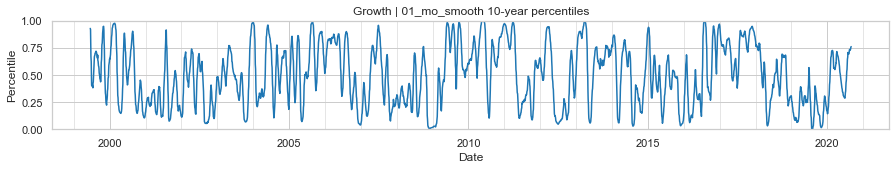

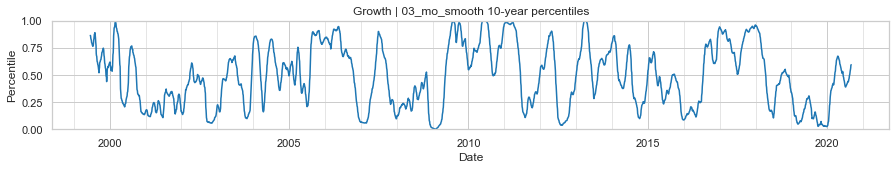

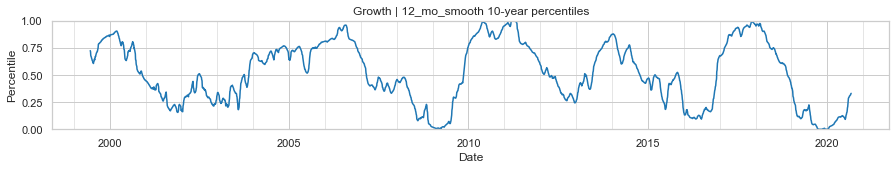

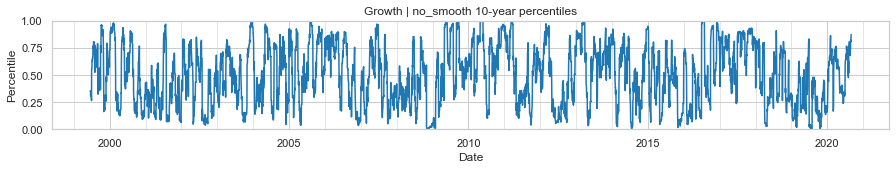

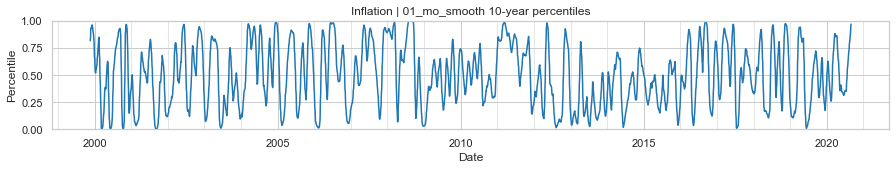

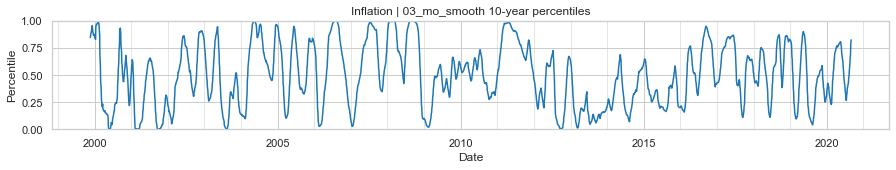

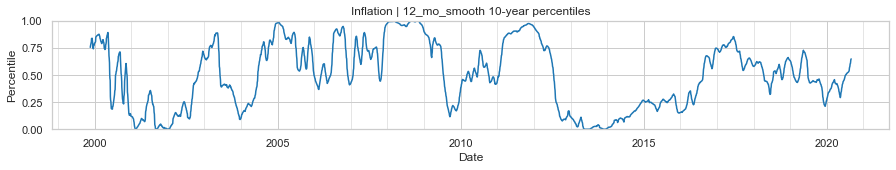

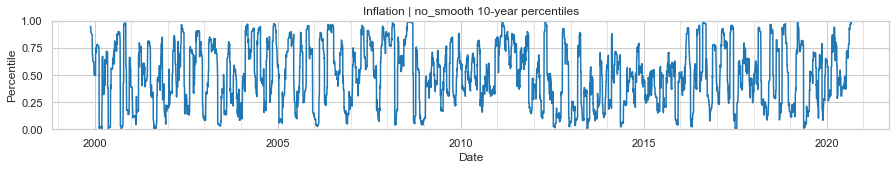

In [42]:
### RUN TO RE-EXPORT DATA: LEVEL PERCENTILE CONSTRUCTING (FORECAST STD)

gc.collect()
### Defining percentiles generator:
def take_level_ptile(ser_date):
    ### Check for empty vector (doing nothing):
    if (ser_date.count() > 0):
        ### Level percentile calculation:
        flo_level_ptile = ser_date.rank(method = 'average', na_option = 'keep', ascending = True, pct = True).iloc[-1]
        ### Results output:
        return flo_level_ptile
    else:
        ### Results output:        
        return np.NaN
### Surprise indices loading:
dict_surprise = {}
#dict_surprise['Announcement Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
#dict_surprise['Revision Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
dict_surprise['Full Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise_std)
### Looping over surprise indices:    
dict_idx_ptile = {}
for iter_surprise in dict_surprise:
    dict_iter_ptile = {}
    ### Looping over smoothing types:        
    for iter_forecast in dict_surprise[iter_surprise].columns:
        dict_iter_ptile[iter_forecast] = dict_surprise[iter_surprise][iter_forecast]\
                                                            .rolling(int_ptile_months_win * int_bus_month, min_periods = int_ptile_months_min * int_bus_month)\
                                                            .apply(take_level_ptile, raw = False) 
        ### Plot data preparation:
        df_to_plot = dict_iter_ptile[iter_forecast].reset_index()
        df_to_plot.columns = ['Date', 'Percentile']
        ### Plot creation:
        sns.set_style('whitegrid')
        plt.figure(figsize = (15, 2.0))
        sns.set_context('notebook') 
        ax_ptiles = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percentile')
        ax_ptiles.set_title(iter_forecast.partition('_')[0] + ' | ' + iter_forecast.partition('_')[-1] + ' 10-year percentiles')
        ax_ptiles.set_ylim((0.0, 1.0))
        ### Major ticker options:    
        ax_ptiles.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        ax_ptiles.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y')) 
        ### Minor ticker options:        
        ax_ptiles.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        ax_ptiles.grid(visible = True, which = 'minor', linewidth = 0.5)             
        plt.show()
#        break
    ### Percentiles saving:
    dict_idx_ptile[iter_surprise] = pd.concat(dict_iter_ptile, axis = 1)
#    break

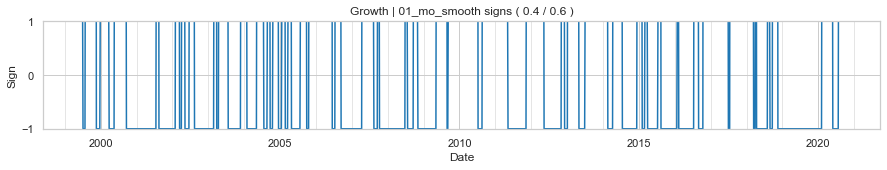

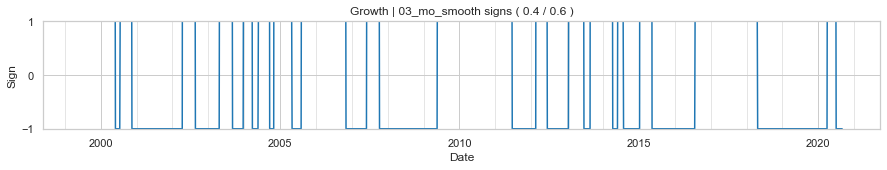

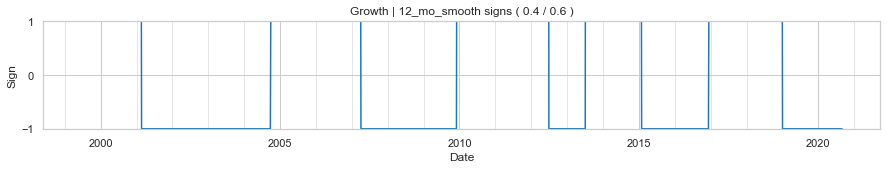

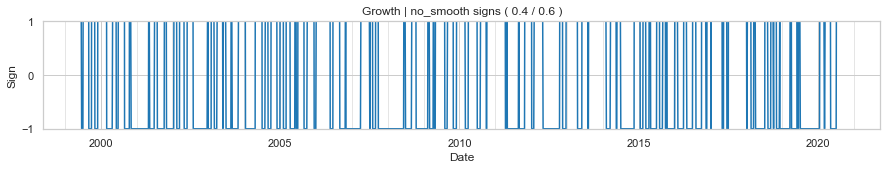

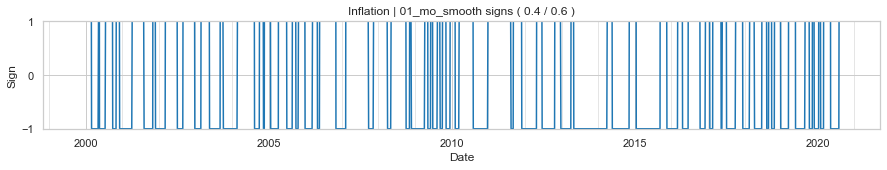

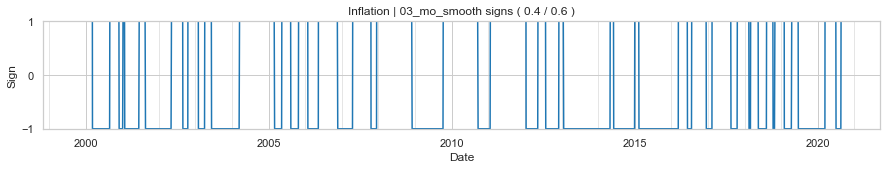

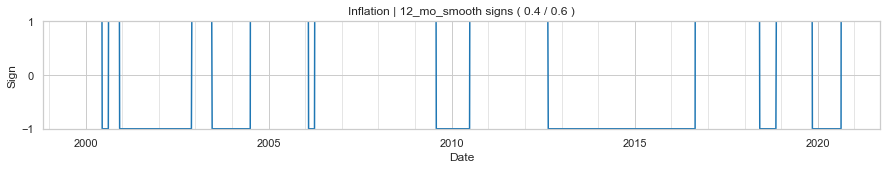

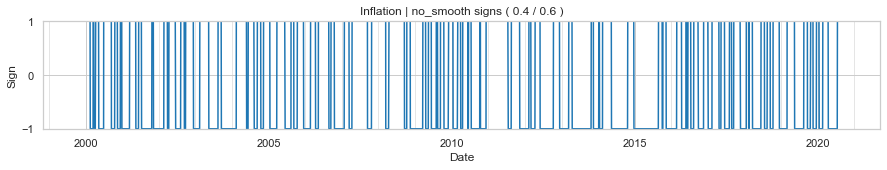

In [43]:
### RUN TO RE-EXPORT DATA: LEVEL SIGNS CONSTRUCTING (FORECAST STD)

### Constants defining:
tumbler_to_plus = 0.60
tumbler_to_minus = 0.40
### Looping over surprise indices:
dict_idx_sign = {}
for iter_surprise in dict_idx_ptile:
    ### Looping over smoothing types:
    dict_iter_sign = {}
    for iter_forecast in dict_idx_ptile[iter_surprise].columns:
#        print(iter_surprise, '|', iter_forecast)
        ser_iter_ptile = dict_idx_ptile[iter_surprise][iter_forecast]
        ser_iter_ptile = ser_iter_ptile[ser_iter_ptile.first_valid_index() : ]
        ser_iter_idx = dict_surprise[iter_surprise][iter_forecast].reindex(ser_iter_ptile.index)
        ser_iter_sign = pd.Series(np.NaN, ser_iter_ptile.index)
        ser_iter_sign.iloc[0] = 1
        for iter_prev_num, iter_prev_date in enumerate(ser_iter_sign.index[: -1]):
            iter_this_num = iter_prev_num + 1
            if (ser_iter_sign[iter_prev_num] == 1):
                if ((ser_iter_idx[iter_this_num] < 0.0) & (ser_iter_ptile[iter_this_num] <= tumbler_to_minus)):
                    ser_iter_sign[iter_this_num] = -1
                else:
                    ser_iter_sign[iter_this_num] = 1
            else:
                if ((ser_iter_idx[iter_this_num] > 0.0) & (ser_iter_ptile[iter_this_num] >= tumbler_to_plus)):
                    ser_iter_sign[iter_this_num] = 1
                else:
                    ser_iter_sign[iter_this_num] = -1
        dict_iter_sign[iter_forecast] = ser_iter_sign
        ### Plot creation:
        sns.set_style('whitegrid')
        plt.figure(figsize = (15, 2))
        sns.set_context('notebook') 
        df_to_plot = ser_iter_sign.reset_index()
        df_to_plot.columns = ['Date', 'Sign']
        ax_quantiles = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Sign')
        ax_quantiles.set_title(iter_forecast.partition('_')[0] + ' | ' + iter_forecast.partition('_')[-1] + 
                               ' signs ( ' + str(tumbler_to_minus) + ' / ' + str(tumbler_to_plus) + ' )')
        ax_quantiles.set_ylim((-1.01, 1.01))
        ### Major ticker options:    
        ax_quantiles.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        ax_quantiles.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y')) 
        ### Minor ticker options:        
        ax_quantiles.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        ax_quantiles.grid(visible = True, which = 'minor', linewidth = 0.5)             
        plt.show()       
#        break
    dict_idx_sign[iter_surprise] = pd.concat(dict_iter_sign, axis = 1)        
#    break
### Signs saving:
pd.concat(dict_idx_sign).to_hdf(str_path_bb_fcast_hdf, key = str_key_signs_std, mode = 'a')

In [21]:
### RUN TO RE-EXPORT DATA: TICKERS FILTERING DUE TO TYPE AND SURVEY DATA QUALITY (Z_SCORING)

### Empty revisions filling procedure:
def fill_empty_revision(df_ticker):
    str_ticker_name = df_ticker.index[0][0]
    df_filled = df_ticker.droplevel('Index_Name')
    if (str_ticker_name in idx_to_fill_empty_revision):
        ser_count_nans = df_filled['Revision_Value'].isna().astype(int).groupby(df_filled['Revision_Value'].notna().astype(int).cumsum()).cumsum()
        idx_nans_to_fill = ser_count_nans[(ser_count_nans > 0) & (ser_count_nans <= 2)].index
        df_filled.loc[idx_nans_to_fill, 'Revision_Value'] = df_filled.loc[idx_nans_to_fill, 'Release_Value']    
    return df_filled
### Dataframe loading:
df_dates_filled = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_norm_filled)
### Types and region export:
df_flags = pd.read_hdf(str_path_bb_idx_hdf, key = str_key_flags)
df_group_info = df_flags[['Type_Prime', 'Sub_Type', 'Region']].copy()
df_group_info['Type'] = df_group_info['Type_Prime'] + '/' + df_group_info['Sub_Type']
df_forecast_data = df_dates_filled.join(df_group_info, how = 'left')
### Dropping EI's having wrong Primary Types:
#df_forecast_data.drop(df_forecast_data[df_forecast_data['Type_Prime'].isin(['TAR', 'INF'])].index, inplace = True)
df_forecast_data = df_forecast_data[df_forecast_data['Type_Prime'] != 'TAR']
### Survey data stats:
print('Observations having Survey Median values:', round(df_forecast_data['Survey_Median'].count() / len(df_forecast_data.index), 4))
print('Observations having Survey Average values:', round(df_forecast_data['Survey_Average'].count() / len(df_forecast_data.index), 4))
print('Observations having neither Survey Median nor Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].isna() & df_forecast_data['Survey_Average'].isna()].index) / len(df_forecast_data.index), 4))
print('Observations having both Survey Median & Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & df_forecast_data['Survey_Average'].notna()].index) / len(df_forecast_data.index), 4))
print('Observations having only Survey Median values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & df_forecast_data['Survey_Average'].isna()].index) / len(df_forecast_data.index), 4))
print('Observations having only Survey Average values:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].isna() & df_forecast_data['Survey_Average'].notna()].index) / len(df_forecast_data.index), 4))
### Dropping rows doesn't have enough data:
df_forecast_data = df_forecast_data[['Release_Date', 'Release_Value', 'Revision_Value', 'Survey_Median', 'Forecast_Std', 'Observations_Number', 'Region', 'Type']]\
                                  .dropna(subset = ['Release_Date'])
### Dates arranging:
df_forecast_data['Release_Date'] = df_forecast_data['Release_Date'] + 0 * pd.offsets.BDay()
df_forecast_data = df_forecast_data[df_forecast_data['Release_Date'] <= datetime_end]
df_forecast_data = df_forecast_data.reset_index('Data_Date', drop = True).set_index('Release_Date', append = True).sort_index()
### Duplicated observations removal (2 * 14):
df_forecast_data = df_forecast_data[~df_forecast_data.index.duplicated(keep = 'last')]
### Wrong observation number rows marking:
print('Observations with incorrect forecasters number values (NaN, 0, 1, 2):', 
      round(len(df_forecast_data[df_forecast_data['Observations_Number'].isna() | df_forecast_data['Observations_Number'].isin([0, 1, 2])].index) / 
            len(df_forecast_data.index), 4))
#df_forecast_data['Observations_Number'].replace({np.NaN: -1, 0: -1, 1: -1, 2: -1}, inplace = True)
idx_changed_to_three = df_forecast_data[df_forecast_data['Observations_Number'].isna() | df_forecast_data['Observations_Number'].isin([0, 1, 2])].index
df_forecast_data['Observations_Number'].replace({np.NaN: 3, 0: 3, 1: 3, 2: 3}, inplace = True)
print('Weight, added by observation numbers replace:', 
      round(np.sqrt(df_forecast_data.loc[idx_changed_to_three, 'Observations_Number']).sum() / np.sqrt(df_forecast_data['Observations_Number']).sum(), 2))
print('Observations with incorrect forecasters number values having forecast std value:', 
      round(len(df_forecast_data[df_forecast_data['Forecast_Std'].notna() & (df_forecast_data['Observations_Number'] == -1)].index) / len(df_forecast_data.index), 4))
print('Observations with incorrect forecasters number values having survey median value:', 
      round(len(df_forecast_data[df_forecast_data['Survey_Median'].notna() & (df_forecast_data['Observations_Number'] == -1)].index) / len(df_forecast_data.index), 4))
### Empty revisions filling procedure:
df_forecast_data = df_forecast_data.groupby('Index_Name').apply(fill_empty_revision)
### Adding previous data date values to future Revision Surprise calculation:
df_forecast_data['Release_Prev'] = df_forecast_data['Release_Value'].groupby('Index_Name').shift()
df_forecast_data['Revision_Prev'] = df_forecast_data['Revision_Value'].groupby('Index_Name').shift()
df_forecast_data.drop('Revision_Value', axis = 1, inplace = True)
### Tickers data reindexation to common timeline:
idx_dates = sorted(df_forecast_data.index.get_level_values('Release_Date').unique())
df_reindexed = df_forecast_data.groupby('Index_Name').apply(lambda df_ticker: df_ticker.droplevel('Index_Name').reindex(idx_dates, method = 'ffill'))
### Clearing rows having incorrect data:
#df_cleared = df_reindexed[df_reindexed['Observations_Number'] > -1].copy().dropna(subset = ['Forecast_Std'])
df_cleared = df_reindexed.dropna(how = 'all')
print('Economic indices left to forecast indices generation:', len(df_cleared.index.get_level_values('Index_Name').unique()))
### Cleared and reindexed table saving:
df_cleared.to_hdf(str_path_bb_fcast_hdf, key = str_key_cleared_z, mode = 'a')
_ = gc.collect()

Observations having Survey Median values: 0.3572
Observations having Survey Average values: 0.3924
Observations having neither Survey Median nor Survey Average values: 0.6
Observations having both Survey Median & Survey Average values: 0.3496
Observations having only Survey Median values: 0.0076
Observations having only Survey Average values: 0.0429
Observations with incorrect forecasters number values (NaN, 0, 1, 2): 0.3844
Weight, added by observation numbers replace: 0.18
Observations with incorrect forecasters number values having forecast std value: 0.0
Observations with incorrect forecasters number values having survey median value: 0.0
Economic indices left to forecast indices generation: 202


In [22]:
### RUN TO RE-EXPORT DATA: SETTING TICKER/DATA PAIR WEIGHTS (Z_SCORING)

### Forecast data loading:
df_cleared = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_cleared_z)
df_cleared['Observations_Number'] = df_cleared['Observations_Number'].astype(int)
### Resampling to business daily frequency without gaps:
df_cleared = df_cleared.unstack('Index_Name').resample('B').asfreq().stack('Index_Name', dropna = False).swaplevel().sort_index()
### Adding rolling mean of obseravtions number:
df_cleared['Rolling_Obs_Number'] = df_cleared['Observations_Number'].unstack('Index_Name').sort_index().rolling(window = int_obs_num_win, min_periods = 1)\
                                                                    .mean().round(0).stack('Index_Name', dropna = False).swaplevel().sort_index()
### Dropping NA values (we need it only to correct rolling mean calculation):
df_weighted = df_cleared.dropna(subset = ['Region', 'Type']).drop('Observations_Number', axis = 1)
### Setting initial weight by square root of observations number:
df_weighted['Obs_Num_Weight'] = df_weighted.groupby(['Release_Date', 'Region', 'Type'])['Rolling_Obs_Number']\
                                           .apply(lambda ser_group: np.sqrt(ser_group) / np.sqrt(ser_group).sum())
### Extracting existing Date / Type / Region combinations:
ser_region_count = df_weighted.groupby(['Release_Date', 'Type', 'Region'])['Type'].count()
ser_region_count = ser_region_count / ser_region_count
ser_region_count.name = 'Group_Flag'
### Region weights preparing:
ser_region_weight = pd.DataFrame.from_dict(dict_region_weight, orient = 'index').squeeze()
ser_region_weight.name = 'Region_Weight'
### Adding region weights to combinations collection:
df_region_weight = ser_region_count.to_frame().join(ser_region_weight, how = 'left', on = 'Region')
### Region weights normalizing:
df_region_weight['Reg_Norm_Weight'] = df_region_weight.groupby(['Release_Date', 'Type'])['Region_Weight'].transform(lambda ser_group: ser_group / ser_group.sum())
### Adding normalized weights to main table:
df_weighted = df_weighted.join(df_region_weight['Reg_Norm_Weight'], how = 'left', on = ['Release_Date', 'Type', 'Region'])
### Adding Growth Index flag:
df_weighted['Growth'] = True
df_weighted.loc[df_weighted['Type'].isin(['INF/CPI', 'INF/PPI']), 'Growth'] = False
### Extracting existing Date / Type combinations:
ser_type_count = df_weighted.groupby(['Release_Date', 'Type'])['Type'].count()
ser_type_count = ser_type_count / ser_type_count
ser_type_count.name = 'Type_Flag'
### FPC weights export:
ser_fpc_weight = pd.read_hdf(str_path_bb_weights_hdf, key = str_weights_key).stack(dropna = False).swaplevel()
ser_fpc_weight.index.names = ['Type', 'Release_Date']
ser_fpc_weight.name = 'FPC_Weight'
### Adding region weights to combinations collection:
df_type_weight = ser_type_count.to_frame().join(ser_fpc_weight, how = 'left', on = ['Type', 'Release_Date'])
df_type_weight.loc[(All, ['INF/CPI', 'INF/PPI']), 'FPC_Weight'] = 0.5
### Adding Growth Index flag:
df_type_weight['Growth'] = True
df_type_weight.loc[(All, ['INF/CPI', 'INF/PPI']), 'Growth'] = False
### Type weights normalizing:
df_type_weight['Type_Norm_Weight'] = df_type_weight.groupby(['Release_Date', 'Growth'])['FPC_Weight'].transform(lambda ser_group: ser_group / ser_group.sum())
### Filling dates with empty FPC weights (3 dates filled):
df_type_weight['Type_Norm_Weight'] = df_type_weight['Type_Norm_Weight'].groupby('Type').ffill()
### Adding normalized weights to main table:
df_weighted = df_weighted.join(df_type_weight['Type_Norm_Weight'], how = 'left', on = ['Release_Date', 'Type'])
### Ticker weights calculating for each date / ticker pair:
df_weighted['Ticker_Weight'] = df_weighted['Obs_Num_Weight'] * df_weighted['Reg_Norm_Weight'] * df_weighted['Type_Norm_Weight']
### Table saving:
df_weighted[['Release_Value', 'Survey_Median', 'Forecast_Std', 'Rolling_Obs_Number', 'Ticker_Weight', 'Growth', 'Release_Prev', 'Revision_Prev']]\
           .to_hdf(str_path_bb_fcast_hdf, key = str_key_weighted_z, mode = 'a')

In [23]:
### RUN TO RE-EXPORT DATA: TOTAL SURPRISE INDEX CONSTRUCTING (Z_SCORING)

### Defining index vector average calculator:
def release_date_surprise(df_date, int_min_tickers_to_go):
    ser_date_announce = (df_date['Release_Value'] - df_date['Survey_Median'])
    ser_date_revision = (df_date['Revision_Prev'] - df_date['Release_Prev'])
    ser_date_surprise = pd.concat([ser_date_announce, ser_date_revision], axis = 1).sum(axis = 1).clip(list_clip[0], list_clip[1])
    if ser_date_surprise.count() >= int_min_tickers_to_go:
        flo_surprise = (ser_date_surprise * df_date['Ticker_Weight']).sum() / df_date['Ticker_Weight'].sum()
    else:
        flo_surprise = np.NaN
    return flo_surprise   
### Economic surprise data loading:
df_surprise = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_weighted_z)
### Data dividing:
dict_weighted = {}
dict_weighted['Growth'] = df_surprise[df_surprise['Growth'] == True]
dict_weighted['Inflation'] = df_surprise[df_surprise['Growth'] == False]
### Factors calculating:
dict_surprise = {}
for iter_key in dict_weighted:
    ser_surprise = dict_weighted[iter_key].dropna(how = 'all').groupby('Release_Date').apply(release_date_surprise, int_min_tickers_to_go)
    ser_surprise.index.name = 'Date'
    ### Replace NaN values with zero:
    ser_surprise_valid = ser_surprise[ser_surprise.first_valid_index() : ]
    print(iter_key, ': NaN values after first valid: ', len(ser_surprise_valid[ser_surprise_valid.isna()].index))
    ser_surprise.loc[ser_surprise_valid[ser_surprise_valid.isna()].index] = 0.0
    ### Preparing to save:    
    ser_surprise = ser_surprise.reindex(pd.date_range(ser_surprise.index.min(), ser_surprise.index.max(), freq = 'B')).ffill()
    dict_surprise[iter_key + '_no_smooth'] = ser_surprise
    ### Looping over smoothing options:
    for iter_month_num in list_smooth:
        dict_surprise[iter_key + '_' + str(iter_month_num).zfill(2) + '_mo_smooth'] = \
                                                                    ser_surprise.rolling(window = int_bus_month * iter_month_num, min_periods = int_bus_min).mean()
#        break
#    break
### Factor saving:
pd.concat(dict_surprise, axis = 1).sort_index(axis = 1).to_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise_z, mode = 'a')    

Growth : NaN values after first valid:  0
Inflation : NaN values after first valid:  0


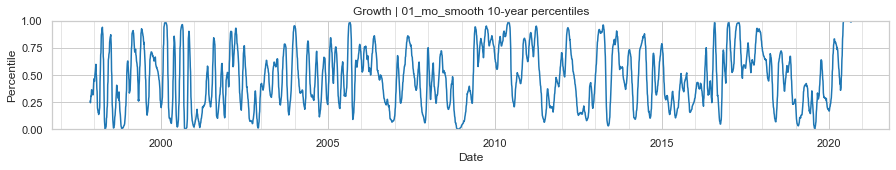

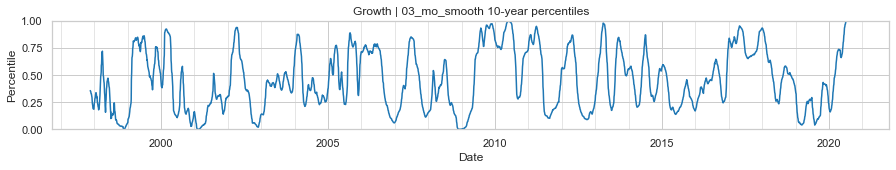

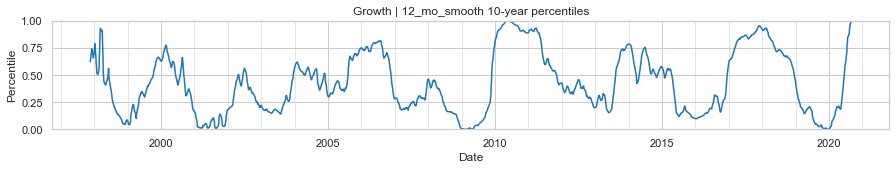

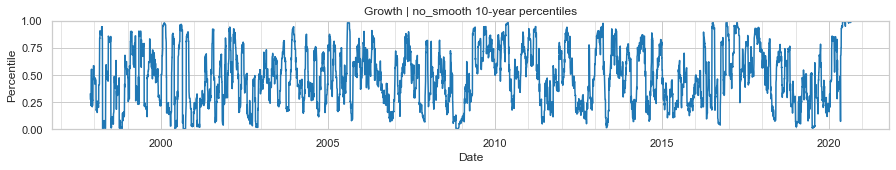

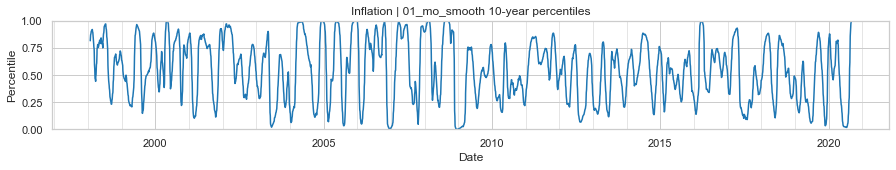

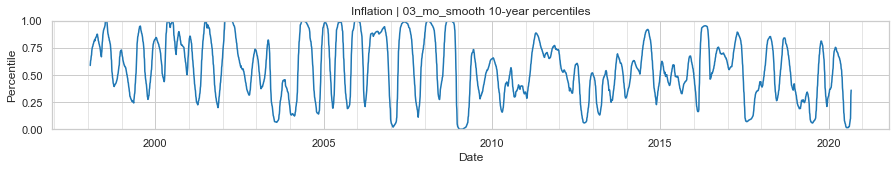

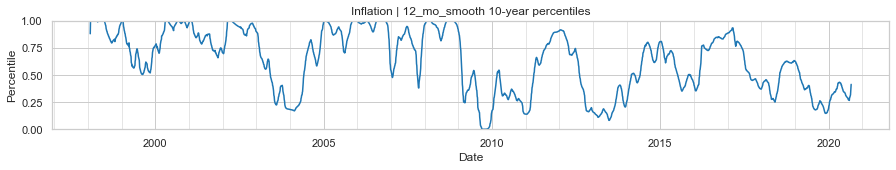

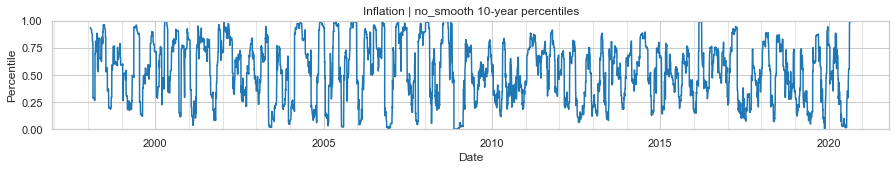

In [10]:
### RUN TO RE-EXPORT DATA: LEVEL PERCENTILE CONSTRUCTING (Z_SCORING)

gc.collect()
### Defining percentiles generator:
def take_level_ptile(ser_date):
    ### Check for empty vector (doing nothing):
    if (ser_date.count() > 0):
        ### Level percentile calculation:
        flo_level_ptile = ser_date.rank(method = 'average', na_option = 'keep', ascending = True, pct = True).iloc[-1]
        ### Results output:
        return flo_level_ptile
    else:
        ### Results output:        
        return np.NaN
### Surprise indices loading:
dict_surprise = {}
#dict_surprise['Announcement Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_announce)
#dict_surprise['Revision Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_revision)
dict_surprise['Full Surprise'] = pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_total_surprise_z)
### Looping over surprise indices:    
dict_idx_ptile = {}
for iter_surprise in dict_surprise:
    dict_iter_ptile = {}
    ### Looping over smoothing types:        
    for iter_forecast in dict_surprise[iter_surprise].columns:
        dict_iter_ptile[iter_forecast] = dict_surprise[iter_surprise][iter_forecast]\
                                                            .rolling(int_ptile_months_win * int_bus_month, min_periods = int_ptile_months_min * int_bus_month)\
                                                            .apply(take_level_ptile, raw = False) 
        ### Plot data preparation:
        df_to_plot = dict_iter_ptile[iter_forecast].reset_index()
        df_to_plot.columns = ['Date', 'Percentile']
        ### Plot creation:
        sns.set_style('whitegrid')
        plt.figure(figsize = (15, 2.0))
        sns.set_context('notebook') 
        ax_ptiles = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percentile')
        ax_ptiles.set_title(iter_forecast.partition('_')[0] + ' | ' + iter_forecast.partition('_')[-1] + ' 10-year percentiles')
        ax_ptiles.set_ylim((0.0, 1.0))
        ### Major ticker options:    
        ax_ptiles.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        ax_ptiles.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y')) 
        ### Minor ticker options:        
        ax_ptiles.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        ax_ptiles.grid(visible = True, which = 'minor', linewidth = 0.5)             
        plt.show()
#        break
    ### Percentiles saving:
    dict_idx_ptile[iter_surprise] = pd.concat(dict_iter_ptile, axis = 1)
#    break

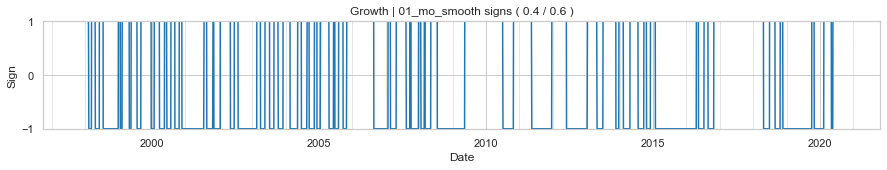

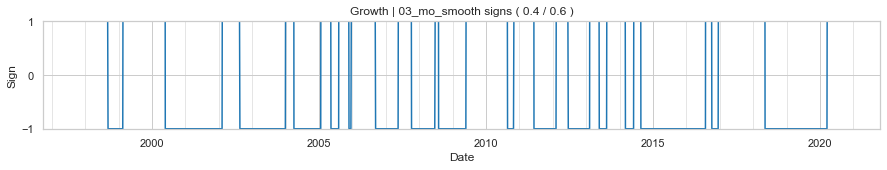

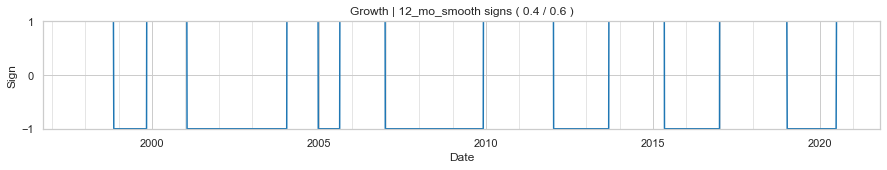

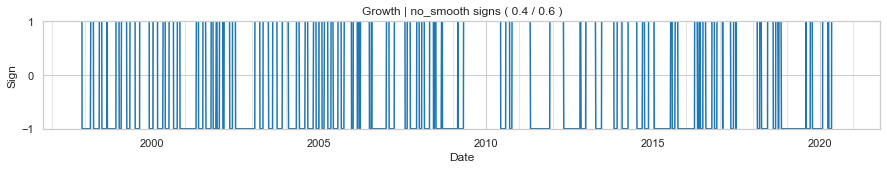

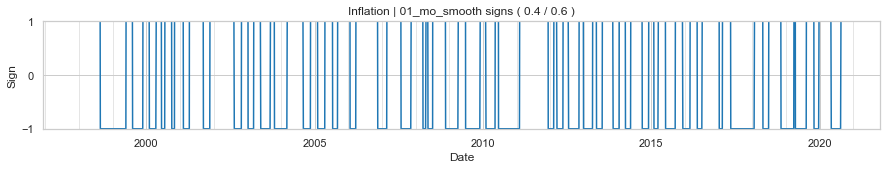

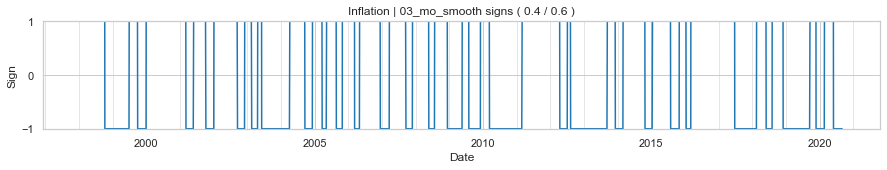

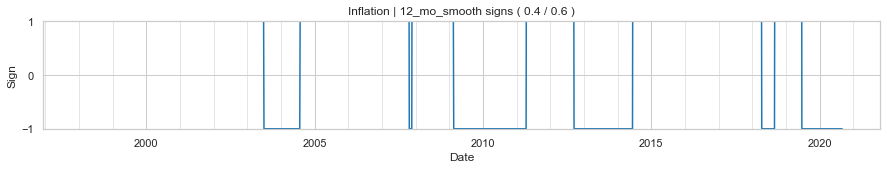

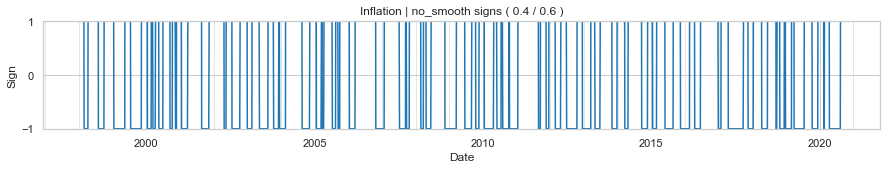

In [11]:
### RUN TO RE-EXPORT DATA: LEVEL SIGNS CONSTRUCTING (Z_SCORING)

### Constants defining:
tumbler_to_plus = 0.60
tumbler_to_minus = 0.40
### Looping over surprise indices:
dict_idx_sign = {}
for iter_surprise in dict_idx_ptile:
    ### Looping over smoothing types:
    dict_iter_sign = {}
    for iter_forecast in dict_idx_ptile[iter_surprise].columns:
#        print(iter_surprise, '|', iter_forecast)
        ser_iter_ptile = dict_idx_ptile[iter_surprise][iter_forecast]
        ser_iter_ptile = ser_iter_ptile[ser_iter_ptile.first_valid_index() : ]
        ser_iter_idx = dict_surprise[iter_surprise][iter_forecast].reindex(ser_iter_ptile.index)
        ser_iter_sign = pd.Series(np.NaN, ser_iter_ptile.index)
        ser_iter_sign.iloc[0] = 1
        for iter_prev_num, iter_prev_date in enumerate(ser_iter_sign.index[: -1]):
            iter_this_num = iter_prev_num + 1
            if (ser_iter_sign[iter_prev_num] == 1):
                if ((ser_iter_idx[iter_this_num] < 0.0) & (ser_iter_ptile[iter_this_num] <= tumbler_to_minus)):
                    ser_iter_sign[iter_this_num] = -1
                else:
                    ser_iter_sign[iter_this_num] = 1
            else:
                if ((ser_iter_idx[iter_this_num] > 0.0) & (ser_iter_ptile[iter_this_num] >= tumbler_to_plus)):
                    ser_iter_sign[iter_this_num] = 1
                else:
                    ser_iter_sign[iter_this_num] = -1
        dict_iter_sign[iter_forecast] = ser_iter_sign
        ### Plot creation:
        sns.set_style('whitegrid')
        plt.figure(figsize = (15, 2))
        sns.set_context('notebook') 
        df_to_plot = ser_iter_sign.reset_index()
        df_to_plot.columns = ['Date', 'Sign']
        ax_quantiles = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Sign')
        ax_quantiles.set_title(iter_forecast.partition('_')[0] + ' | ' + iter_forecast.partition('_')[-1] + 
                               ' signs ( ' + str(tumbler_to_minus) + ' / ' + str(tumbler_to_plus) + ' )')
        ax_quantiles.set_ylim((-1.01, 1.01))
        ### Major ticker options:    
        ax_quantiles.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
        ax_quantiles.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y')) 
        ### Minor ticker options:        
        ax_quantiles.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
        ax_quantiles.grid(visible = True, which = 'minor', linewidth = 0.5)             
        plt.show()       
#        break
    dict_idx_sign[iter_surprise] = pd.concat(dict_iter_sign, axis = 1)        
#    break
### Signs saving:
pd.concat(dict_idx_sign).to_hdf(str_path_bb_fcast_hdf, key = str_key_signs_z, mode = 'a')

In [10]:
### TEMP

pd.read_hdf(str_path_bb_fcast_hdf, key = str_key_signs_z).to_excel('Data_Files/Test_Files/Surprise_Signs_.xlsx', merge_cells = False)

Growth_01_mo_smooth  Growth_03_mo_smooth  \
Full Surprise 1997-11-19                  1.0                  1.0   
              1997-11-20                  1.0                  1.0   
              1997-11-21                  1.0                  1.0   
              1997-11-24                  1.0                  1.0   
              1997-11-25                  1.0                  1.0   
...                                       ...                  ...   
              2020-08-25                  1.0                  1.0   
              2020-08-26                  1.0                  1.0   
              2020-08-27                  1.0                  1.0   
              2020-08-28                  1.0                  1.0   
              2020-08-31                  1.0                  1.0   

                          Growth_12_mo_smooth  Growth_no_smooth  \
Full Surprise 1997-11-19                  1.0               1.0   
              1997-11-20                  1.0               1.0   
              1997-11-21                  1.0               1.0   
              1997-11-24                  1.0               1.0   
              1997-11-25                  1.0               1.0   
...                                       ...               ...   
              2020-08-25                  1.0               1.0   
              2020-08-26                  1.0               1.0   
              2020-08-27                  1.0               1.0   
              2020-08-28                  1.0               1.0   
              2020-08-31                  1.0               1.0   

                          Inflation_01_mo_smooth  Inflation_03_mo_smooth  \
Full Surprise 1997-11-19                     NaN                     NaN   
              1997-11-20                     NaN                     NaN   
              1997-11-21                     NaN                     NaN   
              1997-11-24                     NaN                     NaN   
              1997-11-25                     NaN                     NaN   
...                                          ...                     ...   
              2020-08-25                     1.0                    -1.0   
              2020-08-26                     1.0                    -1.0   
              2020-08-27                     1.0                    -1.0   
              2020-08-28                     1.0                    -1.0   
              2020-08-31                     1.0                    -1.0   

                          Inflation_12_mo_smooth  Inflation_no_smooth  
Full Surprise 1997-11-19                     NaN                  NaN  
              1997-11-20                     NaN                  NaN  
              1997-11-21                     NaN                  NaN  
              1997-11-24                     NaN                  NaN  
              1997-11-25                     NaN                  NaN  
...                                          ...                  ...  
              2020-08-25                    -1.0                  1.0  
              2020-08-26                    -1.0                  1.0  
              2020-08-27                    -1.0                  1.0  
              2020-08-28                    -1.0                  1.0  
              2020-08-31                    -1.0                  1.0  

[5944 rows x 8 columns]